# MODELE DE RISQUE DE DEFAUT DE PAIEMENT 


## PRET A DEPENSER


## 1 - Exploration des fichiers annexes 

### Prérequis, imports, définitions de fonctions : 

In [1]:
cd C:\\Users\\Wince\\Downloads\\OC\\Projet_4\\Projet+Mise+en+prod+-+home-credit-default-risk

C:\Users\Wince\Downloads\OC\Projet_4\Projet+Mise+en+prod+-+home-credit-default-risk


In [2]:
# -*- coding: utf-8 -*-
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import math
from sklearn.impute import SimpleImputer
from sklearn.impute import KNNImputer
from sklearn import decomposition
from sklearn import preprocessing
from sklearn import cluster
import scipy.stats as stats
import ipywidgets


In [3]:
def charger_reduire(fichier) : 

    # Import de l'échantillon
    print("\nlecture du dataset")
    chunk = pd.read_csv(fichier,
                        sep=',',header=0,decimal='.',chunksize=10000,low_memory=False)
    df=pd.concat(chunk)

    print(f"volume du df initial : {df.memory_usage().sum()} octets")
    print("réduction de données en cours")
    df.loc[:, df.dtypes == 'float64'] = df.loc[:, df.dtypes == 'float64'].astype('float32')
    df.loc[:, df.dtypes == 'int64'] = df.loc[:, df.dtypes == 'int64'].astype('int32')

    print(f"volume du df après réduction : {df.memory_usage().sum()} octets")
    l=(df.duplicated(keep='first').sum())#+(df.duplicated(['SK_ID_CURR'],keep='first').sum())
    print(f'{l} doublons sont en cours de suppression,index concernés : \n') 
    print(f'Doublons purs : {df.index[df.duplicated(keep="first")]}')      
    #print(f'\nDoublons par ID : {df.index[df.duplicated(["SK_ID_CURR"],keep="first")]}')
    df=df[df.duplicated(keep='first')==False]
    #df=df[df.duplicated(['SK_ID_CURR'],keep='first')==False]
    return df

def fill_rates(df) : 
    fill_ratio=pd.DataFrame((df.shape[0]-df.isna().sum().sort_values(ascending=True))/df.shape[0])
    return fill_ratio                                                                                                                                              

def basic_info(df, limite_aff=35,decr=True,save_plot=False, titre="") : 
    print(f"\nDimensions du dataframe : {df.shape}")
    print(f"Types de données contenues:\n{df.dtypes.value_counts()}")
    fill_ratio=pd.DataFrame((df.shape[0]-df.isna().sum().sort_values(ascending=decr))/df.shape[0])
    tete=fill_ratio.head(limite_aff)
    if decr : 
        t="décroissant" 
    else : 
        t="croissant"
    z=min(df.shape[1],limite_aff)
    print(f"Taux de remplissage des {z} premières variables par ordre {t} : ")
    print(tete)
    #Graphe de remplissage des variables
    plt.figure(figsize=(20,20))
    p=sns.barplot(x=tete.index, y=tete[0], palette='Blues')
    p.set_title(f"Taux de remplissage des {z} premières variables du dataframe par ordre {t} : ")
    p.set_xticklabels(tete.index, size=18,rotation='vertical')
    if save_plot : plt.savefig(titre)


In [4]:
def fillrate(s) : 
    rate=(s.size-s.isna().sum())/s.size
    return rate

In [5]:
trainfile=charger_reduire('application_train.csv')


lecture du dataset
volume du df initial : 300130864 octets
réduction de données en cours
volume du df après réduction : 169746200 octets
0 doublons sont en cours de suppression,index concernés : 

Doublons purs : Int64Index([], dtype='int64')


In [6]:


previous_df=charger_reduire('previous_application.csv')
payments_df=charger_reduire('installments_payments.csv')



lecture du dataset
volume du df initial : 494383472 octets
réduction de données en cours
volume du df après réduction : 354085496 octets
0 doublons sont en cours de suppression,index concernés : 

Doublons purs : Int64Index([], dtype='int64')

lecture du dataset
volume du df initial : 870745792 octets
réduction de données en cours
volume du df après réduction : 435372960 octets
0 doublons sont en cours de suppression,index concernés : 

Doublons purs : Int64Index([], dtype='int64')


## EDA 1 - Fichiers liés aux anciennes demandes : 

In [7]:
payments_df.describe()

SK_ID_PREV    SK_ID_CURR  NUM_INSTALMENT_VERSION  \
count  1.360540e+07  1.360540e+07            1.360540e+07   
mean   1.903365e+06  2.784449e+05            8.566373e-01   
std    5.362029e+05  1.027183e+05            1.035216e+00   
min    1.000001e+06  1.000010e+05            0.000000e+00   
25%    1.434191e+06  1.896390e+05            0.000000e+00   
50%    1.896520e+06  2.786850e+05            1.000000e+00   
75%    2.369094e+06  3.675300e+05            1.000000e+00   
max    2.843499e+06  4.562550e+05            1.780000e+02   

       NUM_INSTALMENT_NUMBER  DAYS_INSTALMENT  DAYS_ENTRY_PAYMENT  \
count           1.360540e+07     1.360540e+07        1.360250e+07   
mean            1.887090e+01    -1.042270e+03       -1.051114e+03   
std             2.666407e+01     8.009463e+02        8.005859e+02   
min             1.000000e+00    -2.922000e+03       -4.921000e+03   
25%             4.000000e+00    -1.654000e+03       -1.662000e+03   
50%             8.000000e+00    -8.180000e+02       -8.270000e+02   
75%             1.900000e+01    -3.610000e+02       -3.700000e+02   
max             2.770000e+02    -1.000000e+00       -1.000000e+00   

       AMT_INSTALMENT   AMT_PAYMENT  
count    1.360540e+07  1.360250e+07  
mean     1.705092e+04  1.723821e+04  
std      5.057025e+04  5.473578e+04  
min      0.000000e+00  0.000000e+00  
25%      4.226085e+03  3.398265e+03  
50%      8.884080e+03  8.125515e+03  
75%      1.671021e+04  1.610842e+04  
max      3.771488e+06  3.771488e+06

In [8]:
cash_df=charger_reduire('POS_CASH_balance.csv')


lecture du dataset
volume du df initial : 640087040 octets
réduction de données en cours
volume du df après réduction : 360049016 octets
0 doublons sont en cours de suppression,index concernés : 

Doublons purs : Int64Index([], dtype='int64')


In [9]:
cash_df.head(25)

SK_ID_PREV  SK_ID_CURR  MONTHS_BALANCE  CNT_INSTALMENT  \
0      1803195      182943             -31            48.0   
1      1715348      367990             -33            36.0   
2      1784872      397406             -32            12.0   
3      1903291      269225             -35            48.0   
4      2341044      334279             -35            36.0   
5      2207092      342166             -32            12.0   
6      1110516      204376             -38            48.0   
7      1387235      153211             -35            36.0   
8      1220500      112740             -31            12.0   
9      2371489      274851             -32            24.0   
10     2328294      287361             -32            12.0   
11     2023570      237959             -39            12.0   
12     1258390      278261             -32            36.0   
13     1627166      146161             -33            24.0   
14     1711625      131467             -34            12.0   
15     2374177      204722             -35            24.0   
16     1716688      405549             -33            12.0   
17     1846127      380050             -31            36.0   
18     1911764      312551             -32            24.0   
19     2645133      152810             -35            24.0   
20     1381005      195362             -34            60.0   
21     1366811      169489             -38            24.0   
22     1260621      244684             -32            18.0   
23     1445556      220181             -41            12.0   
24     1420240      386836             -41            12.0   

    CNT_INSTALMENT_FUTURE NAME_CONTRACT_STATUS  SK_DPD  SK_DPD_DEF  
0                    45.0               Active       0           0  
1                    35.0               Active       0           0  
2                     9.0               Active       0           0  
3                    42.0               Active       0           0  
4                    35.0               Active       0           0  
5                    12.0               Active       0           0  
6                    43.0               Active       0           0  
7                    36.0               Active       0           0  
8                    12.0               Active       0           0  
9                    16.0               Active       0           0  
10                   12.0               Active       0           0  
11                   12.0               Active       0           0  
12                   36.0               Active       0           0  
13                   24.0               Active       0           0  
14                    5.0               Active       0           0  
15                   15.0               Active       0           0  
16                    1.0               Active       0           0  
17                   28.0               Active       0           0  
18                   16.0               Active       0           0  
19                   23.0               Active       0           0  
20                   56.0               Active       0           0  
21                   24.0               Active       0           0  
22                   12.0               Active       0           0  
23                   12.0               Active       0           0  
24                   11.0               Active       0           0

In [10]:
credit=charger_reduire('credit_card_balance.csv')


lecture du dataset
volume du df initial : 706617536 octets
réduction de données en cours
volume du df après réduction : 368670080 octets
0 doublons sont en cours de suppression,index concernés : 

Doublons purs : Int64Index([], dtype='int64')



Dimensions du dataframe : (3840312, 23)
Types de données contenues:
float32    15
int32       7
object      1
dtype: int64
Taux de remplissage des 23 premières variables par ordre décroissant : 
                                   0
SK_ID_PREV                  1.000000
NAME_CONTRACT_STATUS        1.000000
CNT_DRAWINGS_CURRENT        1.000000
AMT_TOTAL_RECEIVABLE        1.000000
AMT_RECIVABLE               1.000000
AMT_RECEIVABLE_PRINCIPAL    1.000000
SK_DPD                      1.000000
AMT_PAYMENT_TOTAL_CURRENT   1.000000
AMT_DRAWINGS_CURRENT        1.000000
AMT_CREDIT_LIMIT_ACTUAL     1.000000
AMT_BALANCE                 1.000000
MONTHS_BALANCE              1.000000
SK_ID_CURR                  1.000000
SK_DPD_DEF                  1.000000
AMT_INST_MIN_REGULARITY     0.920518
CNT_INSTALMENT_MATURE_CUM   0.920518
AMT_DRAWINGS_POS_CURRENT    0.804751
AMT_DRAWINGS_ATM_CURRENT    0.804751
CNT_DRAWINGS_ATM_CURRENT    0.804751
CNT_DRAWINGS_OTHER_CURRENT  0.804751
CNT_DRAWINGS_POS_CURRENT   

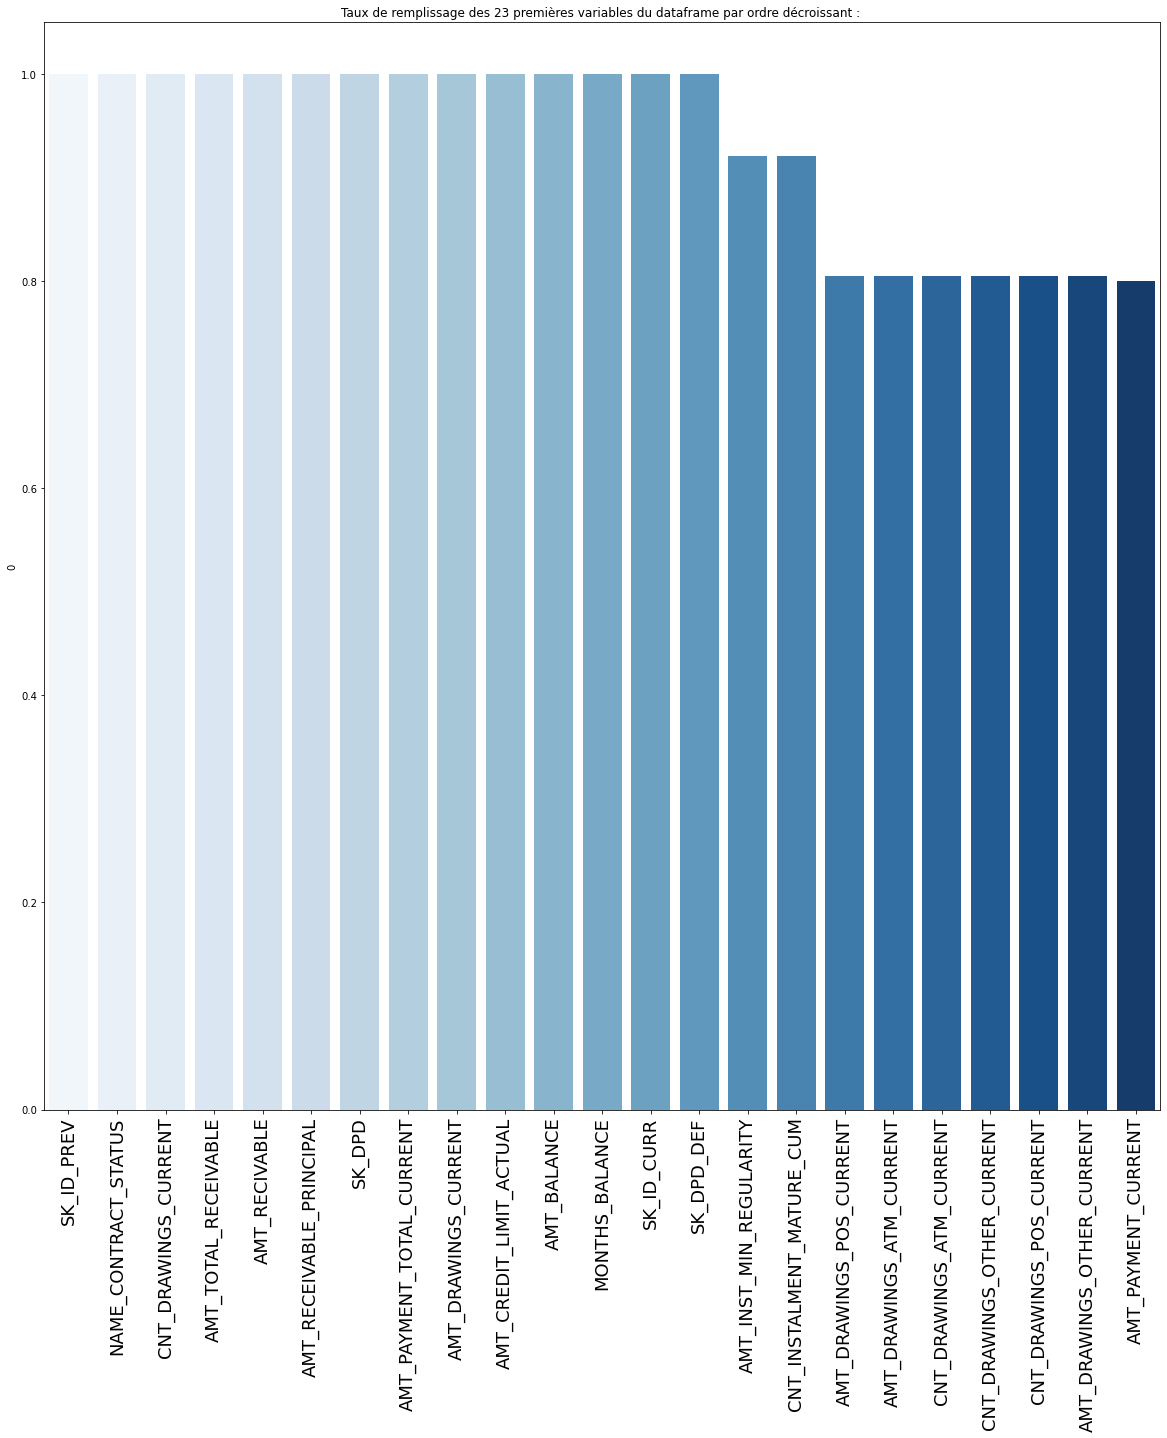

In [11]:
basic_info(credit)

In [12]:
credit.head(20)

SK_ID_PREV  SK_ID_CURR  MONTHS_BALANCE    AMT_BALANCE  \
0      2562384      378907              -6      56.970001   
1      2582071      363914              -1   63975.554688   
2      1740877      371185              -7   31815.224609   
3      1389973      337855              -4  236572.109375   
4      1891521      126868              -1  453919.468750   
5      2646502      380010              -7   82903.812500   
6      1079071      171320              -6  353451.656250   
7      2095912      118650              -7   47962.125000   
8      2181852      367360              -4  291543.062500   
9      1235299      203885              -5  201261.187500   
10     1108284      209660              -7  102076.562500   
11     2740914      340339              -1  131669.140625   
12     1985699      302517              -4    1427.265015   
13     1441883      171537              -5       0.000000   
14     1864742      303581              -1       0.000000   
15     2037377      289902              -1  131294.343750   
16     1816636      255981              -6   72899.953125   
17     1039039      276642              -6       0.000000   
18     2016842      302450              -3       0.000000   
19     1189095      231608              -4  452774.687500   

    AMT_CREDIT_LIMIT_ACTUAL  AMT_DRAWINGS_ATM_CURRENT  AMT_DRAWINGS_CURRENT  \
0                    135000                       0.0            877.500000   
1                     45000                    2250.0           2250.000000   
2                    450000                       0.0              0.000000   
3                    225000                    2250.0           2250.000000   
4                    450000                       0.0          11547.000000   
5                    270000                       0.0              0.000000   
6                    585000                   67500.0          67500.000000   
7                     45000                   45000.0          45000.000000   
8                    292500                   90000.0         289339.437500   
9                    225000                   76500.0         111026.703125   
10                   180000                   92250.0          92250.000000   
11                   225000                   10800.0          10800.000000   
12                   135000                    4500.0         101304.718750   
13                   270000                       0.0              0.000000   
14                    45000                       0.0              0.000000   
15                   135000                       0.0              0.000000   
16                   450000                   67500.0          67500.000000   
17                    67500                       0.0              0.000000   
18                        0                       0.0              0.000000   
19                   450000                    9000.0           9000.000000   

    AMT_DRAWINGS_OTHER_CURRENT  AMT_DRAWINGS_POS_CURRENT  \
0                          0.0                877.500000   
1                          0.0                  0.000000   
2                          0.0                  0.000000   
3                          0.0                  0.000000   
4                          0.0              11547.000000   
5                          0.0                  0.000000   
6                          0.0                  0.000000   
7                          0.0                  0.000000   
8                          0.0             199339.421875   
9                          0.0              34526.699219   
10                         0.0                  0.000000   
11                         0.0                  0.000000   
12                         0.0              96804.718750   
13                         0.0                  0.000000   
14                         0.0                  0.000000   
15                         0.0                  0.000000   
16                         0.0            

In [13]:
previous_df.head(25)

SK_ID_PREV  SK_ID_CURR NAME_CONTRACT_TYPE   AMT_ANNUITY  AMT_APPLICATION  \
0      2030495      271877     Consumer loans   1730.430054          17145.0   
1      2802425      108129         Cash loans  25188.615234         607500.0   
2      2523466      122040         Cash loans  15060.735352         112500.0   
3      2819243      176158         Cash loans  47041.335938         450000.0   
4      1784265      202054         Cash loans  31924.394531         337500.0   
5      1383531      199383         Cash loans  23703.929688         315000.0   
6      2315218      175704         Cash loans           NaN              0.0   
7      1656711      296299         Cash loans           NaN              0.0   
8      2367563      342292         Cash loans           NaN              0.0   
9      2579447      334349         Cash loans           NaN              0.0   
10     1715995      447712         Cash loans  11368.620117         270000.0   
11     2257824      161140         Cash loans  13832.775391         211500.0   
12     2330894      258628         Cash loans  12165.209961         148500.0   
13     1397919      321676     Consumer loans   7654.859863          53779.5   
14     2273188      270658     Consumer loans   9644.219727          26550.0   
15     1232483      151612     Consumer loans  21307.455078         126490.5   
16     2163253      154602     Consumer loans   4187.339844          26955.0   
17     1285768      142748    Revolving loans   9000.000000         180000.0   
18     2393109      396305         Cash loans  10181.700195         180000.0   
19     1173070      199178         Cash loans   4666.500000          45000.0   
20     1506815      166490         Cash loans  25454.025391         450000.0   
21     1182516      267782         Cash loans  20361.599609         405000.0   
22     1172842      302212         Cash loans           NaN              0.0   
23     1172937      302212         Cash loans  39475.304688        1129500.0   
24     1555330      199353         Cash loans           NaN              0.0   

    AMT_CREDIT  AMT_DOWN_PAYMENT  AMT_GOODS_PRICE WEEKDAY_APPR_PROCESS_START  \
0      17145.0               0.0          17145.0                   SATURDAY   
1     679671.0               NaN         607500.0                   THURSDAY   
2     136444.5               NaN         112500.0                    TUESDAY   
3     470790.0               NaN         450000.0                     MONDAY   
4     404055.0               NaN         337500.0                   THURSDAY   
5     340573.5               NaN         315000.0                   SATURDAY   
6          0.0               NaN              NaN                    TUESDAY   
7          0.0               NaN              NaN                     MONDAY   
8          0.0               NaN              NaN                     MONDAY   
9          0.0               NaN              NaN                   SATURDAY   
10    335754.0               NaN         270000.0                     FRIDAY   
11    246397.5               NaN         211500.0                     FRIDAY   
12    174361.5               NaN         148500.0                    TUESDAY   
13     57564.0               0.0          53779.5                     SUNDAY   
14     27252.0               0.0          26550.0                   SATURDAY   
15    119853.0           12649.5         126490.5                    TUESDAY   
16     27297.0            1350.0          26955.0                   SATURDAY   
17    180000.0               NaN         180000.0                     FRIDAY   
18    180000.0               NaN         180000.0                   THURSDAY   
19     49455.0               NaN          45000.0                   SATURDAY   
20    491580.0               NaN         450000.0                     MONDAY   
21    451777.5               NaN         405000.0                   SATURDAY   
22         0.0               NaN              NaN                    TUESDAY   
23 


Dimensions du dataframe : (1670214, 37)
Types de données contenues:
object     16
float32    15
int32       6
dtype: int64
Taux de remplissage des 35 premières variables par ordre décroissant : 
                                    0
SK_ID_PREV                   1.000000
NAME_YIELD_GROUP             1.000000
NAME_SELLER_INDUSTRY         1.000000
SELLERPLACE_AREA             1.000000
CHANNEL_TYPE                 1.000000
NAME_PRODUCT_TYPE            1.000000
NAME_PORTFOLIO               1.000000
NAME_GOODS_CATEGORY          1.000000
NAME_CLIENT_TYPE             1.000000
CODE_REJECT_REASON           1.000000
DAYS_DECISION                1.000000
NAME_CONTRACT_STATUS         1.000000
NAME_CASH_LOAN_PURPOSE       1.000000
NAME_PAYMENT_TYPE            1.000000
AMT_APPLICATION              1.000000
NFLAG_LAST_APPL_IN_DAY       1.000000
FLAG_LAST_APPL_PER_CONTRACT  1.000000
HOUR_APPR_PROCESS_START      1.000000
WEEKDAY_APPR_PROCESS_START   1.000000
NAME_CONTRACT_TYPE           1.000000
SK_ID_

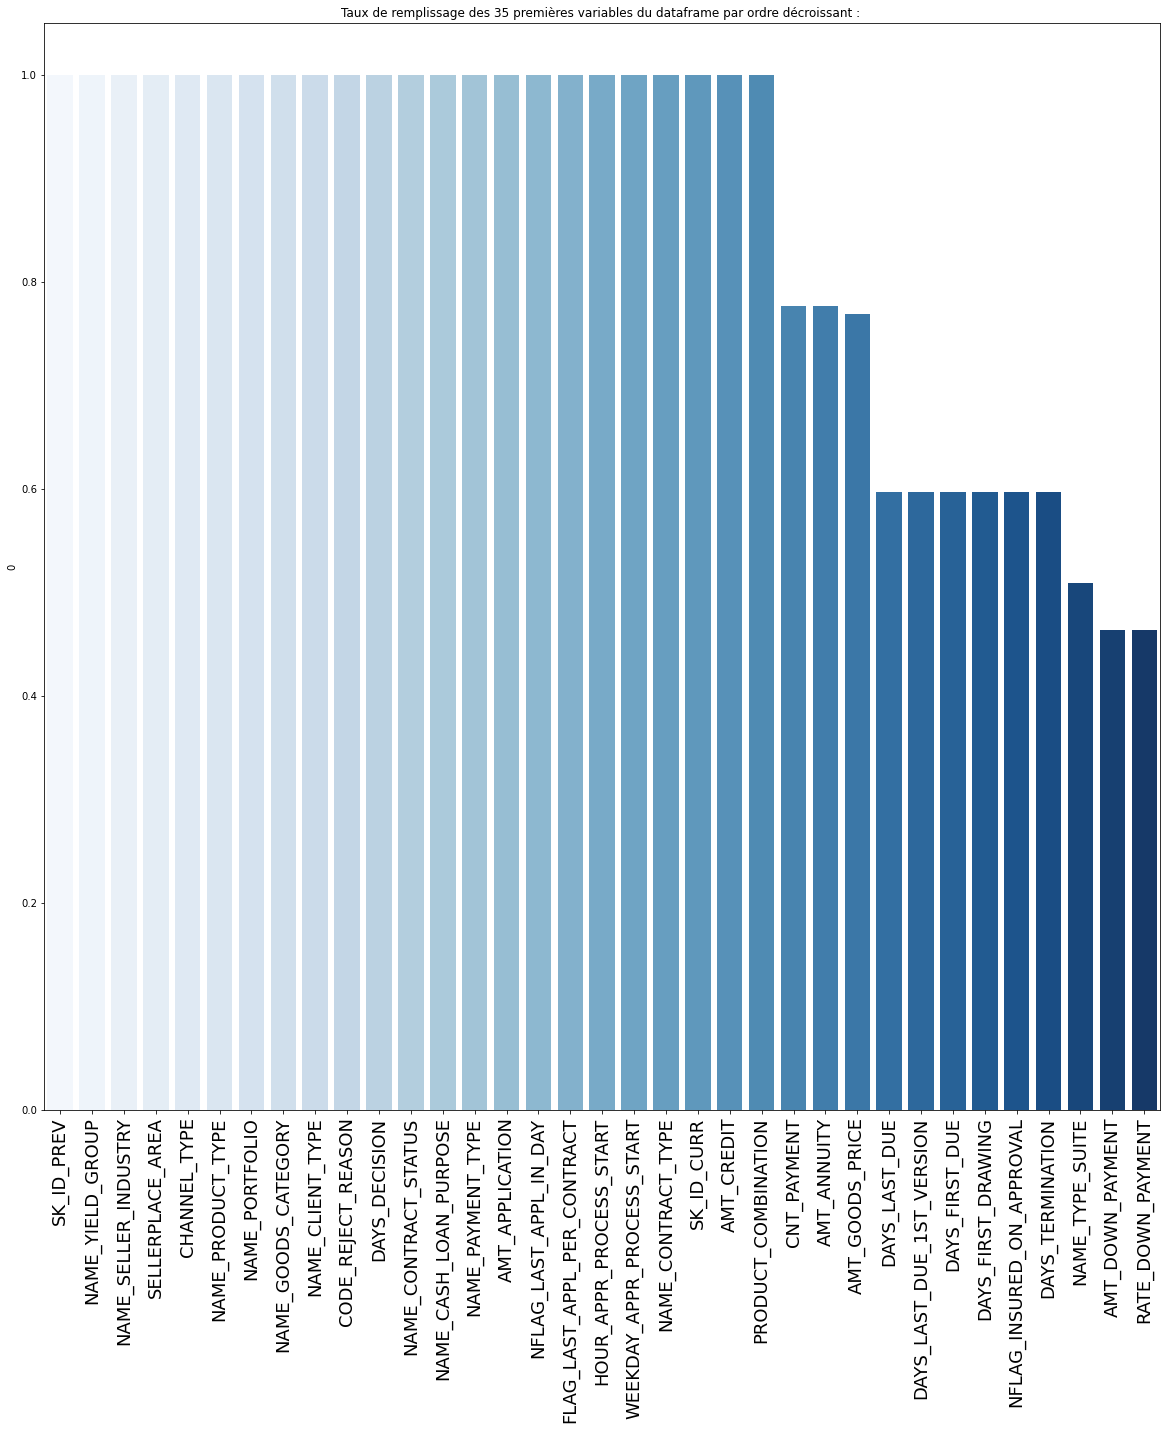

In [14]:
basic_info(previous_df)

In [15]:
previous_df.SK_ID_CURR.value_counts()

187868    77
265681    73
173680    72
242412    68
206783    67
          ..
310932     1
308885     1
317081     1
335520     1
350314     1
Name: SK_ID_CURR, Length: 338857, dtype: int64

In [16]:
cash_df.SK_ID_CURR.value_counts()

265042    295
172612    247
309133    246
185185    245
127659    245
         ... 
121023      1
188950      1
297094      1
430611      1
357019      1
Name: SK_ID_CURR, Length: 337252, dtype: int64

In [17]:
payments_df.SK_ID_CURR.value_counts()

145728    372
296205    350
453103    347
189699    344
186851    337
         ... 
158012      1
411412      1
274820      1
355653      1
212601      1
Name: SK_ID_CURR, Length: 339587, dtype: int64

In [18]:
credit.SK_ID_CURR.value_counts()

186401    192
311118    178
120076    140
128827    129
432607    128
         ... 
444164      1
434166      1
380770      1
268294      1
100115      1
Name: SK_ID_CURR, Length: 103558, dtype: int64

## EDA 2 - Fichiers liés au Credit Bureau

In [19]:
bureau=charger_reduire('bureau.csv')


lecture du dataset
volume du df initial : 233434336 octets
réduction de données en cours
volume du df après réduction : 137314368 octets
0 doublons sont en cours de suppression,index concernés : 

Doublons purs : Int64Index([], dtype='int64')


In [20]:
bureau.shape

(1716428, 17)


Dimensions du dataframe : (1716428, 17)
Types de données contenues:
float32    8
int32      6
object     3
dtype: int64
Taux de remplissage des 17 premières variables par ordre décroissant : 
                               0
SK_ID_CURR              1.000000
SK_ID_BUREAU            1.000000
CREDIT_ACTIVE           1.000000
CREDIT_CURRENCY         1.000000
DAYS_CREDIT             1.000000
CREDIT_DAY_OVERDUE      1.000000
DAYS_CREDIT_UPDATE      1.000000
CNT_CREDIT_PROLONG      1.000000
AMT_CREDIT_SUM_OVERDUE  1.000000
CREDIT_TYPE             1.000000
AMT_CREDIT_SUM          0.999992
DAYS_CREDIT_ENDDATE     0.938504
AMT_CREDIT_SUM_DEBT     0.849881
AMT_CREDIT_SUM_LIMIT    0.655226
DAYS_ENDDATE_FACT       0.630830
AMT_CREDIT_MAX_OVERDUE  0.344867
AMT_ANNUITY             0.285265


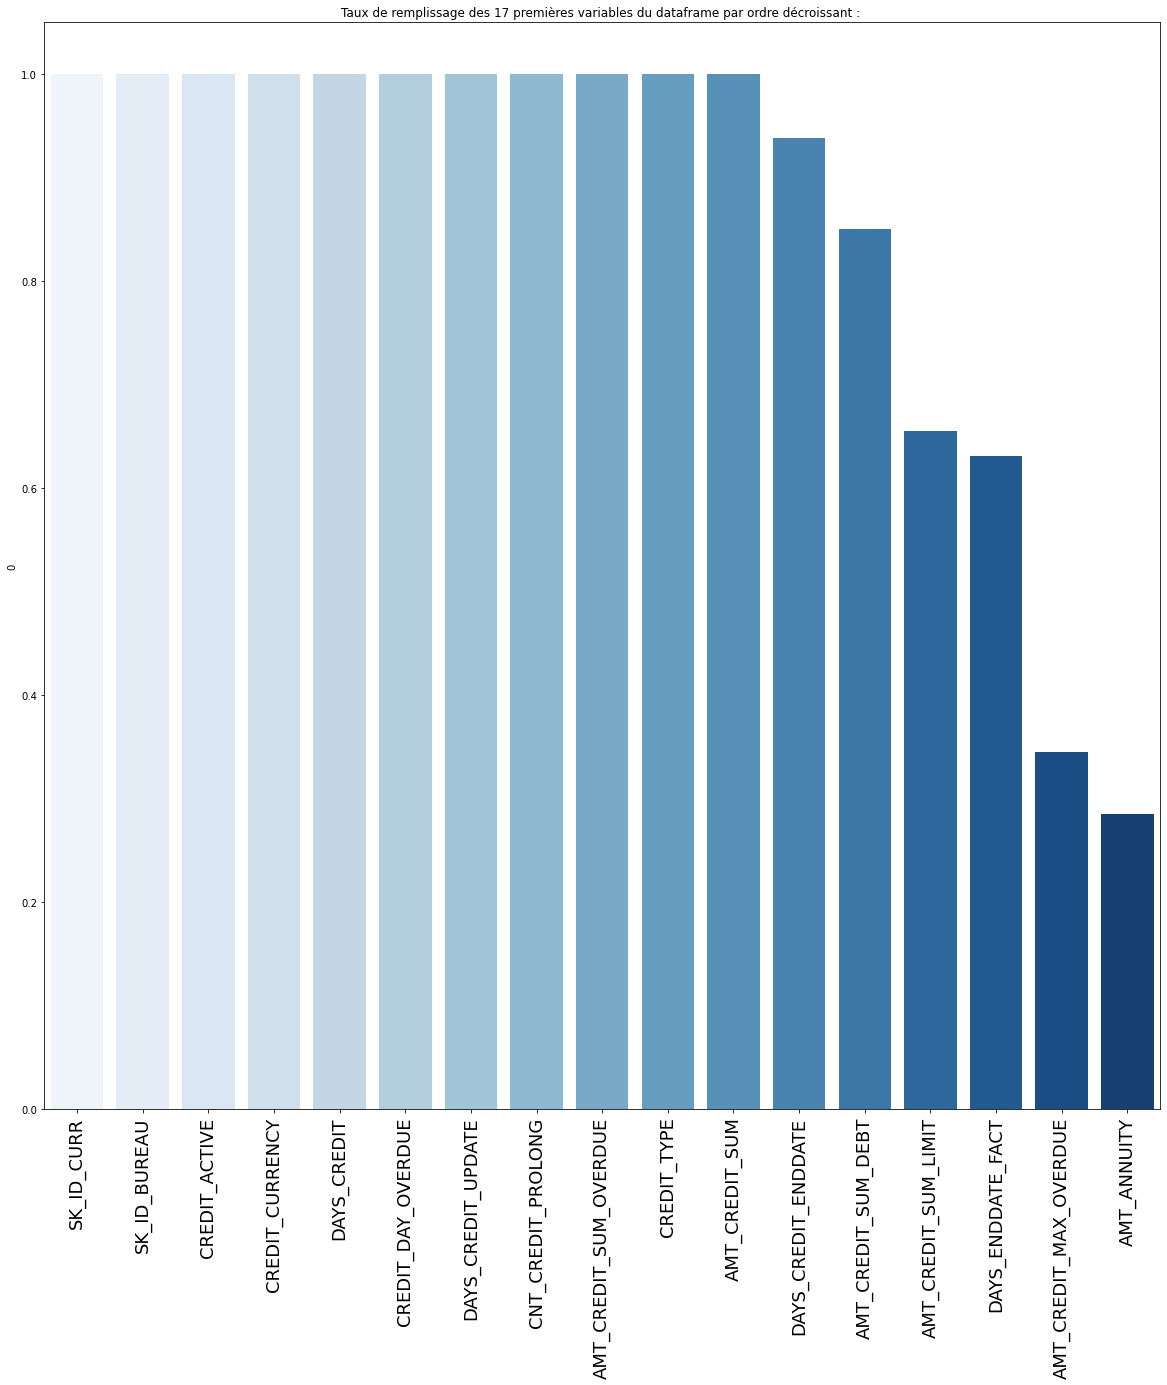

In [21]:
basic_info(bureau)

In [22]:
bureau_bal=charger_reduire('bureau_balance.csv')


lecture du dataset
volume du df initial : 655198328 octets
réduction de données en cours
volume du df après réduction : 436798928 octets
0 doublons sont en cours de suppression,index concernés : 

Doublons purs : Int64Index([], dtype='int64')



Dimensions du dataframe : (27299925, 3)
Types de données contenues:
int32     2
object    1
dtype: int64
Taux de remplissage des 3 premières variables par ordre décroissant : 
                  0
SK_ID_BUREAU    1.0
MONTHS_BALANCE  1.0
STATUS          1.0


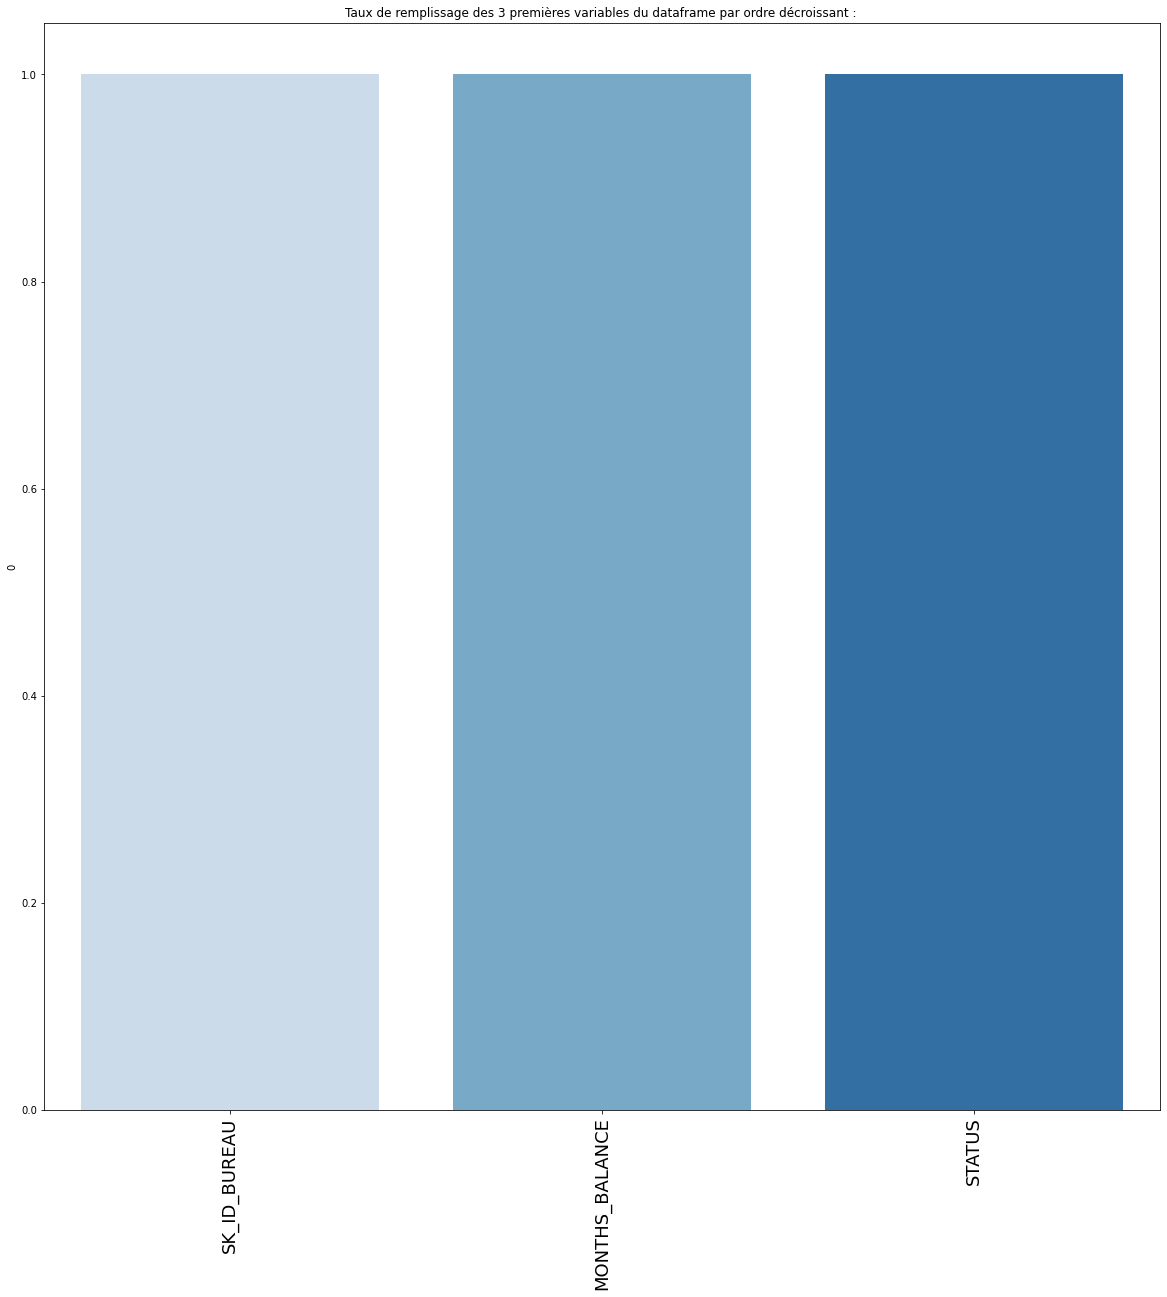

In [23]:
basic_info(bureau_bal)

## Feature Engineering Partie 1 - Fichiers liés au Credit Bureau

In [24]:
bureau_bal[bureau_bal.SK_ID_BUREAU.isin(bureau.SK_ID_BUREAU.unique())].STATUS.value_counts()

C    11555429
0     7195282
X     5115090
1      229773
5       50334
2       20954
3        7833
4        5046
Name: STATUS, dtype: int64

In [25]:
len(bureau_bal[bureau_bal.SK_ID_BUREAU.isin(bureau[bureau.SK_ID_CURR.isin(trainfile.SK_ID_CURR)].SK_ID_BUREAU.unique())].SK_ID_BUREAU.unique())

523515

In [26]:
def bb_agg(bureau_bal) : 
    #On garde uniquement les indexes correspondant à des ID présents dans le fichier bureau : 
    bureau_bal=bureau_bal[bureau_bal.SK_ID_BUREAU.isin(bureau.SK_ID_BUREAU.unique())]
    #On aggrège les retards indexés de façon ordinale dans la colonne status : 
    bureau_bal.loc[:,['STATUS_AGG']]=bureau_bal['STATUS'].replace(['C','X'],0)
    bureau_bal.loc[:,['STATUS_AGG']]=bureau_bal['STATUS_AGG'].apply(pd.to_numeric)
    som=bureau_bal.groupby('SK_ID_BUREAU').sum().rename(columns={'STATUS_AGG':'STATUS_AGG_SUM'}).STATUS_AGG_SUM
    moy=bureau_bal.groupby('SK_ID_BUREAU').mean().rename(columns={'STATUS_AGG':'STATUS_AGG_MEAN'}).STATUS_AGG_MEAN
    maxi=bureau_bal.groupby('SK_ID_BUREAU').max().rename(columns={'STATUS_AGG':'STATUS_AGG_MAX'}).STATUS_AGG_MAX
    agg=pd.concat([som,moy,maxi],axis=1)
    return agg

aggreg=bb_agg(bureau_bal)
bureau=bureau.join(aggreg,on='SK_ID_BUREAU')
bureau

C:\Users\Wince\anaconda3\envs\food\lib\site-packages\pandas\core\indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


SK_ID_CURR  SK_ID_BUREAU CREDIT_ACTIVE CREDIT_CURRENCY  DAYS_CREDIT  \
0            215354       5714462        Closed      currency 1         -497   
1            215354       5714463        Active      currency 1         -208   
2            215354       5714464        Active      currency 1         -203   
3            215354       5714465        Active      currency 1         -203   
4            215354       5714466        Active      currency 1         -629   
...             ...           ...           ...             ...          ...   
1716423      259355       5057750        Active      currency 1          -44   
1716424      100044       5057754        Closed      currency 1        -2648   
1716425      100044       5057762        Closed      currency 1        -1809   
1716426      246829       5057770        Closed      currency 1        -1878   
1716427      246829       5057778        Closed      currency 1         -463   

         CREDIT_DAY_OVERDUE  DAYS_CREDIT_ENDDATE  DAYS_ENDDATE_FACT  \
0                         0               -153.0             -153.0   
1                         0               1075.0                NaN   
2                         0                528.0                NaN   
3                         0                  NaN                NaN   
4                         0               1197.0                NaN   
...                     ...                  ...                ...   
1716423                   0                -30.0                NaN   
1716424                   0              -2433.0            -2493.0   
1716425                   0              -1628.0             -970.0   
1716426                   0              -1513.0            -1513.0   
1716427                   0                  NaN             -387.0   

         AMT_CREDIT_MAX_OVERDUE  CNT_CREDIT_PROLONG  AMT_CREDIT_SUM  \
0                           NaN                   0    9.132300e+04   
1                           NaN                   0    2.250000e+05   
2                           NaN                   0    4.643235e+05   
3                           NaN                   0    9.000000e+04   
4                       77674.5                   0    2.700000e+06   
...                         ...                 ...             ...   
1716423                     0.0                   0    1.125000e+04   
1716424                  5476.5                   0    3.813084e+04   
1716425                     NaN                   0    1.557000e+04   
1716426                     NaN                   0    3.600000e+04   
1716427                     NaN                   0    2.250000e+04   

         AMT_CREDIT_SUM_DEBT  AMT_CREDIT_SUM_LIMIT  AMT_CREDIT_SUM_OVERDUE  \
0                        0.0                   NaN                     0.0   
1                   171342.0                   NaN                     0.0   
2                        NaN                   NaN                     0.0   
3                        NaN                   NaN                     0.0   
4                        NaN                   NaN                     0.0   
...                      ...                   ...                     ...   
1716423              11250.0                   0.0                     0.0   
1716424                  0.0                   0.0                     0.0   
1716425                  NaN                   NaN                     0.0   
1716426                  0.0                   0.0                     0.0   
1716427                  0.0                   NaN                     0.0   

             CREDIT_TYPE  DAYS_CREDIT_UPDATE  AMT_ANNUITY  STATUS_AGG_SUM  \
0        Consumer credit                -131          NaN             NaN   
1            Credit card                 -20          NaN             NaN   
2        Consumer credit                 -16          NaN             NaN   
3            Credit card                 -16          NaN             NaN   
4        Consumer cr

In [27]:
def agg_bureau(bureau) : 
     
    aggr_dict={
        'CREDIT_DAY_OVERDUE': ['max'],
        'AMT_CREDIT_MAX_OVERDUE': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_OVERDUE': ['max', 'mean', 'sum'],
        'CNT_CREDIT_PROLONG':['max', 'mean', 'sum'],
        'STATUS_AGG_SUM':['max', 'mean', 'sum'],
        'STATUS_AGG_MEAN':['max', 'mean', 'sum'],
        'STATUS_AGG_MAX':['max', 'mean', 'sum']        
    }
    aggr=bureau[bureau.SK_ID_CURR.isin(trainfile.SK_ID_CURR.unique())].groupby('SK_ID_CURR').agg(aggr_dict)
    aggr.columns=pd.Index(i[0]+'_'+i[1].upper() for i in aggr.columns.tolist())
    return aggr


In [28]:
aggreg2=agg_bureau(bureau)
trainfile=trainfile.join(aggreg2, on='SK_ID_CURR')


Dimensions du dataframe : (307511, 41)
Types de données contenues:
int32      16
float64    13
float32    12
dtype: int64
Taux de remplissage des 35 premières variables par ordre décroissant : 
                                    0
FLAG_DOCUMENT_6              1.000000
FLAG_DOCUMENT_21             1.000000
FLAG_DOCUMENT_20             1.000000
FLAG_DOCUMENT_19             1.000000
FLAG_DOCUMENT_18             1.000000
FLAG_DOCUMENT_17             1.000000
FLAG_DOCUMENT_16             1.000000
FLAG_DOCUMENT_15             1.000000
FLAG_DOCUMENT_14             1.000000
FLAG_DOCUMENT_13             1.000000
FLAG_DOCUMENT_12             1.000000
FLAG_DOCUMENT_11             1.000000
FLAG_DOCUMENT_10             1.000000
FLAG_DOCUMENT_9              1.000000
FLAG_DOCUMENT_8              1.000000
FLAG_DOCUMENT_7              1.000000
AMT_REQ_CREDIT_BUREAU_YEAR   0.864984
AMT_REQ_CREDIT_BUREAU_MON    0.864984
AMT_REQ_CREDIT_BUREAU_QRT    0.864984
AMT_REQ_CREDIT_BUREAU_DAY    0.864984
AMT_REQ

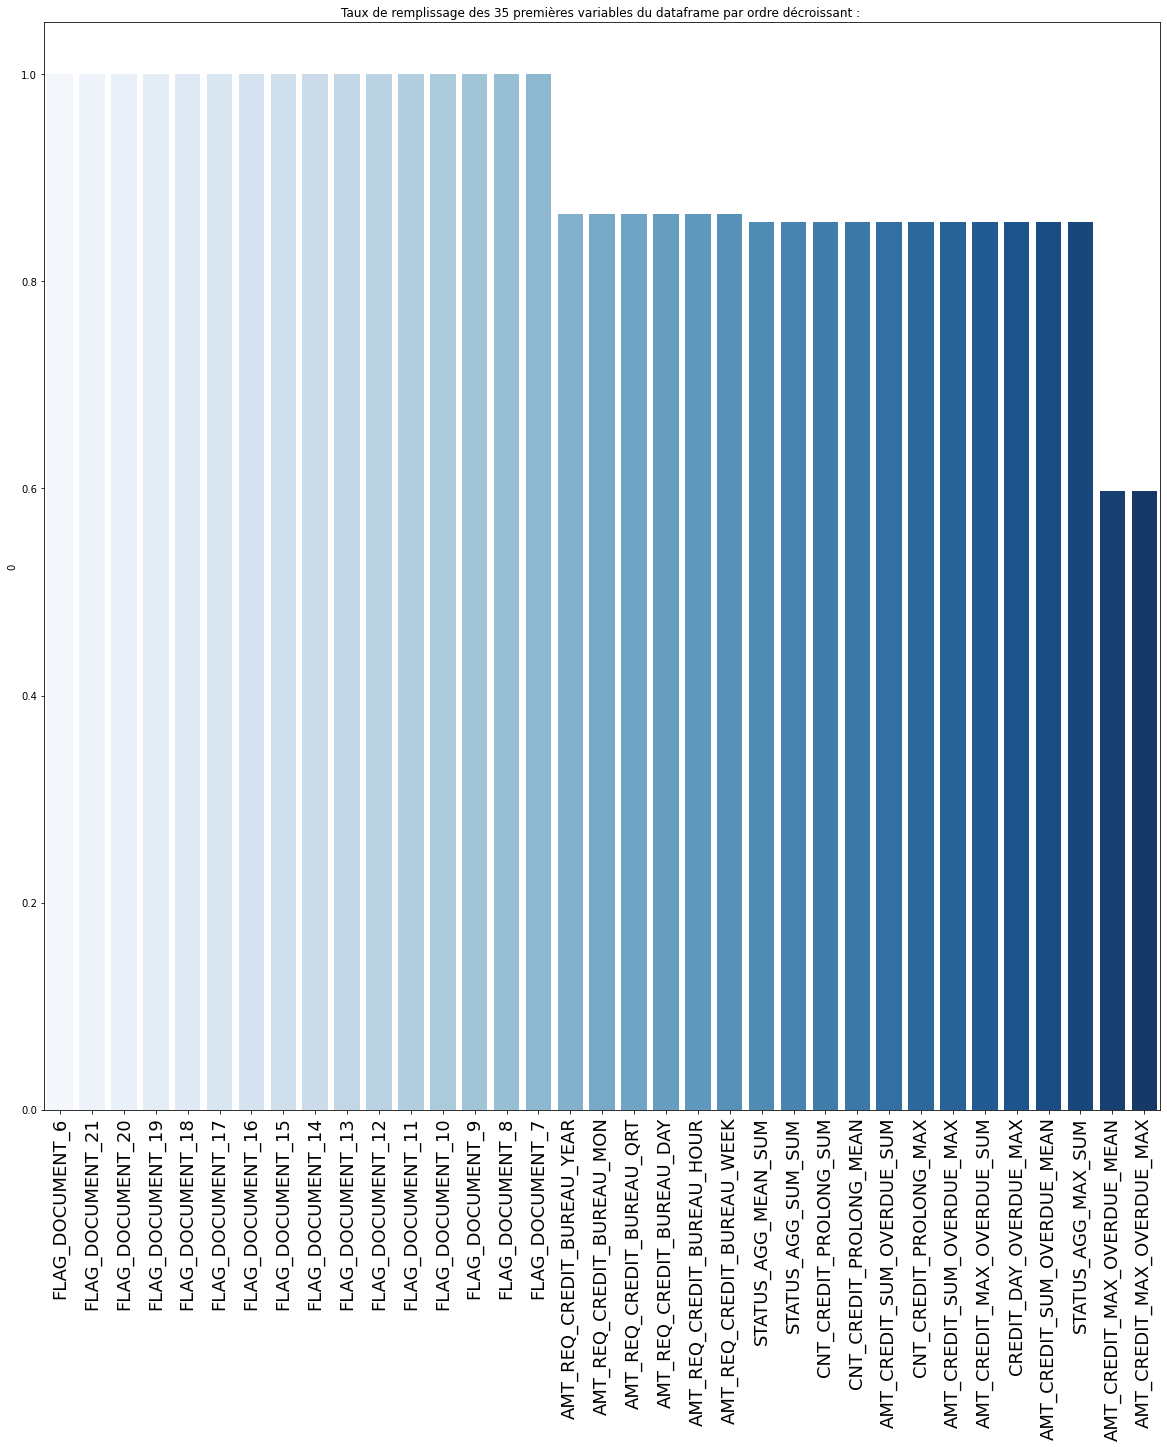

In [29]:
basic_info(trainfile.iloc[:,100:])

## Feature engineering Partie 2 : Fichiers liés aux demandes de crédit précédentes et aggrégation des données de comportements bancaires

### Dataset Credit Card Balance : 

In [30]:
def cc_agg(df) : 
    CC_DPD_SUM=df.groupby('SK_ID_CURR').sum().loc[:,['SK_DPD','SK_DPD_DEF']].rename(columns={
        'SK_DPD':'CC_DPD_SUM','SK_DPD_DEF':'CC_DPD_DEF_SUM'})
    CC_DPD_MAX=df.groupby('SK_ID_CURR').max().loc[:,['SK_DPD','SK_DPD_DEF']].rename(columns={
        'SK_DPD':'CC_DPD_MAX','SK_DPD_DEF':'CC_DPD_DEF_MAX'})
    CC_DPD_MEAN=df.groupby('SK_ID_CURR').mean().loc[:,['SK_DPD','SK_DPD_DEF']].rename(columns={
        'SK_DPD':'CC_DPD_MEAN','SK_DPD_DEF':'CC_DPD_DEF_MEAN'})
    cc_ag=pd.concat([CC_DPD_MEAN,CC_DPD_SUM,CC_DPD_MAX], axis=1)
    return cc_ag
cc_agg(credit)

CC_DPD_MEAN  CC_DPD_DEF_MEAN  CC_DPD_SUM  CC_DPD_DEF_SUM  \
SK_ID_CURR                                                             
100006         0.000000         0.000000           0               0   
100011         0.000000         0.000000           0               0   
100013         0.010417         0.010417           1               1   
100021         0.000000         0.000000           0               0   
100023         0.000000         0.000000           0               0   
...                 ...              ...         ...             ...   
456244         0.000000         0.000000           0               0   
456246         0.000000         0.000000           0               0   
456247         0.031579         0.021053           3               2   
456248         0.000000         0.000000           0               0   
456250         0.000000         0.000000           0               0   

            CC_DPD_MAX  CC_DPD_DEF_MAX  
SK_ID_CURR                              
100006               0               0  
100011               0               0  
100013               1               1  
100021               0               0  
100023               0               0  
...                ...             ...  
456244               0               0  
456246               0               0  
456247               1               1  
456248               0               0  
456250               0               0  

[103558 rows x 6 columns]

In [31]:
credit_agg=cc_agg(credit)
trainfile=trainfile.join(credit_agg, on='SK_ID_CURR')

### Dataset Pos_Cash_Balance : 

In [32]:
cash_df.describe()

SK_ID_PREV    SK_ID_CURR  MONTHS_BALANCE  CNT_INSTALMENT  \
count  1.000136e+07  1.000136e+07    1.000136e+07    9.975287e+06   
mean   1.903217e+06  2.784039e+05   -3.501259e+01    1.708964e+01   
std    5.358465e+05  1.027637e+05    2.606657e+01    1.199506e+01   
min    1.000001e+06  1.000010e+05   -9.600000e+01    1.000000e+00   
25%    1.434405e+06  1.895500e+05   -5.400000e+01    1.000000e+01   
50%    1.896565e+06  2.786540e+05   -2.800000e+01    1.200000e+01   
75%    2.368963e+06  3.674290e+05   -1.300000e+01    2.400000e+01   
max    2.843499e+06  4.562550e+05   -1.000000e+00    9.200000e+01   

       CNT_INSTALMENT_FUTURE        SK_DPD    SK_DPD_DEF  
count           9.975271e+06  1.000136e+07  1.000136e+07  
mean            1.048384e+01  1.160693e+01  6.544684e-01  
std             1.110906e+01  1.327140e+02  3.276249e+01  
min             0.000000e+00  0.000000e+00  0.000000e+00  
25%             3.000000e+00  0.000000e+00  0.000000e+00  
50%             7.000000e+00  0.000000e+00  0.000000e+00  
75%             1.400000e+01  0.000000e+00  0.000000e+00  
max             8.500000e+01  4.231000e+03  3.595000e+03

In [33]:
def poscash_agg(df) : 
    POSCASH_DPD_SUM=df.groupby('SK_ID_CURR').sum().loc[:,['SK_DPD','SK_DPD_DEF']].rename(columns={
        'SK_DPD':'PC_DPD_SUM','SK_DPD_DEF':'PC_DPD_DEF_SUM'})
    POSCASH_DPD_MAX=df.groupby('SK_ID_CURR').max().loc[:,['SK_DPD','SK_DPD_DEF']].rename(columns={
        'SK_DPD':'PC_DPD_MAX','SK_DPD_DEF':'PC_DPD_DEF_MAX'})
    POSCASH_DPD_MEAN=df.groupby('SK_ID_CURR').mean().loc[:,['SK_DPD','SK_DPD_DEF']].rename(columns={
        'SK_DPD':'PC_DPD_MEAN','SK_DPD_DEF':'PC_DPD_DEF_MEAN'})
    poscash_agg=pd.concat([POSCASH_DPD_MEAN,POSCASH_DPD_SUM,POSCASH_DPD_MAX], axis=1)
    return poscash_agg
poscash_agg(cash_df)


PC_DPD_MEAN  PC_DPD_DEF_MEAN  PC_DPD_SUM  PC_DPD_DEF_SUM  \
SK_ID_CURR                                                             
100001         0.777778         0.777778           7               7   
100002         0.000000         0.000000           0               0   
100003         0.000000         0.000000           0               0   
100004         0.000000         0.000000           0               0   
100005         0.000000         0.000000           0               0   
...                 ...              ...         ...             ...   
456251         0.000000         0.000000           0               0   
456252         0.000000         0.000000           0               0   
456253         0.294118         0.294118           5               5   
456254         0.000000         0.000000           0               0   
456255         0.070423         0.070423           5               5   

            PC_DPD_MAX  PC_DPD_DEF_MAX  
SK_ID_CURR                              
100001               7               7  
100002               0               0  
100003               0               0  
100004               0               0  
100005               0               0  
...                ...             ...  
456251               0               0  
456252               0               0  
456253               5               5  
456254               0               0  
456255               5               5  

[337252 rows x 6 columns]

In [34]:
tab=poscash_agg(cash_df)
trainfile=trainfile.join(tab, on='SK_ID_CURR')

### Dataset Instalments Payments : 

In [35]:
def feat_eng(payments_df) : 
    #Calcul de l'écart entre date due et paiement réel
    payments_df['PAYMENT_DELAY']=payments_df['DAYS_ENTRY_PAYMENT']-payments_df['DAYS_INSTALMENT']
    #Séparation en 2 colonnes positives pour permettre d'appliquer correctement les fonctions d'aggrégation : 
    payments_df['PAYMENT_AHEAD']=payments_df['PAYMENT_DELAY'].apply(lambda x: -x if x < 0 else 0)
    payments_df['PAYMENT_DELAY']=payments_df['PAYMENT_DELAY'].apply(lambda x: x if x > 0 else 0)
    # Même chose avec les écarts monétaires : 
    payments_df['PAYMENT_MONEYSHIFT']=payments_df['AMT_PAYMENT']-payments_df['AMT_INSTALMENT']
    payments_df['PAYMENT_MONEYSHIFT_NEG']=payments_df['PAYMENT_MONEYSHIFT'].apply(lambda x: -x if x < 0 else 0)
    payments_df['PAYMENT_MONEYSHIFT_POS']=payments_df['PAYMENT_MONEYSHIFT'].apply(lambda x: x if x > 0 else 0)
    payments_df=payments_df.drop(columns=['PAYMENT_MONEYSHIFT'])
    return payments_df

In [36]:
payments_df=feat_eng(payments_df)
payments_df.head(20)

SK_ID_PREV  SK_ID_CURR  NUM_INSTALMENT_VERSION  NUM_INSTALMENT_NUMBER  \
0      1054186      161674                     1.0                      6   
1      1330831      151639                     0.0                     34   
2      2085231      193053                     2.0                      1   
3      2452527      199697                     1.0                      3   
4      2714724      167756                     1.0                      2   
5      1137312      164489                     1.0                     12   
6      2234264      184693                     4.0                     11   
7      1818599      111420                     2.0                      4   
8      2723183      112102                     0.0                     14   
9      1413990      109741                     1.0                      4   
10     1782554      106597                     1.0                      3   
11     2558880      154793                     1.0                      8   
12     1570206      147645                     0.0                     20   
13     1723268      197273                     1.0                     14   
14     1594684      100193                     0.0                     56   
15     1456258      118323                     1.0                      6   
16     1053286      170192                     1.0                      7   
17     1410565      197687                     1.0                      1   
18     2391610      183431                     0.0                     20   
19     2329072      183463                     1.0                     11   

    DAYS_INSTALMENT  DAYS_ENTRY_PAYMENT  AMT_INSTALMENT   AMT_PAYMENT  \
0           -1180.0             -1187.0     6948.359863   6948.359863   
1           -2156.0             -2156.0     1716.525024   1716.525024   
2             -63.0               -63.0    25425.000000  25425.000000   
3           -2418.0             -2426.0    24350.130859  24350.130859   
4           -1383.0             -1366.0     2165.040039   2160.584961   
5           -1384.0             -1417.0     5970.375000   5970.375000   
6            -349.0              -352.0    29432.294922  29432.294922   
7            -968.0              -994.0    17862.164062  17862.164062   
8            -197.0              -197.0       70.739998     70.739998   
9            -570.0              -609.0    14308.469727  14308.469727   
10           -933.0              -937.0    34620.523438  34620.523438   
11          -1262.0             -1269.0    15031.080078  15031.080078   
12           -761.0              -761.0       21.510000     21.510000   
13           -755.0              -800.0     6093.990234   6093.990234   
14          -1153.0             -1153.0      301.859985    301.859985   
15          -2619.0             -2619.0     4844.924805   4844.924805   
16           -500.0              -503.0     6882.839844   6882.839844   
17          -1037.0             -1048.0    12514.049805  12510.450195   
18          -1680.0             -1693.0     7875.000000   7875.000000   
19          -1699.0             -1693.0     7283.294922   7283.294922   

    PAYMENT_DELAY  PAYMENT_AHEAD  PAYMENT_MONEYSHIFT_NEG  \
0             0.0            7.0                0.000000   
1             0.0            0.0                0.000000   
2             0.0            0.0                0.000000   
3             0.0            8.0                0.000000   
4            17.0            0.0                4.455078   
5             0.0           33.0                0.000000   
6             0.0            3.0                0.000000   
7             0.0           26.0                0.000000   
8             0.0            0.0                0.000000   
9             0.0           39.0                0.000000   
10            0.0            4.0                0.000000   
11            0.0            7.0                0.000000   
12            0.0            0.0                0.000000   
13          

In [37]:
payments_df=payments_df.drop(columns=['DAYS_INSTALMENT','DAYS_ENTRY_PAYMENT','AMT_INSTALMENT','AMT_PAYMENT'])


Dimensions du dataframe : (13605401, 8)
Types de données contenues:
float64    4
int32      3
float32    1
dtype: int64
Taux de remplissage des 8 premières variables par ordre décroissant : 
                          0
SK_ID_PREV              1.0
SK_ID_CURR              1.0
NUM_INSTALMENT_VERSION  1.0
NUM_INSTALMENT_NUMBER   1.0
PAYMENT_DELAY           1.0
PAYMENT_AHEAD           1.0
PAYMENT_MONEYSHIFT_NEG  1.0
PAYMENT_MONEYSHIFT_POS  1.0


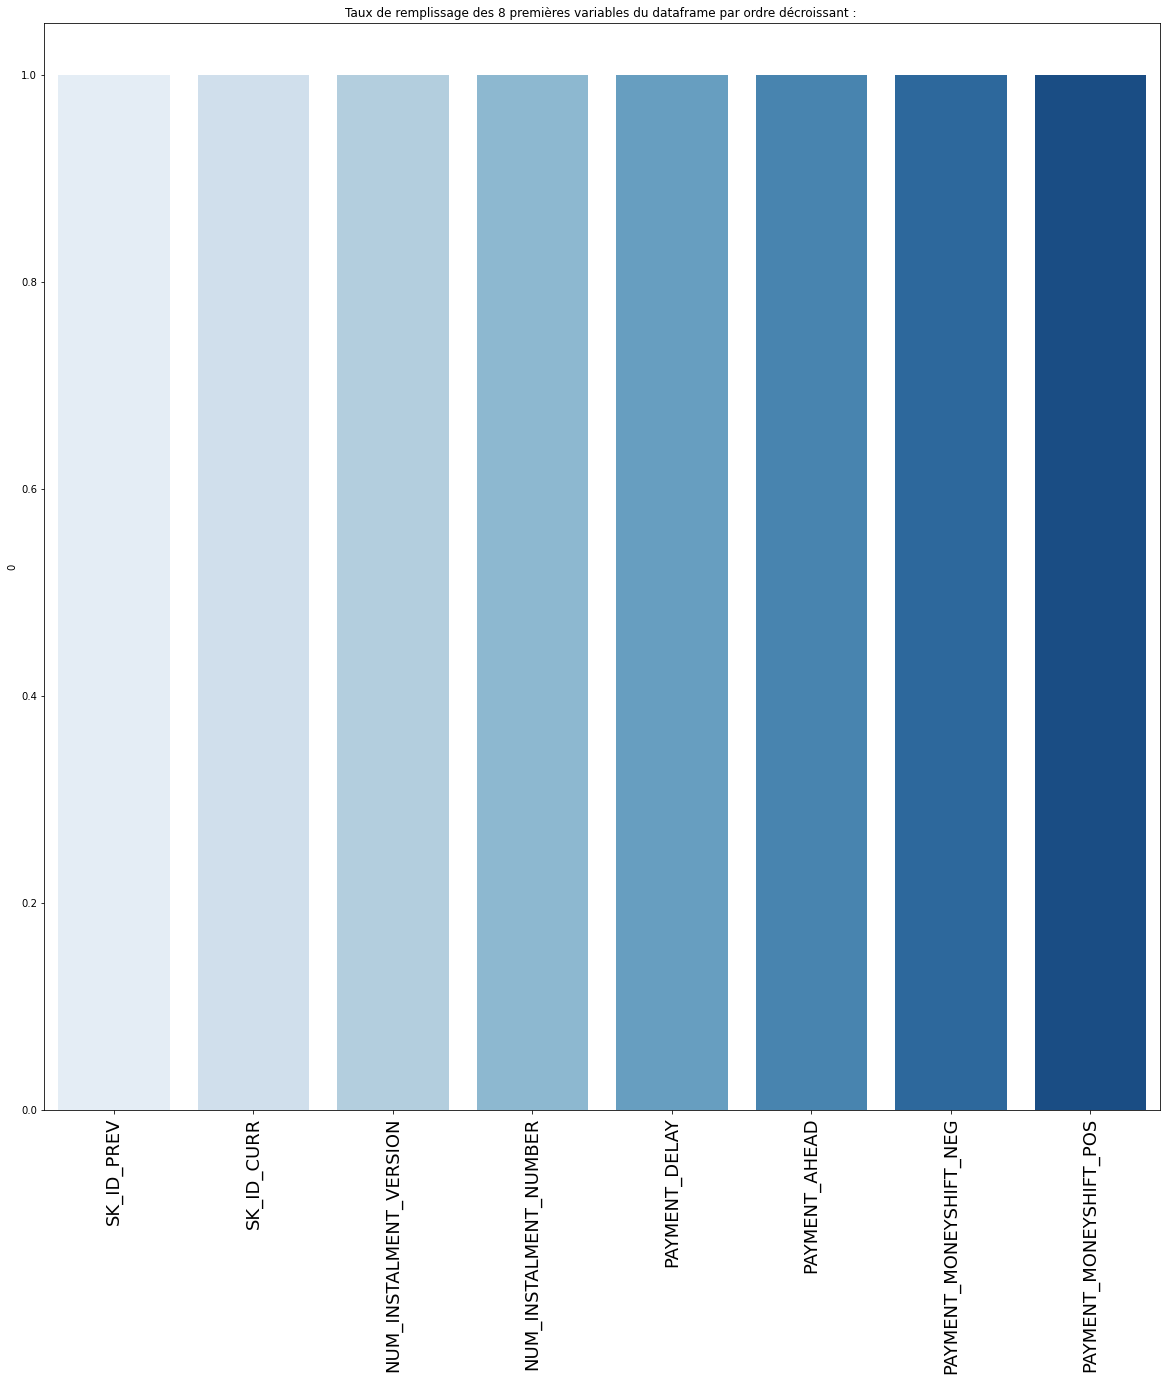

In [38]:
basic_info(payments_df)

In [39]:
def aggreg_payments(df, direct=True) : 
    
    aggreg_dict={
        'NUM_INSTALMENT_VERSION': ['max'],
        'PAYMENT_DELAY': ['max', 'mean', 'sum'],
        'PAYMENT_AHEAD': ['max', 'mean', 'sum'],
        'PAYMENT_MONEYSHIFT_NEG': ['max', 'mean', 'sum'],
        'PAYMENT_MONEYSHIFT_POS': ['max', 'mean', 'sum']
    }

    if direct==True : 
        tab=df.drop(columns=['SK_ID_PREV','NUM_INSTALMENT_NUMBER']).groupby('SK_ID_CURR').agg(aggreg_dict)
    else : 
        tab=df.drop(columns=['SK_ID_CURR','NUM_INSTALMENT_NUMBER']).groupby('SK_ID_PREV').agg(aggreg_dict)
    tab.columns = pd.Index([e[0] + "_" + e[1].upper() for e in tab.columns.tolist()])
    return tab

payments_agg_indirect=aggreg_payments(payments_df,direct=False)
agg_payments=aggreg_payments(payments_df)
agg_payments

NUM_INSTALMENT_VERSION_MAX  PAYMENT_DELAY_MAX  PAYMENT_DELAY_MEAN  \
SK_ID_CURR                                                                      
100001                             2.0               11.0            1.571429   
100002                             2.0                0.0            0.000000   
100003                             2.0                0.0            0.000000   
100004                             2.0                0.0            0.000000   
100005                             2.0                1.0            0.111111   
...                                ...                ...                 ...   
456251                             2.0                0.0            0.000000   
456252                             1.0                3.0            0.500000   
456253                             1.0                9.0            0.642857   
456254                             1.0                0.0            0.000000   
456255                             4.0                7.0            0.702703   

            PAYMENT_DELAY_SUM  PAYMENT_AHEAD_MAX  PAYMENT_AHEAD_MEAN  \
SK_ID_CURR                                                             
100001                   11.0               36.0            8.857143   
100002                    0.0               31.0           20.421053   
100003                    0.0               14.0            7.160000   
100004                    0.0               11.0            7.666667   
100005                    1.0               37.0           23.666667   
...                       ...                ...                 ...   
456251                    0.0               46.0           36.285714   
456252                    3.0               11.0            3.333333   
456253                    9.0               51.0           15.142857   
456254                    0.0               31.0           19.000000   
456255                   52.0               35.0            8.770270   

            PAYMENT_AHEAD_SUM  PAYMENT_MONEYSHIFT_NEG_MAX  \
SK_ID_CURR                                                  
100001                   62.0                    0.000000   
100002                  388.0                    0.000000   
100003                  179.0                    0.000000   
100004                   23.0                    0.000000   
100005                  213.0                    0.000000   
...                       ...                         ...   
456251                  254.0                    0.000000   
456252                   20.0                    0.000000   
456253                  212.0                 3945.824951   
456254                  361.0                    0.000000   
456255                  649.0                28641.150391   

            PAYMENT_MONEYSHIFT_NEG_MEAN  PAYMENT_MONEYSHIFT_NEG_SUM  \
SK_ID_CURR                                                            
100001                         0.000000                    0.000000   
100002                         0.000000                    0.000000   
100003                         0.000000                    0.000000   
100004                         0.000000                    0.000000   
100005                         0.000000                    0.000000   
...                                 ...                         ...   
456251                         0.000000                    0.000000   
456252                         0.000000                    0.000000   
456253                       283.792498                 3973.094971   
456254                         0.000000                    0.000000   
456255                      2862.438938               211820.481445   

            PAYMENT_MONEYSHIFT_POS_MAX  PAYMENT_MONEYSHIFT_POS_MEAN  \
SK_ID_CURR                                                            
100001                             0.0                     0.000000   
100002                             0.0                     0.000000   
100003             

### Dataset demandes précédentes : 

On aggrège d'abord les valeurs issues du tableau "enfant" : 

In [40]:
previous_df=previous_df.join(payments_agg_indirect, on='SK_ID_PREV')

In [41]:
previous_df.describe()

SK_ID_PREV    SK_ID_CURR   AMT_ANNUITY  AMT_APPLICATION  \
count  1.670214e+06  1.670214e+06  1.297979e+06     1.670214e+06   
mean   1.923089e+06  2.783572e+05  1.595512e+04     1.752339e+05   
std    5.325980e+05  1.028148e+05  1.478214e+04     2.927798e+05   
min    1.000001e+06  1.000010e+05  0.000000e+00     0.000000e+00   
25%    1.461857e+06  1.893290e+05  6.321780e+03     1.872000e+04   
50%    1.923110e+06  2.787145e+05  1.125000e+04     7.104600e+04   
75%    2.384280e+06  3.675140e+05  2.065842e+04     1.803600e+05   
max    2.845382e+06  4.562550e+05  4.180582e+05     6.905160e+06   

         AMT_CREDIT  AMT_DOWN_PAYMENT  AMT_GOODS_PRICE  \
count  1.670213e+06      7.743700e+05     1.284699e+06   
mean   1.961140e+05      6.697401e+03     2.278472e+05   
std    3.185746e+05      2.092150e+04     3.153966e+05   
min    0.000000e+00     -9.000000e-01     0.000000e+00   
25%    2.416050e+04      0.000000e+00     5.084100e+04   
50%    8.054100e+04      1.638000e+03     1.123200e+05   
75%    2.164185e+05      7.740000e+03     2.340000e+05   
max    6.905160e+06      3.060045e+06     6.905160e+06   

       HOUR_APPR_PROCESS_START  NFLAG_LAST_APPL_IN_DAY  RATE_DOWN_PAYMENT  \
count             1.670214e+06            1.670214e+06      774370.000000   
mean              1.248418e+01            9.964675e-01           0.079637   
std               3.334028e+00            5.932963e-02           0.107823   
min               0.000000e+00            0.000000e+00          -0.000015   
25%               1.000000e+01            1.000000e+00           0.000000   
50%               1.200000e+01            1.000000e+00           0.051605   
75%               1.500000e+01            1.000000e+00           0.108909   
max               2.300000e+01            1.000000e+00           1.000000   

       ...  PAYMENT_DELAY_SUM  PAYMENT_AHEAD_MAX  PAYMENT_AHEAD_MEAN  \
count  ...      958905.000000      958905.000000       958905.000000   
mean   ...          12.257134          26.532066           12.674958   
std    ...         155.797682          21.619691           11.214142   
min    ...           0.000000           0.000000            0.000000   
25%    ...           0.000000          14.000000            5.800000   
50%    ...           0.000000          22.000000           10.000000   
75%    ...           2.000000          32.000000           16.250000   
max    ...       82954.000000        3189.000000         1600.000000   

       PAYMENT_AHEAD_SUM  PAYMENT_MONEYSHIFT_NEG_MAX  \
count      958905.000000                9.589050e+05   
mean          133.399067                3.160039e+03   
std           156.247597                1.010108e+04   
min             0.000000                0.000000e+00   
25%            50.000000                0.000000e+00   
50%            94.000000                0.000000e+00   
75%           164.000000                0.000000e+00   
max         10529.000000                2.424726e+06   

       PAYMENT_MONEYSHIFT_NEG_MEAN  PAYMENT_MONEYSHIFT_NEG_SUM  \
count                958905.000000                9.589050e+05   
mean                    549.755217                1.004311e+04   
std                    2047.179040                4.123714e+04   
min                       0.000000                0.000000e+00   
25%                       0.000000                0.000000e+00   
50%                       0.000000                0.000000e+00   
75%                       0.000000                0.000000e+00   
max                  447126.375000                2.602349e+06   

       PAYMENT_MONEYSHIFT_POS_MAX  PAYMENT_MONEYSHIFT_POS_MEAN  \
count                9.589050e+05                958905.000000   
mean                 9.011615e+03                  1221.994355   
std                  6.707888e+04                  9822.011009   
min                  0.000000e+00                     0.000000   
25%                  0.000000e+00                     0.000000   
50%                  0.000000e+00 

In [42]:
len(previous_df[previous_df.SK_ID_CURR.isin(trainfile.SK_ID_CURR.unique())].SK_ID_CURR.unique())

291057

In [43]:
previous_df['AMT_DOWN_PAYMENT']=previous_df['AMT_DOWN_PAYMENT'].fillna(previous_df['AMT_APPLICATION']-previous_df['AMT_GOODS_PRICE'])
previous_df['AMT_DOWN_PAYMENT']=[i if i>0 else 0 for i in previous_df['AMT_DOWN_PAYMENT']]
previous_df['AMT_DOWN_PAYMENT'].describe()

count    1.670214e+06
mean     3.113975e+03
std      1.472749e+04
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      3.060045e+06
Name: AMT_DOWN_PAYMENT, dtype: float64


Dimensions du dataframe : (1670214, 50)
Types de données contenues:
object     16
float32    15
float64    13
int32       6
dtype: int64
Taux de remplissage des 35 premières variables par ordre croissant : 
                                    0
RATE_INTEREST_PRIVILEGED     0.003563
RATE_INTEREST_PRIMARY        0.003563
RATE_DOWN_PAYMENT            0.463635
NAME_TYPE_SUITE              0.508802
PAYMENT_AHEAD_MEAN           0.574121
NUM_INSTALMENT_VERSION_MAX   0.574121
PAYMENT_DELAY_MAX            0.574121
PAYMENT_DELAY_MEAN           0.574121
PAYMENT_DELAY_SUM            0.574121
PAYMENT_AHEAD_MAX            0.574121
PAYMENT_MONEYSHIFT_POS_SUM   0.574121
PAYMENT_AHEAD_SUM            0.574121
PAYMENT_MONEYSHIFT_NEG_SUM   0.574121
PAYMENT_MONEYSHIFT_NEG_MAX   0.574121
PAYMENT_MONEYSHIFT_POS_MAX   0.574121
PAYMENT_MONEYSHIFT_POS_MEAN  0.574121
PAYMENT_MONEYSHIFT_NEG_MEAN  0.574121
NFLAG_INSURED_ON_APPROVAL    0.597019
DAYS_TERMINATION             0.597019
DAYS_LAST_DUE                0.5

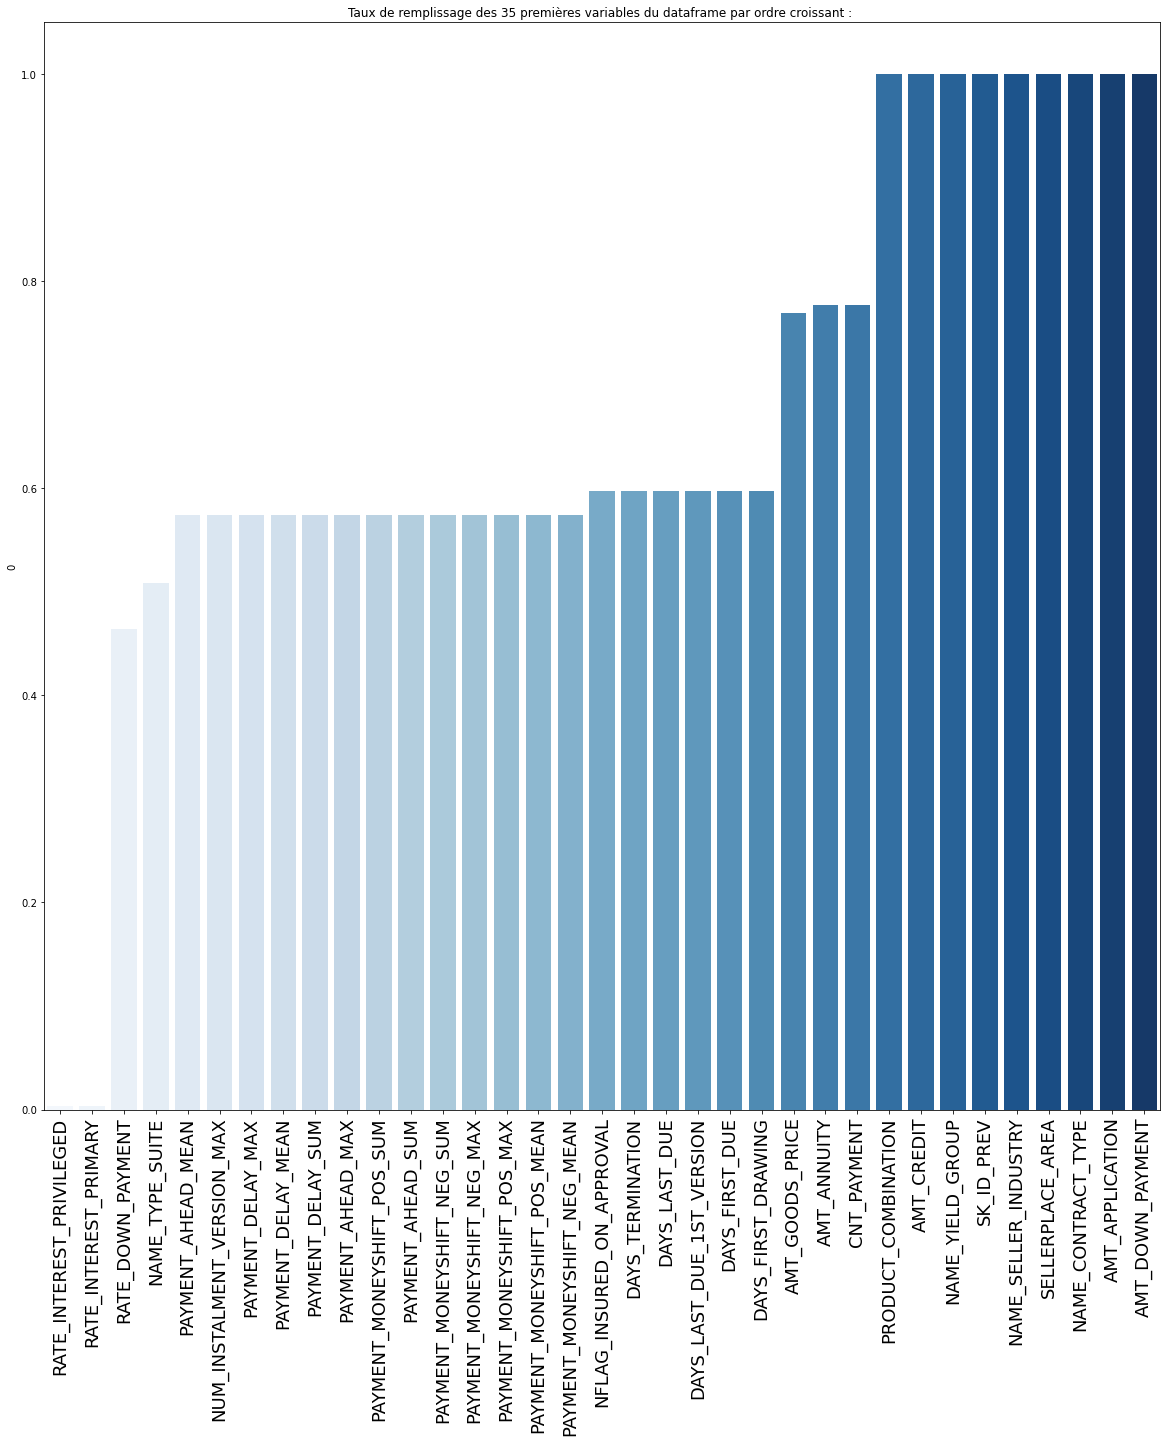

In [44]:
basic_info(previous_df, decr=False)

In [45]:
previous_df.select_dtypes(include='O').describe()

NAME_CONTRACT_TYPE WEEKDAY_APPR_PROCESS_START  \
count             1670214                    1670214   
unique                  4                          7   
top            Cash loans                    TUESDAY   
freq               747553                     255118   

       FLAG_LAST_APPL_PER_CONTRACT NAME_CASH_LOAN_PURPOSE  \
count                      1670214                1670214   
unique                           2                     25   
top                              Y                    XAP   
freq                       1661739                 922661   

       NAME_CONTRACT_STATUS      NAME_PAYMENT_TYPE CODE_REJECT_REASON  \
count               1670214                1670214            1670214   
unique                    4                      4                  9   
top                Approved  Cash through the bank                XAP   
freq                1036781                1033552            1353093   

       NAME_TYPE_SUITE NAME_CLIENT_TYPE NAME_GOODS_CATEGORY NAME_PORTFOLIO  \
count           849809          1670214             1670214        1670214   
unique               7                4                  28              5   
top      Unaccompanied         Repeater                 XNA            POS   
freq            508970          1231261              950809         691011   

       NAME_PRODUCT_TYPE             CHANNEL_TYPE NAME_SELLER_INDUSTRY  \
count            1670214                  1670214              1670214   
unique                 3                        8                   11   
top                  XNA  Credit and cash offices                  XNA   
freq             1063666                   719968               855720   

       NAME_YIELD_GROUP PRODUCT_COMBINATION  
count           1670214             1669868  
unique                5                  17  
top                 XNA                Cash  
freq             517215              285990

On va se débarasser des colonnes catégoriques ou XNA ou XAP sont en majorité absolue : 

In [46]:
previous_df=previous_df[previous_df.NAME_CONTRACT_STATUS=='Approved']
previous_df=previous_df.drop(columns='NAME_CONTRACT_STATUS')

In [47]:
def filtrage_na_cat (df, thres=0.5,na_values=['XAP','XNA']): 
    mask1=df.select_dtypes(include='O').mode().isin(na_values).values[0]
    mask2=df.select_dtypes(include='O').describe().iloc[3,:].values>(thres*df.shape[0])
    mask=mask1&mask2    
    return df.drop(columns=df.select_dtypes(include='O').columns[mask])

previous_df=filtrage_na_cat(previous_df)

In [48]:
previous_df=previous_df[previous_df.NAME_CONTRACT_TYPE!='Consumer_loans']
def binary_encode(df) : 
    tab=df.copy(deep=True)
    mask=[df[col].unique().shape[0]<=3 for col in df.select_dtypes(include='O').columns]
    col=df.select_dtypes(include='O').columns[mask]
    for i in col : 
        tab=tab.replace({i:{'N':0,'No':0,'no':0,'Y':1,'Yes':1,'yes':1,'M':1,'F':0,'Cash loans':1,'Revolving loans':0,'XNA':np.nan}})
        tab[i]=tab[i].astype('bool')
    return tab

previous_df=binary_encode(previous_df)

In [49]:
def one_hot_encode(df) : 
    transformed={}
    for col in df.select_dtypes(include='O').columns : 
        print(f'{col:-<50}{df[col].unique()}')
        transformed[(col+'_onehot_')]=pd.get_dummies(df[col])
    df=df.drop(columns=df.select_dtypes(include='O').columns, axis=1)
    trans_df=pd.DataFrame()
    co=[]
    for key in transformed :      
        val=transformed[key].columns.tolist()
        [co.append(key+i) for i in val]
        trans_df=pd.concat([trans_df,transformed[key]],axis=1)
    trans_df.columns=pd.Index(co)
    df=pd.concat([df, trans_df], axis=1)
    return df

previous_df=one_hot_encode(previous_df)

WEEKDAY_APPR_PROCESS_START------------------------['SATURDAY' 'THURSDAY' 'TUESDAY' 'MONDAY' 'FRIDAY' 'SUNDAY' 'WEDNESDAY']
NAME_PAYMENT_TYPE---------------------------------['Cash through the bank' 'XNA' 'Non-cash from your account'
 'Cashless from the account of the employer']
NAME_TYPE_SUITE-----------------------------------[nan 'Unaccompanied' 'Spouse, partner' 'Family' 'Children' 'Other_B'
 'Other_A' 'Group of people']
NAME_CLIENT_TYPE----------------------------------['Repeater' 'New' 'Refreshed' 'XNA']
NAME_GOODS_CATEGORY-------------------------------['Mobile' 'XNA' 'Consumer Electronics' 'Construction Materials'
 'Auto Accessories' 'Photo / Cinema Equipment' 'Computers' 'Audio/Video'
 'Medicine' 'Clothing and Accessories' 'Furniture' 'Sport and Leisure'
 'Homewares' 'Gardening' 'Jewelry' 'Vehicles' 'Education'
 'Medical Supplies' 'Other' 'Direct Sales' 'Office Appliances' 'Fitness'
 'Tourism' 'Insurance' 'Additional Service' 'Weapon' 'Animals']
NAME_PORTFOLIO------------------

In [50]:
previous_df

SK_ID_PREV  SK_ID_CURR  NAME_CONTRACT_TYPE   AMT_ANNUITY  \
0           2030495      271877                True   1730.430054   
1           2802425      108129                True  25188.615234   
2           2523466      122040                True  15060.735352   
3           2819243      176158                True  47041.335938   
5           1383531      199383                True  23703.929688   
...             ...         ...                 ...           ...   
1670209     2300464      352015                True  14704.290039   
1670210     2357031      334635                True   6622.020020   
1670211     2659632      249544                True  11520.855469   
1670212     2785582      400317                True  18821.519531   
1670213     2418762      261212                True  16431.300781   

         AMT_APPLICATION  AMT_CREDIT  AMT_DOWN_PAYMENT  AMT_GOODS_PRICE  \
0                17145.0     17145.0               0.0          17145.0   
1               607500.0    679671.0               0.0         607500.0   
2               112500.0    136444.5               0.0         112500.0   
3               450000.0    470790.0               0.0         450000.0   
5               315000.0    340573.5               0.0         315000.0   
...                  ...         ...               ...              ...   
1670209         267295.5    311400.0               0.0         267295.5   
1670210          87750.0     64291.5           29250.0          87750.0   
1670211         105237.0    102523.5           10525.5         105237.0   
1670212         180000.0    191880.0               0.0         180000.0   
1670213         360000.0    360000.0               0.0         360000.0   

         HOUR_APPR_PROCESS_START  FLAG_LAST_APPL_PER_CONTRACT  ...  \
0                             15                         True  ...   
1                             11                         True  ...   
2                             11                         True  ...   
3                              7                         True  ...   
5                              8                         True  ...   
...                          ...                          ...  ...   
1670209                       12                         True  ...   
1670210                       15                         True  ...   
1670211                       12                         True  ...   
1670212                        9                         True  ...   
1670213                       10                         True  ...   

         PRODUCT_COMBINATION_onehot_Cash X-Sell: low  \
0                                                  0   
1                                                  1   
2                                                  0   
3                                                  0   
5                                                  1   
...                                              ...   
1670209                                            0   
1670210                                            0   
1670211                                            0   
1670212                                            1   
1670213                                            0   

         PRODUCT_COMBINATION_onehot_Cash X-Sell: middle  \
0                                                     0   
1                                                     0   
2                                                     0   
3                                                     1   
5                                                     0   
...                                                 ...   
1670209                                               0   
1670210                                               0   
1670211                                               0   
1670212                                               0   
1670213                                               1   

         PRODUCT_COMBINATION_onehot_POS household with i

In [51]:
previous_df[previous_df.columns[previous_df.columns.str.contains('DAYS')]]=previous_df[previous_df.columns[previous_df.columns.str.contains('DAYS')]].replace(365243,np.nan)
#previous_df=previous_df.replace('XNA',np.nan)


def aggreg_prev(df) : 
    tab=df.drop(columns=['SK_ID_PREV'])
    aggreg_dico={}
    listagg=['min','max', 'mean', 'sum']
    for col in tab.columns : 
        aggreg_dico[col]=listagg
    inter_agg=tab.groupby('SK_ID_CURR').agg(aggreg_dico)
    inter_agg.columns = pd.Index([e[0] + "_" + e[1].upper() for e in inter_agg.columns.tolist()])
    return inter_agg.drop(columns=inter_agg.columns[inter_agg.columns.str.contains('SK_ID_CURR')])

agg_previous=aggreg_prev(previous_df)

In [52]:
agg_previous

NAME_CONTRACT_TYPE_MIN  NAME_CONTRACT_TYPE_MAX  \
SK_ID_CURR                                                   
100001                        True                    True   
100002                        True                    True   
100003                        True                    True   
100004                        True                    True   
100005                        True                    True   
...                            ...                     ...   
456251                        True                    True   
456252                        True                    True   
456253                        True                    True   
456254                        True                    True   
456255                        True                    True   

            NAME_CONTRACT_TYPE_MEAN  NAME_CONTRACT_TYPE_SUM  AMT_ANNUITY_MIN  \
SK_ID_CURR                                                                     
100001                          1.0                       1      3951.000000   
100002                          1.0                       1      9251.775391   
100003                          1.0                       3      6737.310059   
100004                          1.0                       1      5357.250000   
100005                          1.0                       1      4813.200195   
...                             ...                     ...              ...   
456251                          1.0                       1      6605.910156   
456252                          1.0                       1     10074.464844   
456253                          1.0                       2      3973.094971   
456254                          1.0                       2      2296.439941   
456255                          1.0                       6     11090.834961   

            AMT_ANNUITY_MAX  AMT_ANNUITY_MEAN  AMT_ANNUITY_SUM  \
SK_ID_CURR                                                       
100001          3951.000000       3951.000000      3951.000000   
100002          9251.775391       9251.775391      9251.775391   
100003         98356.992188      56553.988281    169661.968750   
100004          5357.250000       5357.250000      5357.250000   
100005          4813.200195       4813.200195      4813.200195   
...                     ...               ...              ...   
456251          6605.910156       6605.910156      6605.910156   
456252         10074.464844      10074.464844     10074.464844   
456253          5567.714844       4770.404785      9540.809570   
456254         19065.824219      10681.131836     21362.263672   
456255         54022.140625      22202.580078    133215.484375   

            AMT_APPLICATION_MIN  AMT_APPLICATION_MAX  ...  \
SK_ID_CURR                                            ...   
100001                  24835.5              24835.5  ...   
100002                 179055.0             179055.0  ...   
100003                  68809.5             900000.0  ...   
100004                  24282.0              24282.0  ...   
100005                  44617.5              44617.5  ...   
...                         ...                  ...  ...   
456251                  40455.0              40455.0  ...   
456252                  57595.5              57595.5  ...   
456253                  19413.0              28912.5  ...   
456254                  18846.0             223789.5  ...   
456255                  58225.5            1170000.0  ...   

            PRODUCT_COMBINATION_onehot_POS mobile without interest_MEAN  \
SK_ID_CURR                                                                
100001                                                    0.0             
100002                                                    0.0             
100003                                                    0.0             
100004                                                    1.0             
100005                                                    0.0

In [53]:
trainfile=trainfile.join(agg_previous, on='SK_ID_CURR')
trainfile=trainfile.join(agg_payments, on='SK_ID_CURR')
trainfile

SK_ID_CURR  TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
0           100002       1         Cash loans           M            N   
1           100003       0         Cash loans           F            N   
2           100004       0    Revolving loans           M            Y   
3           100006       0         Cash loans           F            N   
4           100007       0         Cash loans           M            N   
...            ...     ...                ...         ...          ...   
307506      456251       0         Cash loans           M            N   
307507      456252       0         Cash loans           F            N   
307508      456253       0         Cash loans           F            N   
307509      456254       1         Cash loans           F            N   
307510      456255       0         Cash loans           F            N   

       FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  \
0                    Y             0          202500.0    406597.5   
1                    N             0          270000.0   1293502.5   
2                    Y             0           67500.0    135000.0   
3                    Y             0          135000.0    312682.5   
4                    Y             0          121500.0    513000.0   
...                ...           ...               ...         ...   
307506               N             0          157500.0    254700.0   
307507               Y             0           72000.0    269550.0   
307508               Y             0          153000.0    677664.0   
307509               Y             0          171000.0    370107.0   
307510               N             0          157500.0    675000.0   

        AMT_ANNUITY  ...  PAYMENT_DELAY_SUM PAYMENT_AHEAD_MAX  \
0           24700.5  ...                0.0              31.0   
1           35698.5  ...                0.0              14.0   
2            6750.0  ...                0.0              11.0   
3           29686.5  ...                0.0              77.0   
4           21865.5  ...               63.0              31.0   
...             ...  ...                ...               ...   
307506      27558.0  ...                0.0              46.0   
307507      12001.5  ...                3.0              11.0   
307508      29979.0  ...                9.0              51.0   
307509      20205.0  ...                0.0              31.0   
307510      49117.5  ...               52.0              35.0   

       PAYMENT_AHEAD_MEAN PAYMENT_AHEAD_SUM PAYMENT_MONEYSHIFT_NEG_MAX  \
0               20.421053             388.0                   0.000000   
1                7.160000             179.0                   0.000000   
2                7.666667              23.0                   0.000000   
3               19.375000             310.0                   0.000000   
4                4.590909             303.0               22655.654297   
...                   ...               ...                        ...   
307506          36.285714             254.0                   0.000000   
307507           3.333333              20.0                   0.000000   
307508          15.142857             212.0                3945.824951   
307509          19.000000             361.0                   0.000000   
307510           8.770270             649.0               28641.150391   

       PAYMENT_MONEYSHIFT_NEG_MEAN  PAYMENT_MONEYSHIFT_NEG_SUM  \
0                         0.000000                    0.000000   
1                         0.000000                    0.000000   
2                         0.000000                    0.000000   
3                         0.000000                    0.000000   
4                       452.384322                29857.365234   
...                            ...                         ...   
307506                    0.000000                    0.000000   
307507                    0.000000                    0.000000   
307508        

Le tableau principal est maintenant complété par les variables provenant des tableaux annexes, on va maintenant lui ajouter ses propres variables synthétiques, développées après EDA en parallèle dans un autre notebook et lecture du kernel Kaggle d'introduction : 

In [54]:
trainfile.loc[:,['famcell_partner']]=trainfile.NAME_FAMILY_STATUS.map({'Single / not married':0, 'Married':1,'Civil marriage':1,'Widow':0,'Separated':0})
trainfile.loc[:,['famcell_total']]=trainfile['CNT_CHILDREN'] + trainfile['famcell_partner'] + 1  
trainfile.loc[:,['DP_rate']]=trainfile['AMT_CREDIT']/trainfile['AMT_GOODS_PRICE']
trainfile.loc[:,['DTI_ratio']]=trainfile['AMT_ANNUITY']/trainfile['AMT_INCOME_TOTAL']
trainfile.loc[:,['total_debt_over_income']]=trainfile['AMT_CREDIT']/trainfile['AMT_INCOME_TOTAL']
trainfile.loc[:,['Left_for_a_living']]=trainfile['AMT_INCOME_TOTAL']-trainfile['AMT_ANNUITY']
trainfile.loc[:,['normalized_LFAL']]=trainfile['Left_for_a_living']/trainfile['CNT_FAM_MEMBERS']
trainfile.loc[:,['enlarged_LFAL']]=trainfile['Left_for_a_living']/trainfile['famcell_total']
trainfile.loc[:,['refund_rate']]=trainfile['AMT_ANNUITY']/trainfile['AMT_CREDIT']
trainfile.loc[:,['ML_duration']]=trainfile['AMT_CREDIT']/trainfile['AMT_ANNUITY']

Le tableau principal est maintenant complet, on peut le traiter et créer nos modèles de ML. 

## Comparaison de modèles de machine learning : <br>
Voilà, notre feature engineering est fait...Mais nous allons d'abord comparer nos modèles sur les données du tableau initialement fourni. Il contient les données principales des candidatures et cela devrait nous permettre de choisir 2 modèles qui fonctionnent bien pour les optimiser par la suite. 
On a ajouté ici pas mal de variables : 


Dimensions du dataframe : (307511, 692)
Types de données contenues:
float64    491
float32    139
int32       41
object      21
dtype: int64
Taux de remplissage des 70 premières variables par ordre croissant : 
                                      0
RATE_INTEREST_PRIVILEGED_MIN   0.014988
RATE_INTEREST_PRIVILEGED_MEAN  0.014988
RATE_INTEREST_PRIVILEGED_MAX   0.014988
RATE_INTEREST_PRIMARY_MEAN     0.014988
RATE_INTEREST_PRIMARY_MAX      0.014988
...                                 ...
YEARS_BEGINEXPLUATATION_MEDI   0.512190
YEARS_BEGINEXPLUATATION_MODE   0.512190
YEARS_BEGINEXPLUATATION_AVG    0.512190
TOTALAREA_MODE                 0.517315
EMERGENCYSTATE_MODE            0.526017

[70 rows x 1 columns]


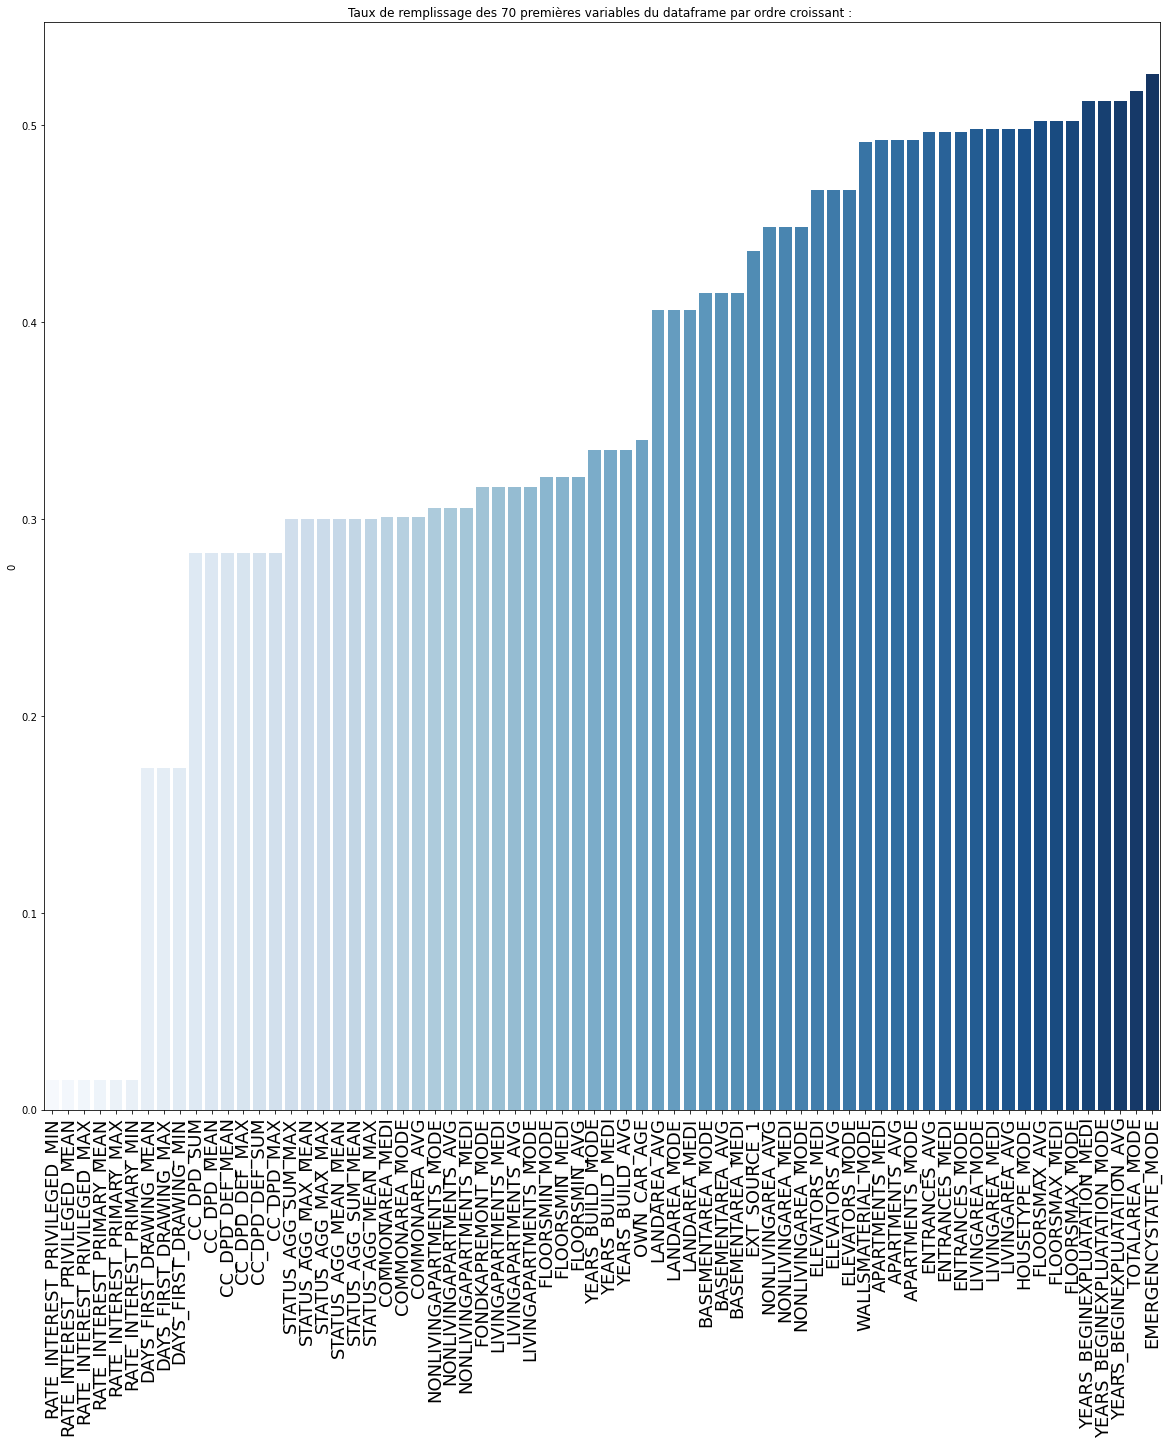

In [55]:
basic_info(trainfile,70,decr=False)

Même si beaucoup d'entre elles ne résistent pas à un filtrage sévère sur le taux de remplissage : 


Dimensions du dataframe : (306488, 620)
Types de données contenues:
float64    480
float32     83
int32       40
object      17
dtype: int64
Taux de remplissage des 35 premières variables par ordre croissant : 
                                       0
EXT_SOURCE_3                    0.801973
DAYS_EMPLOYED                   0.819889
STATUS_AGG_SUM_SUM              0.856960
CNT_CREDIT_PROLONG_MAX          0.856960
CREDIT_DAY_OVERDUE_MAX          0.856960
AMT_CREDIT_MAX_OVERDUE_SUM      0.856960
AMT_CREDIT_SUM_OVERDUE_MAX      0.856960
AMT_CREDIT_SUM_OVERDUE_MEAN     0.856960
STATUS_AGG_MAX_SUM              0.856960
STATUS_AGG_MEAN_SUM             0.856960
AMT_CREDIT_SUM_OVERDUE_SUM      0.856960
CNT_CREDIT_PROLONG_SUM          0.856960
CNT_CREDIT_PROLONG_MEAN         0.856960
AMT_REQ_CREDIT_BUREAU_YEAR      0.865088
AMT_REQ_CREDIT_BUREAU_QRT       0.865088
AMT_REQ_CREDIT_BUREAU_MON       0.865088
AMT_REQ_CREDIT_BUREAU_DAY       0.865088
AMT_REQ_CREDIT_BUREAU_HOUR      0.865088
AMT_REQ_C

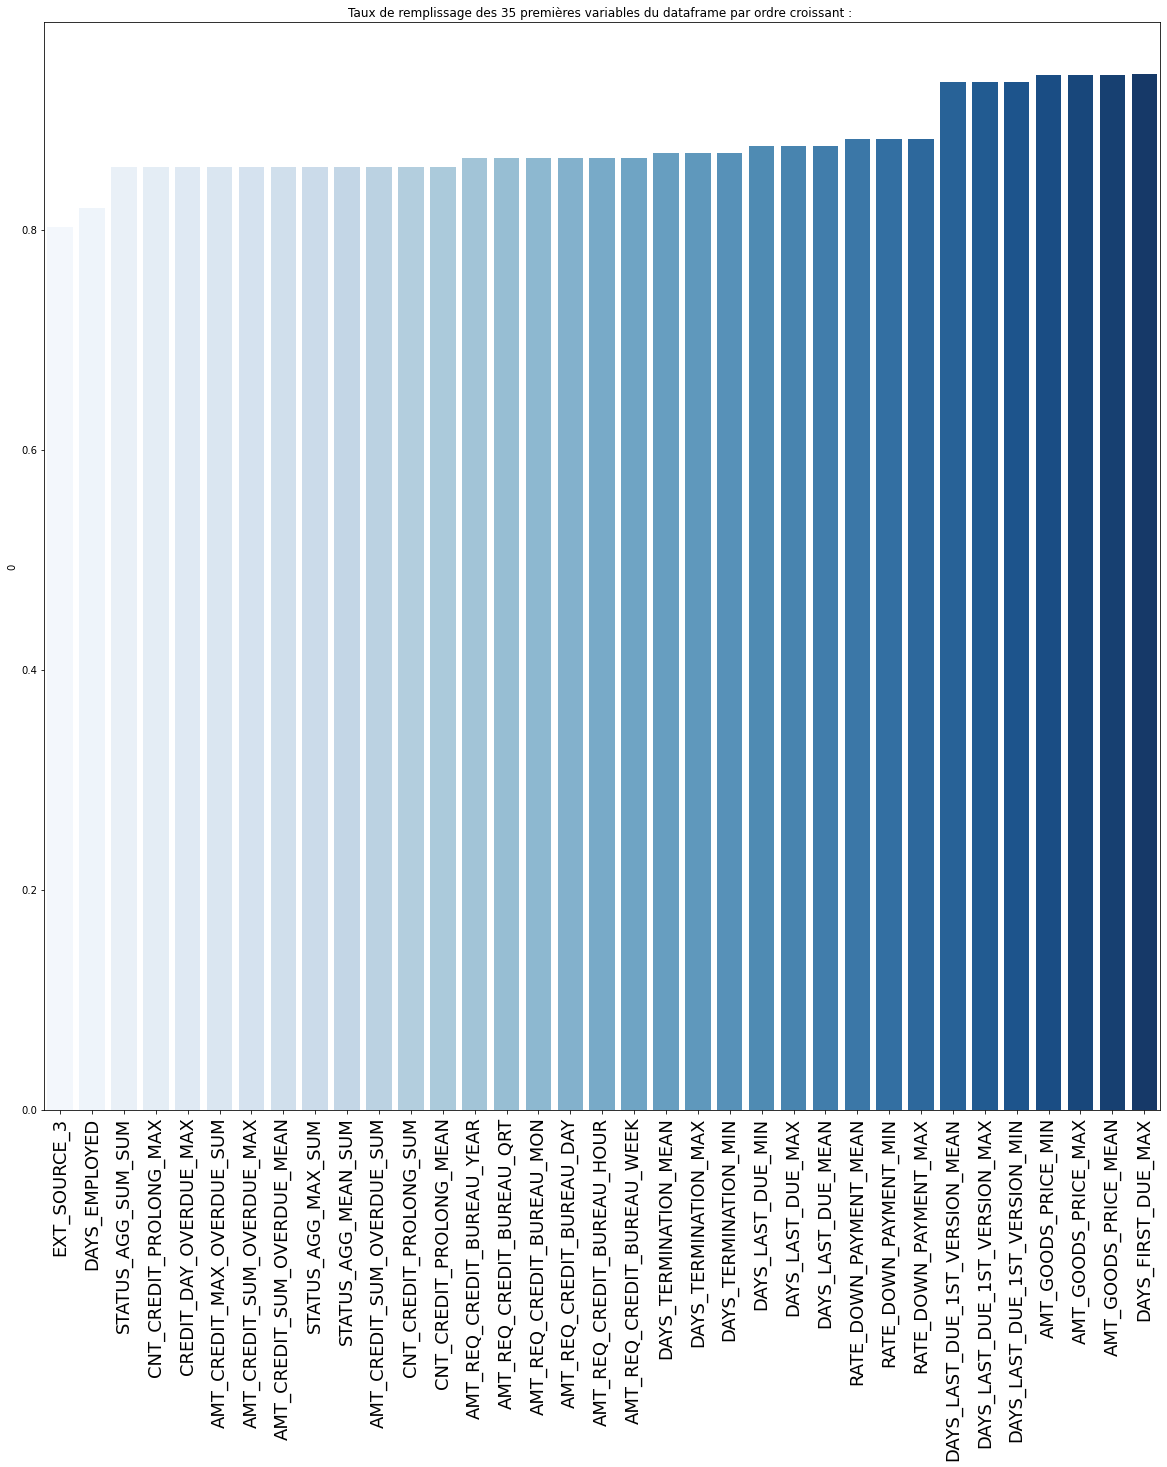

In [56]:
seuil=0.6

def fillrate(s) : 
    rate=(s.size-s.isna().sum())/s.size
    return rate

#Suppression des colonnes insuffisamment remplies : 
trainfile.OCCUPATION_TYPE=trainfile.OCCUPATION_TYPE.fillna('Undeclared')
trainfile=trainfile[:][trainfile.columns.where([fillrate(trainfile[i])>seuil for i in trainfile.columns]).dropna()]
#Traitement des valeurs aberrantes : 
trainfile=trainfile[trainfile['AMT_INCOME_TOTAL']<1e8]
trainfile=trainfile[trainfile['OBS_30_CNT_SOCIAL_CIRCLE']<200]
trainfile['DAYS_EMPLOYED']=trainfile['DAYS_EMPLOYED'].replace({365243: np.nan})
#Traitement des variables catégoriques : 

basic_info(trainfile,decr=False)

Cela reste significativement plus que dans notre df initial, on va donc repartir de ce dernier : 

In [57]:
baseline_df=charger_reduire('application_train.csv')


lecture du dataset
volume du df initial : 300130864 octets
réduction de données en cours
volume du df après réduction : 169746200 octets
0 doublons sont en cours de suppression,index concernés : 

Doublons purs : Int64Index([], dtype='int64')



Dimensions du dataframe : (306488, 73)
Types de données contenues:
int32      40
float32    20
object     12
float64     1
dtype: int64
Taux de remplissage des 35 premières variables par ordre croissant : 
                                   0
EXT_SOURCE_3                0.801973
DAYS_EMPLOYED               0.819889
AMT_REQ_CREDIT_BUREAU_YEAR  0.865088
AMT_REQ_CREDIT_BUREAU_QRT   0.865088
AMT_REQ_CREDIT_BUREAU_MON   0.865088
AMT_REQ_CREDIT_BUREAU_WEEK  0.865088
AMT_REQ_CREDIT_BUREAU_DAY   0.865088
AMT_REQ_CREDIT_BUREAU_HOUR  0.865088
NAME_TYPE_SUITE             0.995785
EXT_SOURCE_2                0.997860
AMT_GOODS_PRICE             0.999093
AMT_ANNUITY                 0.999961
CNT_FAM_MEMBERS             0.999993
DAYS_LAST_PHONE_CHANGE      0.999997
FLAG_DOCUMENT_7             1.000000
FLAG_DOCUMENT_21            1.000000
OBS_30_CNT_SOCIAL_CIRCLE    1.000000
DEF_30_CNT_SOCIAL_CIRCLE    1.000000
OBS_60_CNT_SOCIAL_CIRCLE    1.000000
DEF_60_CNT_SOCIAL_CIRCLE    1.000000
FLAG_DOCUMENT_2 

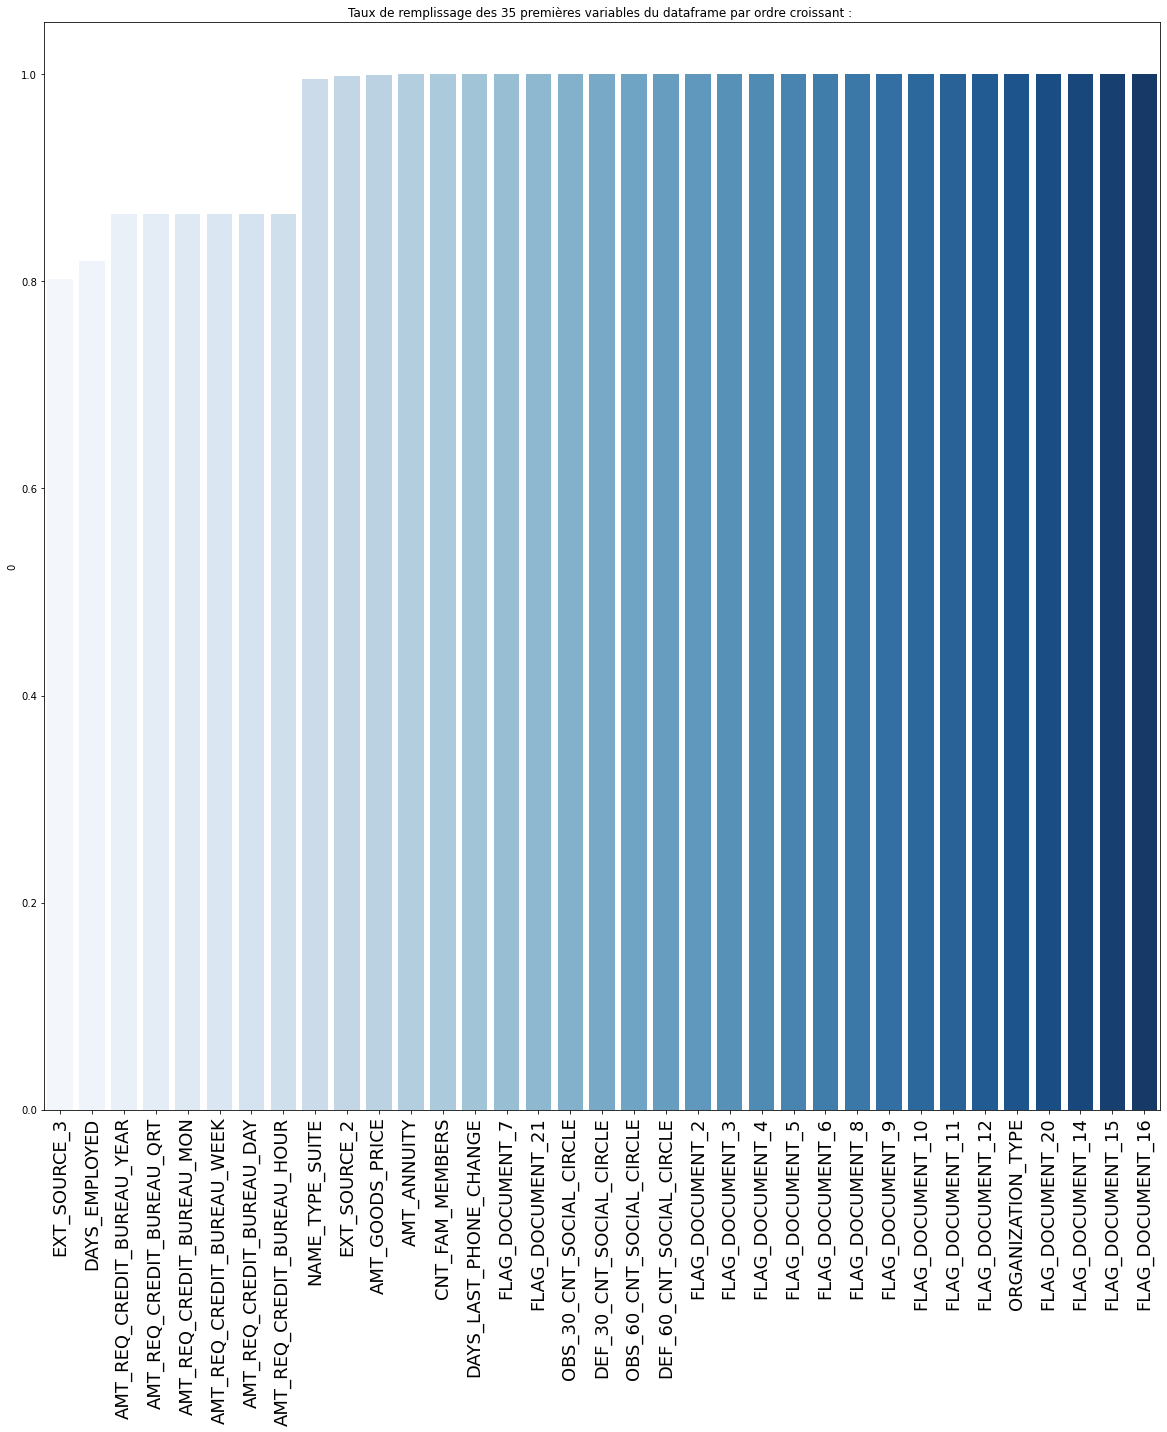

In [58]:
seuil=0.6

def fillrate(s) : 
    rate=(s.size-s.isna().sum())/s.size
    return rate

#Suppression des colonnes insuffisamment remplies : 
baseline_df.OCCUPATION_TYPE=baseline_df.OCCUPATION_TYPE.fillna('Undeclared')
baseline_df=baseline_df[:][baseline_df.columns.where([fillrate(baseline_df[i])>seuil for i in baseline_df.columns]).dropna()]
#Traitement des valeurs aberrantes : 
baseline_df=baseline_df[baseline_df['AMT_INCOME_TOTAL']<1e8]
baseline_df=baseline_df[baseline_df['OBS_30_CNT_SOCIAL_CIRCLE']<200]
baseline_df['DAYS_EMPLOYED']=baseline_df['DAYS_EMPLOYED'].replace({365243: np.nan})
#Traitement des variables catégoriques : 

basic_info(baseline_df,decr=False)

On fait notre train/test split ici : 

In [59]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train,y_test=train_test_split(baseline_df.drop(columns=['SK_ID_CURR','TARGET']),baseline_df['TARGET'],test_size=0.2)

### Codage et instantiation des transformateurs et  modèles : 
On va définir des pipelines pour traiter les variables selon leur type (une explication visuelle est disponible dans la présentation powerpoint), on crée donc les fonctions de preprocessing nécessaires, qu'on pourra convertir en transformateur sklearn : 

In [60]:
#La fonction d'encodage binaire repère les variables objet binaires au sein du df "modèle" (non-échantillonné) et les encode pour 
#éviter un encodage one-hot non-nécessaire : 
def binary_encode(df, model_df=trainfile.drop(columns=['SK_ID_CURR','TARGET'])) : 
    tab=df.copy(deep=True)
    mask=[model_df[col].unique().shape[0]<=3 for col in model_df.select_dtypes(include='O').columns]
    col=model_df.select_dtypes(include='O').columns[mask]
    for i in col : 
        tab=tab.replace({i:{'N':0,'No':0,'no':0,'Y':1,'Yes':1,'yes':1,'M':1,'F':0,'Cash loans':1,'Revolving loans':0,'XNA':np.nan}})
        tab[i]=tab[i].astype('bool')
    return tab

#La fonction suivante convertit une colonne en mode largeur fixe, la liste modèle recense les valeurs uniques - si une autre valeur
# existe dans la colonne elle sera encodée au sein de la catégorie Other: 
def one_hot_encoding_fixed_columns(serie, model_columns):

    fixed_columns = list(model_columns)
    fixed_columns.extend([np.nan, 'Other'])
    ohe_df = pd.get_dummies(serie, dummy_na=True)
    ohe_df['Other'] = 0
    for column in ohe_df.columns:
        if column not in fixed_columns:
            ohe_df['Other'] = ohe_df['Other'] + ohe_df[column]
            ohe_df=ohe_df.drop(columns=column)
    for column in fixed_columns:
        if column not in ohe_df.columns:
            ohe_df[column] = 0
    ohe_df = ohe_df[fixed_columns]
    ohe_df.columns=pd.Index([str(serie.name)+'_'+str(col) for col in ohe_df.columns.tolist()])
    return ohe_df
#Ici on utilise la fonction précédente pour encoder toutes les catégories d'un tableau à largeur fixe à partir d'un tableau 
# "modèle" supposer contenir toutes les valeurs uniques possibles
def one_hot_encode_fixed_col(df, model_df=trainfile.drop(columns=['SK_ID_CURR','TARGET'])) : 
    tab=df.copy(deep=True)
    feat=df.select_dtypes(include='O').columns
    for col in feat :
        fix_col=model_df[col].unique().tolist()
        tab2=one_hot_encoding_fixed_columns(tab[col],fix_col)
        tab=pd.concat([tab,tab2], axis=1)
        tab=tab.drop(columns=col)    
    return tab
#Fonction globale d'encodage des colonnes catégoriques, prête à être convertie en transformer : 
def encode_cat(df) : 
    tab=df.copy(deep=True)
    tabb=binary_encode(tab,model_df=baseline_df)
    tabbb=one_hot_encode_fixed_col(tabb,model_df=baseline_df)
    return tabbb

On va maintenant créer nos pipelines de pré-traitement et un column transformer pour pourvoir leur fournir n'importe quelle version de notre df : 

In [61]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import make_column_transformer

cont_mask=[x_train[col].unique().shape[0]>3 for col in x_train.select_dtypes(exclude='O').columns]
disc_mask=[x_train[col].unique().shape[0]<=3 for col in x_train.select_dtypes(exclude='O').columns]
cont_features=x_train.select_dtypes(exclude='O').columns[cont_mask]
disc_features=x_train.select_dtypes(exclude='O').columns[disc_mask]
cate_features=x_train.select_dtypes(include='O').columns

continuous_pl=make_pipeline(StandardScaler(),SimpleImputer(strategy='mean'))
discrete_pl=make_pipeline(SimpleImputer(strategy='most_frequent'))

encode=FunctionTransformer(func=encode_cat)
categorical_pl=make_pipeline(encode,SimpleImputer(strategy='most_frequent') )

preproc=make_column_transformer((continuous_pl,cont_features),(discrete_pl,disc_features),(categorical_pl,cate_features))


On définit une fonction de sous-échantillonnage pour équilibrer les 2 classes au sein de nos données d'apprentissage. <br>Et on l'utilise tout de suite sur notre trainset : 

In [62]:
def downsample(x_train,y_train) : 

    index_rand=y_train[y_train==0].sample(y_train.sum()).index
    y_train_down=pd.concat((y_train[y_train==1],y_train[index_rand]),axis=0)
    x_train_down_0=x_train.loc[index_rand]
    x_train_down_1=x_train.loc[y_train==1]
    x_train_down=pd.concat([x_train_down_1,x_train_down_0],axis=0)
    return x_train_down,y_train_down

X,y=downsample(x_train,y_train)

On peut maintenant instancier les modèles à comparer : 

In [63]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

pipe_rf=make_pipeline(preproc,RandomForestClassifier())
pipe_lr=make_pipeline(preproc,LogisticRegression(max_iter=10000))
pipe_knn=make_pipeline(preproc,KNeighborsClassifier(n_neighbors=5))
pipe_sgd=make_pipeline(preproc,SGDClassifier(loss="log", penalty="elasticnet"))
pipe_dt=make_pipeline(preproc,DecisionTreeClassifier())
pipe_svc=make_pipeline(preproc,SVC(kernel='poly'))

pipe_rf.fit(X,y)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('standardscaler',
                                                                   StandardScaler()),
                                                                  ('simpleimputer',
                                                                   SimpleImputer())]),
                                                  Index(['CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY',
       'AMT_GOODS_PRICE', 'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH',
       'DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLIS...
                                                                   SimpleImputer(strategy='most_frequent'))]),
                                                  Index(['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY',
       'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATIO

In [64]:
pipe_lr.fit(X,y)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('standardscaler',
                                                                   StandardScaler()),
                                                                  ('simpleimputer',
                                                                   SimpleImputer())]),
                                                  Index(['CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY',
       'AMT_GOODS_PRICE', 'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH',
       'DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLIS...
                                                                   SimpleImputer(strategy='most_frequent'))]),
                                                  Index(['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY',
       'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATIO

In [65]:
# pipe_knn.fit(X,y)

In [66]:
pipe_sgd.fit(X,y)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('standardscaler',
                                                                   StandardScaler()),
                                                                  ('simpleimputer',
                                                                   SimpleImputer())]),
                                                  Index(['CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY',
       'AMT_GOODS_PRICE', 'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH',
       'DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLIS...
                                                                   SimpleImputer(strategy='most_frequent'))]),
                                                  Index(['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY',
       'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATIO

In [67]:
pipe_dt.fit(X,y)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('standardscaler',
                                                                   StandardScaler()),
                                                                  ('simpleimputer',
                                                                   SimpleImputer())]),
                                                  Index(['CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY',
       'AMT_GOODS_PRICE', 'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH',
       'DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLIS...
                                                                   SimpleImputer(strategy='most_frequent'))]),
                                                  Index(['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY',
       'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATIO

In [68]:
pipe_svc.fit(X,y)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('standardscaler',
                                                                   StandardScaler()),
                                                                  ('simpleimputer',
                                                                   SimpleImputer())]),
                                                  Index(['CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY',
       'AMT_GOODS_PRICE', 'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH',
       'DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLIS...
                                                                  ('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent'))]),
                                                  Index(['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_C

### Cross validation et comparaison de modèles : 

<ipython-input-69-b8ea481b67d4>:65: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_xticklabels(nam,rotation=45)
<ipython-input-69-b8ea481b67d4>:71: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax3.set_xticklabels(nam,rotation=45)


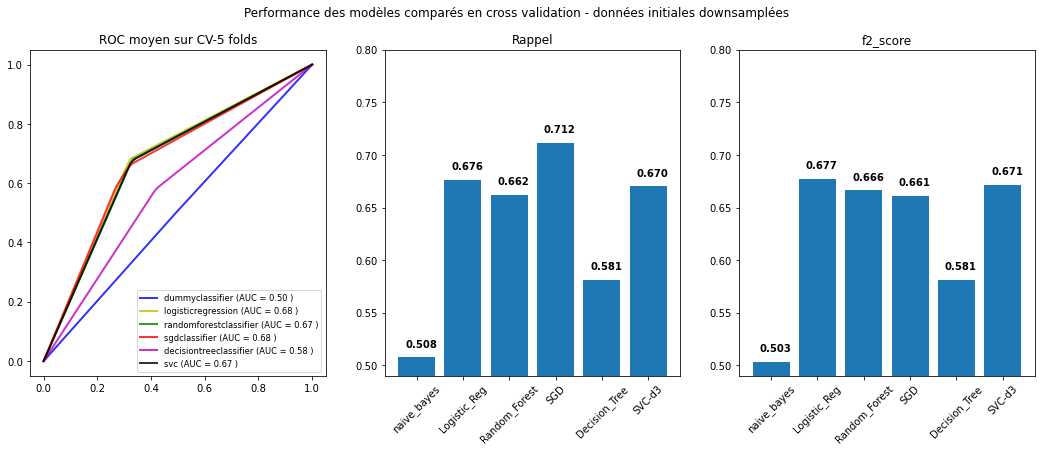

In [69]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer
from sklearn.metrics import fbeta_score
import sklearn
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import StratifiedKFold

dum=make_pipeline(preproc,DummyClassifier(strategy='stratified'))
dum.fit(X,y)

fig, (ax1, ax2,ax3) = plt.subplots(1, 3)
fig.set_size_inches(18,6)

cv = StratifiedKFold(n_splits=5)
estimators = [dum,pipe_lr,pipe_rf,pipe_sgd,pipe_dt,pipe_svc]#,pipe_knn
colors=['b','y','g','r','m','k']#,'c'
for n,classifier in enumerate(estimators):

    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)

    for i, (train, test) in enumerate(cv.split(X, y)):
        classifier.fit(X.iloc[train], y.iloc[train])
        viz = sklearn.metrics.roc_curve(classifier.predict(X.iloc[test]), y.iloc[test])
        interp_tpr = np.interp(mean_fpr, viz[0], viz[1])
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = sklearn.metrics.auc(mean_fpr, mean_tpr)
    ax1.plot(mean_fpr, mean_tpr, color=colors[n],
            label=f'{classifier.steps[-1][0]} (AUC = {mean_auc:.2f} )',
            lw=2, alpha=.8)
    
ax1.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
        title="ROC moyen sur CV-5 folds")
ax1.legend(loc="lower right", fontsize='small')

nam=['naive_bayes','Logistic_Reg','Random_Forest','SGD','Decision_Tree','SVC-d3']#,'5nn'
val=[np.mean(sklearn.model_selection.cross_val_score(dum,X,y,scoring='recall')),
        np.mean(sklearn.model_selection.cross_val_score(pipe_lr,X,y,scoring='recall')),
        np.mean(sklearn.model_selection.cross_val_score(pipe_rf,X,y,scoring='recall')),
        #np.mean(sklearn.model_selection.cross_val_score(pipe_knn,X,y,scoring='recall')),
        np.mean(sklearn.model_selection.cross_val_score(pipe_sgd,X,y,scoring='recall')),
        np.mean(sklearn.model_selection.cross_val_score(pipe_dt,X,y,scoring='recall')),
        np.mean(sklearn.model_selection.cross_val_score(pipe_svc,X,y,scoring='recall'))
        ]


scoringf2 = make_scorer(fbeta_score, beta=2)

f2=[np.mean(sklearn.model_selection.cross_val_score(dum,X,y,scoring=scoringf2)),
        np.mean(sklearn.model_selection.cross_val_score(pipe_lr,X,y,scoring=scoringf2)),
        np.mean(sklearn.model_selection.cross_val_score(pipe_rf,X,y,scoring=scoringf2)),
        #np.mean(sklearn.model_selection.cross_val_score(pipe_knn,X,y,scoring=scoringf2)),
        np.mean(sklearn.model_selection.cross_val_score(pipe_sgd,X,y,scoring=scoringf2)),
        np.mean(sklearn.model_selection.cross_val_score(pipe_dt,X,y,scoring=scoringf2)),
        np.mean(sklearn.model_selection.cross_val_score(pipe_svc,X,y,scoring=scoringf2))
        ]

ax2.set_ylim(0.49,0.8)
ax2.bar(x=nam,height=val)
ax2.set_xticklabels(nam,rotation=45)
ax2.set_title(label='Rappel')
for i, v in enumerate(val):
    ax2.text(i-0.25 ,v + 0.01,  f'{v:.3f}', color='black', fontweight='bold')
ax3.set_ylim(0.49,0.8)    
ax3.bar(x=nam,height=f2)
ax3.set_xticklabels(nam,rotation=45)
ax3.set_title(label='f2_score')
for i, v in enumerate(f2):
    ax3.text(i-0.25 ,v + 0.01,  f'{v:.3f}', color='black', fontweight='bold')
fig.suptitle('Performance des modèles comparés en cross validation - données initiales downsamplées')
plt.show()

In [70]:
print(f'recall du classificateur naif : {sklearn.metrics.recall_score(y_test,dum.predict(x_test))}')
print(f'recall de la régression logistique : {sklearn.metrics.recall_score(y_test,pipe_lr.predict(x_test))}')
print(f'recall du random forest : {sklearn.metrics.recall_score(y_test,pipe_rf.predict(x_test))}')
#print(f'recall du classificateur 5-nn : {sklearn.metrics.recall_score(y_test,pipe_knn.predict(x_test))}')
print(f'recall du sgd : {sklearn.metrics.recall_score(y_test,pipe_sgd.predict(x_test))}')
print(f'recall du decision tree : {sklearn.metrics.recall_score(y_test,pipe_dt.predict(x_test))}')
print(f'recall du SVC-d3 : {sklearn.metrics.recall_score(y_test,pipe_dt.predict(x_test))}')

recall du classificateur naif : 0.4906731549067315
recall de la régression logistique : 0.6818734793187348
recall du random forest : 0.6632197891321979
recall du sgd : 0.8347526358475263
recall du decision tree : 0.5910381184103812
recall du SVC-d3 : 0.5910381184103812


In [71]:
print(f'F2 du classificateur naif : {sklearn.metrics.fbeta_score(y_test,dum.predict(x_test),beta=2)}')
print(f'F2 de la régression logistique : {sklearn.metrics.fbeta_score(y_test,pipe_lr.predict(x_test),beta=2)}')
print(f'F2 du random forest : {sklearn.metrics.fbeta_score(y_test,pipe_rf.predict(x_test),beta=2)}')
#print(f'F2 du classificateur 5-nn : {sklearn.metrics.fbeta_score(y_test,pipe_knn.predict(x_test),beta=2)}')
print(f'F2 du sgd : {sklearn.metrics.fbeta_score(y_test,pipe_sgd.predict(x_test),beta=2)}')
print(f'F2 du decision tree : {sklearn.metrics.fbeta_score(y_test,pipe_dt.predict(x_test),beta=2)}')
print(f'F2 du SVC-d3 : {sklearn.metrics.fbeta_score(y_test,pipe_dt.predict(x_test),beta=2)}')

F2 du classificateur naif : 0.2376178660049628
F2 de la régression logistique : 0.4088057959739375
F2 du random forest : 0.401300453932033
F2 du sgd : 0.3831406927615538
F2 du decision tree : 0.3146249325418241
F2 du SVC-d3 : 0.3146249325418241


In [72]:
from sklearn.metrics import confusion_matrix

comparatif=pd.DataFrame(index=['tpr','tnr','tp','fp','tn','fn'],columns=[est.steps[-1][0] for est in estimators])
for est in estimators : 
    pred=est.predict(x_test)
    tn=confusion_matrix(y_test,pred)[0,0]
    fn=confusion_matrix(y_test,pred)[1,0]
    tp=confusion_matrix(y_test,pred)[1,1]
    fp=confusion_matrix(y_test,pred)[0,1]
    tpr=tp/(tp+fp)
    tnr=tn/(tn+fn)
    comparatif[est.steps[-1][0]]=[tpr,tnr,tp,fp,tn,fn]
comparatif

dummyclassifier  logisticregression  randomforestclassifier  \
tpr         0.080277            0.157120                0.155562   
tnr         0.919360            0.960671                0.958754   
tp       2449.000000         3363.000000             3271.000000   
fp      28058.000000        18041.000000            17756.000000   
tn      28308.000000        38325.000000            38610.000000   
fn       2483.000000         1569.000000             1661.000000   

     sgdclassifier  decisiontreeclassifier           svc  
tpr       0.121092                0.109599      0.156235  
tnr       0.970145                0.941875      0.960120  
tp     4117.000000             2915.000000   3340.000000  
fp    29882.000000            23682.000000  18038.000000  
tn    26484.000000            32684.000000  38328.000000  
fn      815.000000             2017.000000   1592.000000

## SELECTION DES FEATURES AVANT OPTIMISATION DU MODELE : 

On a testé une méthode additive pour ajouter individuellement les variables qui améliorent le F2 au df de base - attention très long, mais je fournis le code quand même pour expliciter l'idée. C'est un "SFS" maison, mais comme il travaille sur une cross validation avec une fonction de scoring non-native il est vraiment trop lent pour être utile en l'état : 

In [73]:
# def tuyau (estimateur,X,y) :     

#     input_x=X

#     def encode_cat_internal(df) : 
#         tab=df.copy(deep=True)
#         tabb=binary_encode(tab,model_df=input_x)
#         tabbb=one_hot_encode_fixed_col(tabb,model_df=input_x)
#         return tabbb

#     cont_mask_int=[input_x[col].unique().shape[0]>3 for col in input_x.select_dtypes(exclude='O').columns]
#     disc_mask_int=[input_x[col].unique().shape[0]<=3 for col in input_x.select_dtypes(exclude='O').columns]
#     cont_features_int=input_x.select_dtypes(exclude='O').columns[cont_mask_int]
#     disc_features_int=input_x.select_dtypes(exclude='O').columns[disc_mask_int]
#     cate_features_int=input_x.select_dtypes(include='O').columns

#     continuous_pl_int=make_pipeline(StandardScaler(),SimpleImputer(strategy='mean'))
#     discrete_pl_int=make_pipeline(SimpleImputer(strategy='most_frequent'))

#     encode_internal=FunctionTransformer(func=encode_cat_internal)
#     categorical_pl__int=make_pipeline(encode_internal,SimpleImputer(strategy='most_frequent') )

#     preprocessu=make_column_transformer((continuous_pl_int,cont_features_int),(discrete_pl_int,disc_features_int),
#                                         (categorical_pl__int,cate_features_int))

#     pipe_int=make_pipeline(preprocessu,estimateur)
#     score=np.mean(sklearn.model_selection.cross_val_score(pipe_int,X,y,scoring=scoringf2))
#     return score

# def ajout_selectif(df_base,df_enrichi,estimateur,seuil_amel=0.0005) : 
#     col_add=df_enrichi.columns[~df_enrichi.columns.isin(df_base.columns.tolist())]
#     col_cum=df_base.drop(columns=['SK_ID_CURR','TARGET']).columns
#     X_int,y_int=downsample(df_enrichi.drop(columns=['SK_ID_CURR','TARGET']),df_enrichi['TARGET'])
#     print(f'Score de cv sur le df de base :{tuyau(estimateur,X_int[col_cum],y_int):.4f}')
#     for column in col_add : 
#         col_test=col_cum
#         col_test.append(pd.Index([column]))
#         bs=X_int[col_cum].copy(deep=True)
#         tf=X_int[col_test].copy(deep=True)
#         baseline=tuyau(estimateur,bs,y_int)
#         res=tuyau(estimateur,tf,y_int)
#         if (res-baseline>=seuil_amel) : 
#             print(f'{column} apporte une amélioration du f2 et sera conservée, score moyen en cv : {res:.4f} ')
#             col_cum.append(pd.Index([column]))
#         else : 
#             print(f'{column} a été testée sans résultat probant et sera éliminée')
#     return df_enrichi[col_cum]


# df_augm_lr=ajout_selectif(baseline_df,trainfile,LogisticRegression(max_iter=10000,dual=False))

On crée les modèles qui vont apprendre du tableau initial sous forme de nouveaux pipelines : 

In [74]:
# Cette fois on encapsule le nom du df pour rendre le pipeline opérationnel sur n'importe quel df en changeant juste le nom. On n'a plus qu'à changer 
# au besoin le nom du df en haut du code et on peut évaluer autant de df (et donc de nouvelles features) qu'on le souhaite : 

input_df=trainfile

input_x=input_df.drop(columns=['SK_ID_CURR','TARGET'])
input_y=input_df['TARGET']

def encode_cat_base(df) : 
    tab=df.copy(deep=True)
    tabb=binary_encode(tab,model_df=input_x)
    tabbb=one_hot_encode_fixed_col(tabb,model_df=input_x)
    return tabbb

cont_mask=[input_x[col].unique().shape[0]>3 for col in input_x.select_dtypes(exclude='O').columns]
disc_mask=[input_x[col].unique().shape[0]<=3 for col in input_x.select_dtypes(exclude='O').columns]
cont_features=input_x.select_dtypes(exclude='O').columns[cont_mask]
disc_features=input_x.select_dtypes(exclude='O').columns[disc_mask]
cate_features=input_x.select_dtypes(include='O').columns

continuous_pl=make_pipeline(StandardScaler(),SimpleImputer(strategy='mean'))
discrete_pl=make_pipeline(SimpleImputer(strategy='most_frequent'))

encode_base=FunctionTransformer(func=encode_cat_base)
categorical_pl_base=make_pipeline(encode_base,SimpleImputer(strategy='most_frequent') )

preprocess=make_column_transformer((continuous_pl,cont_features),(discrete_pl,disc_features),(categorical_pl_base,cate_features))

pipe_rf_base=make_pipeline(preprocess,RandomForestClassifier())
pipe_lr_base=make_pipeline(preprocess,LogisticRegression(max_iter=10000))

x_train_base, x_test_base, y_train_base,y_test_base=train_test_split(input_df.drop(columns=['SK_ID_CURR','TARGET']),
                                                                     input_df['TARGET'],test_size=0.2)
X_base,y_base=downsample(x_train_base,y_train_base)


pipe_lr_base.fit(X_base,y_base)
pipe_rf_base.fit(X_base,y_base)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('standardscaler',
                                                                   StandardScaler()),
                                                                  ('simpleimputer',
                                                                   SimpleImputer())]),
                                                  Index(['CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY',
       'AMT_GOODS_PRICE', 'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH',
       'DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLIS...
       'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE',
       'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'OCCUPATION_TYPE',
       'WEEKDAY_APPR_PROCESS_START', 'ORGANIZATION_TYPE',
       'NAME_CONTRACT_TYPE_MIN', 'NAME_CONTRACT_TYPE_MAX',
       'FLAG_LAST_APPL_PER_CONTRACT_MIN', 'FL

In [75]:
X_base.shape

(39708, 618)

<ipython-input-76-525fb74105d3>:31: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_xticklabels(nam,rotation=75)
<ipython-input-76-525fb74105d3>:38: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax3.set_xticklabels(nam,rotation=75)


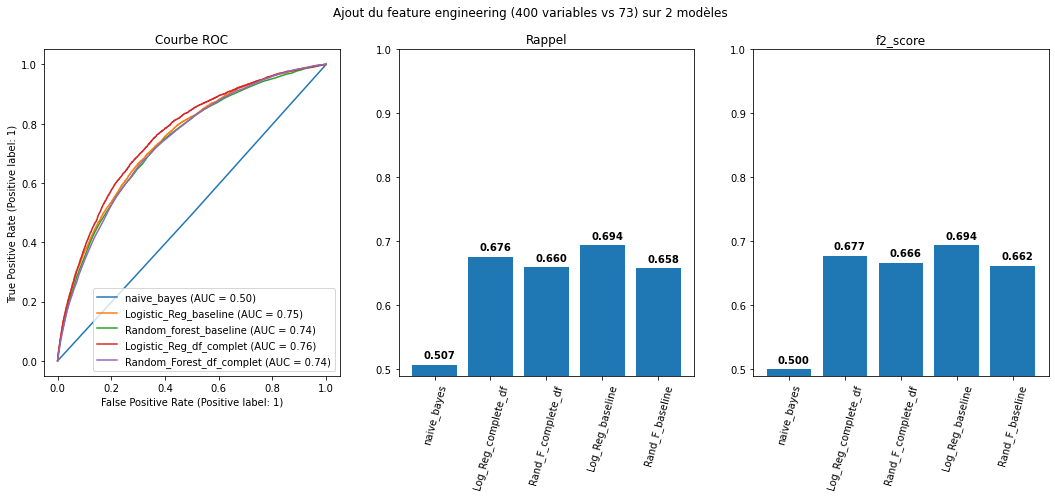

In [76]:
fig, (ax1, ax2,ax3) = plt.subplots(1, 3)
fig.set_size_inches(18,6)

sklearn.metrics.plot_roc_curve(dum,x_test,y_test,name='naive_bayes',ax=ax1,response_method='predict_proba')
sklearn.metrics.plot_roc_curve(pipe_lr,x_test,y_test,name='Logistic_Reg_baseline',ax=ax1,response_method='predict_proba')
sklearn.metrics.plot_roc_curve(pipe_rf,x_test,y_test,name='Random_forest_baseline',ax=ax1,response_method='predict_proba')
sklearn.metrics.plot_roc_curve(pipe_lr_base,x_test_base,y_test_base,name='Logistic_Reg_df_complet',ax=ax1,response_method='predict_proba')
sklearn.metrics.plot_roc_curve(pipe_rf_base,x_test_base,y_test_base,name='Random_Forest_df_complet',ax=ax1,response_method='predict_proba')

ax1.set_title(label='Courbe ROC')


nam=['naive_bayes','Log_Reg_complete_df','Rand_F_complete_df','Log_Reg_baseline','Rand_F_baseline']#,'Log_Reg_augm_df','Rand_F_augm_df'
val=[np.mean(sklearn.model_selection.cross_val_score(dum,X,y,scoring='recall',n_jobs=-3)),
        np.mean(sklearn.model_selection.cross_val_score(pipe_lr,X,y,scoring='recall',n_jobs=-3)),
        np.mean(sklearn.model_selection.cross_val_score(pipe_rf,X,y,scoring='recall',n_jobs=-3)),
        np.mean(sklearn.model_selection.cross_val_score(pipe_lr_base,X_base,y_base,scoring='recall',n_jobs=-3)),
        np.mean(sklearn.model_selection.cross_val_score(pipe_rf_base,X_base,y_base,scoring='recall',n_jobs=-3)),

        ]
f2=[np.mean(sklearn.model_selection.cross_val_score(dum,X,y,scoring=scoringf2,n_jobs=-3)),
        np.mean(sklearn.model_selection.cross_val_score(pipe_lr,X,y,scoring=scoringf2,n_jobs=-3)),
        np.mean(sklearn.model_selection.cross_val_score(pipe_rf,X,y,scoring=scoringf2,n_jobs=-3)),
        np.mean(sklearn.model_selection.cross_val_score(pipe_lr_base,X_base,y_base,scoring=scoringf2,n_jobs=-3)),
        np.mean(sklearn.model_selection.cross_val_score(pipe_rf_base,X_base,y_base,scoring=scoringf2,n_jobs=-3)),

        ]

ax2.set_ylim(0.49,1)
ax2.bar(x=nam,height=val)
ax2.set_xticklabels(nam,rotation=75)
ax2.set_title(label='Rappel')
for i, v in enumerate(val):
    ax2.text(i-0.2 ,v + 0.01,  f'{v:.3f}', color='black', fontweight='bold')

ax3.set_ylim(0.49,1)
ax3.bar(x=nam,height=f2)
ax3.set_xticklabels(nam,rotation=75)
ax3.set_title(label='f2_score')
for i, v in enumerate(f2):
    ax3.text(i-0.2 ,v + 0.01,  f'{v:.3f}', color='black', fontweight='bold')    
fig.suptitle('Ajout du feature engineering (400 variables vs 73) sur 2 modèles')
plt.show()

Comparons aussi les scores en généralisation sur le jeu de test : 

In [77]:
print(f'f2 du classificateur naif : {sklearn.metrics.fbeta_score(y_test,dum.predict(x_test),beta=2)}')
print(f'f2 de la régression logistique : {sklearn.metrics.fbeta_score(y_test,pipe_lr.predict(x_test),beta=2)}')
print(f'f2 du random forest : {sklearn.metrics.fbeta_score(y_test,pipe_rf.predict(x_test),beta=2)}')
print(f'f2 de la régression log sur df complet : {sklearn.metrics.fbeta_score(y_test_base,pipe_lr_base.predict(x_test_base),beta=2)}')
print(f'f2 du rf sur df complet : {sklearn.metrics.fbeta_score(y_test_base,pipe_rf_base.predict(x_test_base),beta=2)}')

f2 du classificateur naif : 0.24419503876583848
f2 de la régression logistique : 0.4088057959739375
f2 du random forest : 0.401300453932033
f2 de la régression log sur df complet : 0.426088673842204
f2 du rf sur df complet : 0.40641449381809275


In [78]:
print(f'Recall du classificateur naif : {sklearn.metrics.recall_score(y_test,dum.predict(x_test))}')
print(f'Recall de la régression logistique sur df base : {sklearn.metrics.recall_score(y_test,pipe_lr.predict(x_test))}')
print(f'Recall du random forest sur df base : {sklearn.metrics.recall_score(y_test,pipe_rf.predict(x_test))}')
print(f'Recall de la régression log sur df complet : {sklearn.metrics.recall_score(y_test_base,pipe_lr_base.predict(x_test_base))}')
print(f'Recall du rf sur df complet : {sklearn.metrics.recall_score(y_test_base,pipe_rf_base.predict(x_test_base))}')

Recall du classificateur naif : 0.5034468775344688
Recall de la régression logistique sur df base : 0.6818734793187348
Recall du random forest sur df base : 0.6632197891321979
Recall de la régression log sur df complet : 0.6996351844345359
Recall du rf sur df complet : 0.6728820429671666


In [79]:
print(f'Precision du classificateur naif : {sklearn.metrics.precision_score(y_test,dum.predict(x_test))}')
print(f'Precision de la régression logistique sur df base : {sklearn.metrics.precision_score(y_test,pipe_lr.predict(x_test))}')
print(f'Precision du random forest sur df base : {sklearn.metrics.precision_score(y_test,pipe_rf.predict(x_test))}')
print(f'Precision de la régression log sur df complet : {sklearn.metrics.precision_score(y_test_base,pipe_lr_base.predict(x_test_base))}')
print(f'Precision du rf sur df complet : {sklearn.metrics.precision_score(y_test_base,pipe_rf_base.predict(x_test_base))}')

Precision du classificateur naif : 0.08071032909742587
Precision de la régression logistique sur df base : 0.15712016445524202
Precision du random forest sur df base : 0.15556189660912162
Precision de la régression log sur df complet : 0.16618524937415752
Precision du rf sur df complet : 0.15727888578331517


La régression logistique performe un peu mieux, et a des temps d'exécution bien plus courts, on va donc maintenant se concentrer sur cette dernière. 

### Interprétabilité générale du modèle : 
Maintenant, on va regarder quelles variables ont le plus de "poids" pour notre modèle. 
On commence par récupérer les coefficients de notre modèle de régression logistique : 

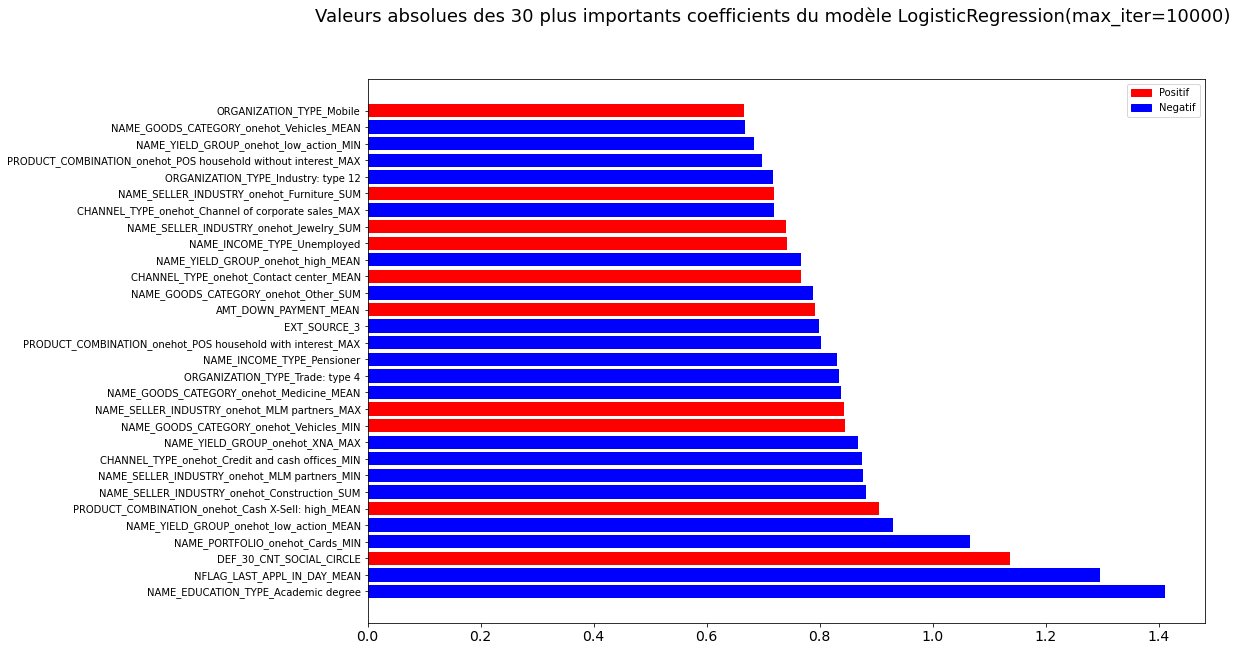

coeffs   val_abs
NAME_EDUCATION_TYPE_Academic degree                -1.411077  1.411077
NFLAG_LAST_APPL_IN_DAY_MEAN                        -1.296280  1.296280
DEF_30_CNT_SOCIAL_CIRCLE                            1.137469  1.137469
NAME_PORTFOLIO_onehot_Cards_MIN                    -1.065490  1.065490
NAME_YIELD_GROUP_onehot_low_action_MEAN            -0.930369  0.930369
PRODUCT_COMBINATION_onehot_Cash X-Sell: high_MEAN   0.905684  0.905684
NAME_SELLER_INDUSTRY_onehot_Construction_SUM       -0.881395  0.881395
NAME_SELLER_INDUSTRY_onehot_MLM partners_MIN       -0.876339  0.876339
CHANNEL_TYPE_onehot_Credit and cash offices_MIN    -0.874662  0.874662
NAME_YIELD_GROUP_onehot_XNA_MAX                    -0.868536  0.868536
NAME_GOODS_CATEGORY_onehot_Vehicles_MIN             0.844363  0.844363
NAME_SELLER_INDUSTRY_onehot_MLM partners_MAX        0.842591  0.842591
NAME_GOODS_CATEGORY_onehot_Medicine_MEAN           -0.838557  0.838557
ORGANIZATION_TYPE_Trade: type 4                    -0.833736  0.833736
NAME_INCOME_TYPE_Pensioner                         -0.829926  0.829926
PRODUCT_COMBINATION_onehot_POS household with i... -0.802310  0.802310
EXT_SOURCE_3                                       -0.797995  0.797995
AMT_DOWN_PAYMENT_MEAN                               0.791574  0.791574
NAME_GOODS_CATEGORY_onehot_Other_SUM               -0.787546  0.787546
CHANNEL_TYPE_onehot_Contact center_MEAN             0.767788  0.767788
NAME_YIELD_GROUP_onehot_high_MEAN                  -0.766795  0.766795
NAME_INCOME_TYPE_Unemployed                         0.741507  0.741507
NAME_SELLER_INDUSTRY_onehot_Jewelry_SUM             0.740405  0.740405
CHANNEL_TYPE_onehot_Channel of corporate sales_MAX -0.719860  0.719860
NAME_SELLER_INDUSTRY_onehot_Furniture_SUM           0.718635  0.718635
ORGANIZATION_TYPE_Industry: type 12                -0.716651  0.716651
PRODUCT_COMBINATION_onehot_POS household withou... -0.698385  0.698385
NAME_YIELD_GROUP_onehot_low_action_MIN             -0.683083  0.683083
NAME_GOODS_CATEGORY_onehot_Vehicles_MEAN           -0.667251  0.667251
ORGANIZATION_TYPE_Mobile                            0.665988  0.665988

In [80]:
import matplotlib.patches as mpatches
def explic_model_lin(estim=pipe_lr[-1],trainset=X,n_feat=30, graph=True) : 
    coeff=estim.coef_[0]
    t=pd.concat([trainset.select_dtypes(exclude='O'),encode_cat_base(trainset.select_dtypes(include='O'))],axis=1)
    coeffs=pd.DataFrame(coeff,index=t.columns)
    coeffs=coeffs.rename(columns={0:'coeffs'})
    coeffs.loc[:,'val_abs']=abs(coeffs['coeffs'])
    aff=coeffs.sort_values(by='val_abs',ascending=False).head(n_feat)
    
    names=aff.index.tolist()
    values=aff.val_abs.tolist()
    colors=[]
    [colors.append('r') if i>0 else colors.append('b') for i in aff.coeffs]
    if graph==True : 
        plt.figure(figsize=(15,10))
        plt.barh(names, values,color=colors)
        plt.suptitle(f'Valeurs absolues des {n_feat} plus importants coefficients du modèle {estim}', fontsize=18)
        plt.xticks(fontsize=14)
        plt.xticks(fontsize=14)
        red_patch = mpatches.Patch(color='red', label='Positif')
        blue_patch = mpatches.Patch(color='blue', label='Negatif')
        plt.legend(handles=[red_patch,blue_patch])
        plt.show()
    else : 
        pass
    return aff

explic_model_lin(pipe_lr_base[-1],X_base,30,True)

On calcule l'importance des variables par permutation - l'évaluation est faite sur le jeu de test : on perturbe une à une les variables en leur attribuant des valeurs aléatoires, on fait des prédictions et on mesure la perte de valeur prédictive directement sur notre fonction de cout (la métrique F2). On normalise la somme des pertes mesurées à 1 et on obtient un coefficient reflétant l'importance de nos variables pour le modèle et la métrique choisis. 
Ici on fait ça sur le jeu de test et notre régression logistique : 

In [81]:
from sklearn.inspection import permutation_importance

lr_permimp=permutation_importance(pipe_lr_base, x_test_base,y_test_base,scoring=scoringf2,n_repeats=5,random_state=0)

PAYMENT_DELAY_SUM_MIN : 0.0811 ± 0.0014
NFLAG_INSURED_ON_APPROVAL_SUM : 0.0538 ± 0.0006
DAYS_REGISTRATION    : 0.0382 ± 0.0005
PAYMENT_DELAY_MAX_MIN : 0.0376 ± 0.0009
DAYS_BIRTH           : 0.0363 ± 0.0003
NFLAG_LAST_APPL_IN_DAY_MIN : 0.0259 ± 0.0005
DAYS_LAST_DUE_1ST_VERSION_MEAN : 0.0238 ± 0.0010
CNT_PAYMENT_MEAN     : 0.0221 ± 0.0007
REG_REGION_NOT_LIVE_REGION : 0.0202 ± 0.0009
NUM_INSTALMENT_VERSION_MAX_MIN : 0.0196 ± 0.0007
NFLAG_INSURED_ON_APPROVAL_MAX : 0.0186 ± 0.0005
NUM_INSTALMENT_VERSION_MAX_SUM : 0.0175 ± 0.0004
NAME_CONTRACT_TYPE_MIN : 0.0159 ± 0.0005
WEEKDAY_APPR_PROCESS_START_onehot_MONDAY_MEAN : 0.0142 ± 0.0004
NFLAG_INSURED_ON_APPROVAL_MEAN : 0.0138 ± 0.0003
AMT_GOODS_PRICE_SUM  : 0.0130 ± 0.0007
RATE_DOWN_PAYMENT_MEAN : 0.0123 ± 0.0008
FLAG_MOBIL           : 0.0109 ± 0.0005
NAME_GOODS_CATEGORY_onehot_Education_MIN : 0.0104 ± 0.0002
WEEKDAY_APPR_PROCESS_START_onehot_MONDAY_MIN : 0.0103 ± 0.0003
HOUR_APPR_PROCESS_START_MIN : 0.0096 ± 0.0002
AMT_DOWN_PAYMENT_SUM : 0.0093

(array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

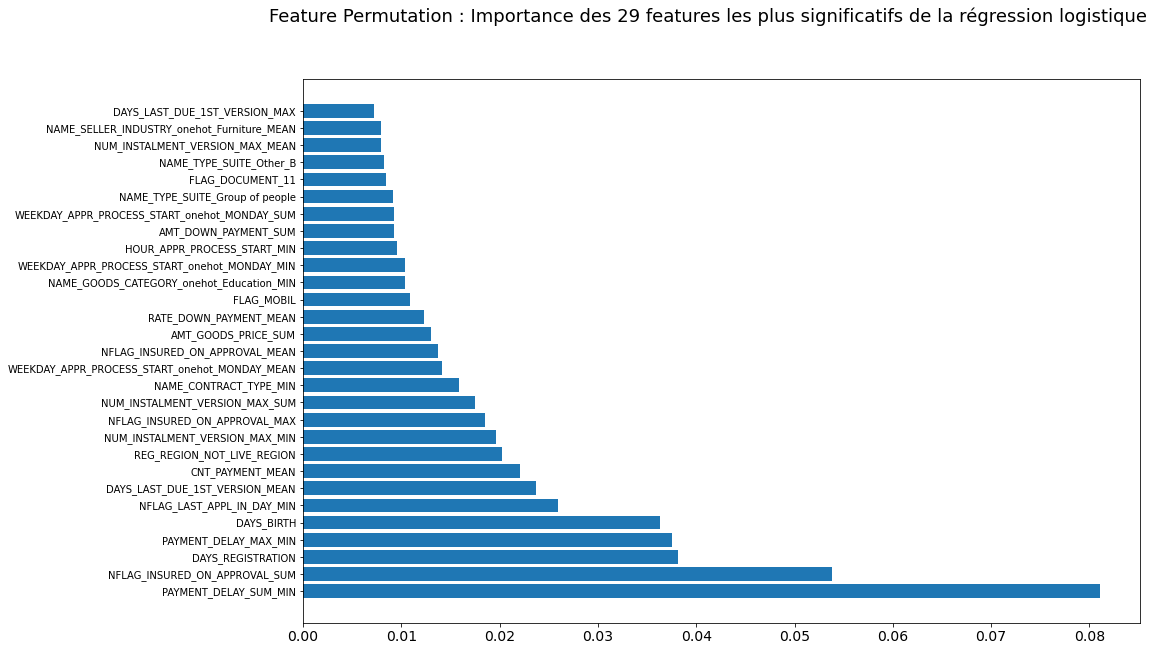

In [82]:

n_feat=30
t=pd.concat([X_base.select_dtypes(exclude='O'),encode_cat_base(X_base.select_dtypes(include='O'))],axis=1)
liste_aff={}
for i in lr_permimp.importances_mean.argsort()[:-n_feat:-1]:
    if lr_permimp.importances_mean[i] - 2 * lr_permimp.importances_std[i] > 0:
        liste_aff[t.columns[i]]=lr_permimp.importances_mean[i]
        print(f"{t.columns[i]:<20} : "
              f"{lr_permimp.importances_mean[i]:.4f}"
              f" ± {lr_permimp.importances_std[i]:.4f}")

names=[]
values=[]
for key,value in liste_aff.items() : 
    names.append(key)
    values.append(value)

plt.figure(figsize=(15,10))
plt.barh(names, values)
plt.suptitle(f'Feature Permutation : Importance des {len(liste_aff)} features les plus significatifs de la régression logistique', fontsize=18)
plt.xticks(fontsize=14)
plt.xticks(fontsize=14)


En croisant ces 2 listes, on peut déjà visualiser les features les plus essentielles : 

In [83]:
ls=explic_model_lin(pipe_lr_base[-1],X_base,30,False)
print([r for r in ls.index.tolist() if r in names])

[]


On ne prend pas cette info en compte pour l'élimination de variables car la régression évaluée recoit plus de 700 features après encodage, et qu'il y a probablement beaucoup de covariants - sous-évalués par la méthode de permutation - qu'on va devoir pondérer avant d'interpréter nos résultats. 

### Création de pipelines filtrants
On va maintenant entraîner un lassoCV à sélectionner les meilleures variables - ce dernier va s'auto évaluer avec 5 folds sur une grille de 100 alphas préprogrammés pour couvrir un range de 3 puissances de 10. 
Pour cela, on va construire un df représentant nos données d'entraînement traitées par le preprocessor de nos pipelines :  

In [84]:
prep=preprocess
cont_mask=[X_base[col].unique().shape[0]>3 for col in X_base.select_dtypes(exclude='O').columns]
disc_mask=[X_base[col].unique().shape[0]<=3 for col in X_base.select_dtypes(exclude='O').columns]
colcont=X_base.select_dtypes(exclude='O').columns[cont_mask]
coldisc=X_base.select_dtypes(exclude='O').columns[disc_mask]
interm=encode_cat_base(X_base.select_dtypes(include='O'))
colcat=interm.columns
colo=colcont.append(coldisc.append(colcat))
x_tra=pd.DataFrame(prep.fit_transform(X_base),columns=colo)
print(f'{x_tra.shape}')
x_tra

(39708, 743)


CNT_CHILDREN AMT_INCOME_TOTAL AMT_CREDIT AMT_ANNUITY AMT_GOODS_PRICE  \
0        -0.592789        -0.946093  -0.872938    -0.89603       -0.769279   
1        -0.592789         0.426332  -0.825178   -0.976413       -0.716917   
2        -0.592789        -1.098585  -1.123674   -1.429275       -1.044176   
3        -0.592789        -0.539449  -0.944577   -0.854018       -0.847821   
4         2.111384         0.883807  -0.826372   -0.618821       -0.847821   
...            ...              ...        ...         ...             ...   
39703    -0.592789         0.680484  -0.696419   -0.463016       -0.769279   
39704    -0.592789         0.172179     0.8464    1.565764        1.115735   
39705    -0.592789         2.205401  -0.347584    0.600828       -0.193302   
39706    -0.592789         -0.59028  -1.063975   -1.307211             0.0   
39707    -0.592789         0.172179   1.093376    0.935926        1.155006   

      REGION_POPULATION_RELATIVE DAYS_BIRTH DAYS_EMPLOYED DAYS_REGISTRATION  \
0                       0.665248  -2.137527           0.0         -0.184435   
1                      -0.805196    0.90029      0.559441         -0.358415   
2                       0.665248  -0.123865      0.760518          0.487046   
3                       0.665248   1.340995     -0.203908          1.260647   
4                      -0.776147   0.849474      0.166596          1.230971   
...                          ...        ...           ...               ...   
39703                   2.021661  -1.520124           0.0          0.588001   
39704                    0.05105   0.072466     -0.409639          0.366308   
39705                  -1.033801   0.447112     -0.190875         -0.789001   
39706                   0.394924   -1.74371           0.0          0.018639   
39707                  -1.307989  -0.187153     -0.300723          0.751508   

      DAYS_ID_PUBLISH  ... ORGANIZATION_TYPE_Trade: type 5  \
0           -0.873774  ...                               0   
1           -0.636177  ...                               0   
2           -0.722215  ...                               0   
3            1.812596  ...                               0   
4            0.861545  ...                               0   
...               ...  ...                             ...   
39703       -1.239105  ...                               0   
39704       -0.843992  ...                               0   
39705       -0.972387  ...                               0   
39706       -1.200057  ...                               0   
39707        -1.40721  ...                               0   

      ORGANIZATION_TYPE_Cleaning ORGANIZATION_TYPE_Industry: type 13  \
0                              0                                   0   
1                              0                                   0   
2                              0                                   0   
3                              0                                   0   
4                              0                                   0   
...                          ...                                 ...   
39703                          0                                   0   
39704                          0                                   0   
39705                          0                                   0   
39706                          0                                   0   
39707                          0                                   0   

      ORGANIZATION_TYPE_Trade: type 4 ORGANIZATION_TYPE_Telecom  \
0                                   0                         0   
1                                   0                         0   
2                                   0                         0   
3                                   0                         0   
4                                   0                         0   
...                               ...                       ...   
39703                               0    

On fait ensuite varier le nombre de variables retenues sur une grille de paramètres puis on compare les scores de prédiction du modèle

In [85]:
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LassoCV
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline


lasso = LassoCV(max_iter=10000).fit(x_tra,y_base)

lrc=LogisticRegression(dual=False,max_iter=10000)
lrc_selector=SelectFromModel(lasso)

pipe_lr_featsel=Pipeline([('preprocessor',preprocess),('selector',lrc_selector),('estimator',lrc)])


params_lr={
    'selector__threshold':[-np.inf],
    'selector__max_features':[4,8,12,16,32,64,128,256,400],
    #'estimator__tol':[1e-5,1e-4,1e-3],    
    #'estimator__C':[0.1, 1, 10, 100]
}

grid_lr=GridSearchCV(pipe_lr_featsel,params_lr,scoring=scoringf2,verbose=3, cv=5)


Voyons déjà à quoi ressemble notre lasso : 

In [86]:
reduit=pd.Series(lasso.coef_,index=x_tra.columns)
reduit[reduit!=0].index

Index(['CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY',
       'AMT_GOODS_PRICE', 'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH',
       'DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH',
       ...
       'ORGANIZATION_TYPE_Transport: type 3', 'ORGANIZATION_TYPE_Police',
       'ORGANIZATION_TYPE_Postal', 'ORGANIZATION_TYPE_Agriculture',
       'ORGANIZATION_TYPE_Restaurant', 'ORGANIZATION_TYPE_Trade: type 3',
       'ORGANIZATION_TYPE_Industry: type 3', 'ORGANIZATION_TYPE_Bank',
       'ORGANIZATION_TYPE_Industry: type 9', 'ORGANIZATION_TYPE_Realtor'],
      dtype='object', length=397)

On va donc pouvoir construire un modèle plus simple et choisir les variables aux coefficients les plus importants parmi celles non éliminées par le lasso : 


In [87]:
reduit[reduit!=0].index.shape

(397,)

Il reste encore beaucoup de variables, voyons combien d'entre elles apportent réellement à notre modèle : 

In [88]:
grid_lr.fit(X_base,y_base)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV 1/5] END selector__max_features=4, selector__threshold=-inf; total time=  38.9s
[CV 2/5] END selector__max_features=4, selector__threshold=-inf; total time=  25.4s
[CV 3/5] END selector__max_features=4, selector__threshold=-inf; total time=  22.5s
[CV 4/5] END selector__max_features=4, selector__threshold=-inf; total time=  24.0s
[CV 5/5] END selector__max_features=4, selector__threshold=-inf; total time=  26.4s
[CV 1/5] END selector__max_features=8, selector__threshold=-inf; total time=  39.0s
[CV 2/5] END selector__max_features=8, selector__threshold=-inf; total time=  25.4s
[CV 3/5] END selector__max_features=8, selector__threshold=-inf; total time=  22.6s
[CV 4/5] END selector__max_features=8, selector__threshold=-inf; total time=  23.4s
[CV 5/5] END selector__max_features=8, selector__threshold=-inf; total time=  26.1s
[CV 1/5] END selector__max_features=12, selector__threshold=-inf; total time=  39.0s
[CV 2/5] END se

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('pipeline-1',
                                                                         Pipeline(steps=[('standardscaler',
                                                                                          StandardScaler()),
                                                                                         ('simpleimputer',
                                                                                          SimpleImputer())]),
                                                                         Index(['CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY',
       'AMT_GOODS_PRICE', 'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH',
       'DAYS_EMPLOYED', 'DAYS_REGIST...
       'FLAG_LAST_APPL_PER_CONTRACT_MIN', 'FLAG_LAST_APPL_PER_CONTRACT_MAX',
       'FLAG_LAST_APPL_PER_CONTRACT_MEAN'],
      dtype='object'))])),
 

In [89]:
grid_lr.best_estimator_

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('standardscaler',
                                                                   StandardScaler()),
                                                                  ('simpleimputer',
                                                                   SimpleImputer())]),
                                                  Index(['CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY',
       'AMT_GOODS_PRICE', 'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH',
       'DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH',
       .....
       'WEEKDAY_APPR_PROCESS_START', 'ORGANIZATION_TYPE',
       'NAME_CONTRACT_TYPE_MIN', 'NAME_CONTRACT_TYPE_MAX',
       'FLAG_LAST_APPL_PER_CONTRACT_MIN', 'FLAG_LAST_APPL_PER_CONTRACT_MAX',
       'FLAG_LAST_APPL_PER_CONTRACT_MEAN'],
      dtype='object'))])),
                ('selector'

In [90]:
grid_lr.cv_results_

{'mean_fit_time': array([26.70194788, 26.59659934, 26.64901204, 26.72954373, 26.80076122,
        27.08161178, 27.62244501, 29.14737315, 31.91819663]),
 'std_fit_time': array([5.8858607 , 5.99579575, 5.95449646, 5.94277413, 6.01783543,
        6.03700018, 5.99219618, 6.04120485, 5.28667289]),
 'mean_score_time': array([0.82024198, 0.81414528, 0.81687427, 0.8135375 , 0.82335615,
        0.83236003, 0.84397721, 0.86139059, 0.8902185 ]),
 'std_score_time': array([0.00702531, 0.00344525, 0.00519262, 0.00729396, 0.00427623,
        0.00418229, 0.00491591, 0.00257705, 0.00320293]),
 'param_selector__max_features': masked_array(data=[4, 8, 12, 16, 32, 64, 128, 256, 400],
              mask=[False, False, False, False, False, False, False, False,
                    False],
        fill_value='?',
             dtype=object),
 'param_selector__threshold': masked_array(data=[-inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf],
              mask=[False, False, False, False, False, False, False

Voyons les résultats obtenus : 

<ipython-input-91-c70d8feef796>:21: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_xticklabels(nam,rotation=45)
<ipython-input-91-c70d8feef796>:27: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax3.set_xticklabels(nam,rotation=45)


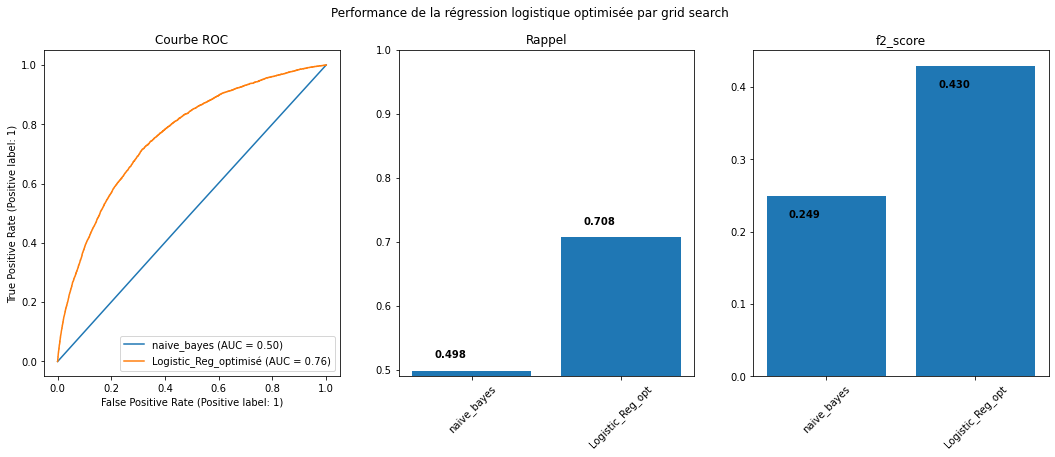

In [91]:
dummy=make_pipeline(preprocess,DummyClassifier(strategy='stratified'))
dummy.fit(X_base,y_base)

fig, (ax1, ax2,ax3) = plt.subplots(1, 3)
fig.set_size_inches(18,6)
sklearn.metrics.plot_roc_curve(dummy,x_test_base,y_test_base,name='naive_bayes',ax=ax1,response_method='predict_proba')
sklearn.metrics.plot_roc_curve(grid_lr,x_test_base,y_test_base,name='Logistic_Reg_optimisé',ax=ax1,response_method='predict_proba')

ax1.set_title(label='Courbe ROC')

nam=['naive_bayes','Logistic_Reg_opt']#,'Logistic_Reg','Random_Forest','LightGBM_opt','SVC_opt','Random_Forest_opt'
val=[sklearn.metrics.recall_score(y_test_base,dummy.predict(x_test_base)),
        sklearn.metrics.recall_score(y_test_base,grid_lr.predict(x_test_base)),
        ]
f2=[sklearn.metrics.fbeta_score(y_test_base,dummy.predict(x_test_base),beta=2),
        sklearn.metrics.fbeta_score(y_test_base,grid_lr.predict(x_test_base),beta=2),
        ]

ax2.set_ylim(0.49,1)
ax2.bar(x=nam,height=val)
ax2.set_xticklabels(nam,rotation=45)
ax2.set_title(label='Rappel')
for i, v in enumerate(val):
    ax2.text(i-0.25 ,v + 0.02,  f'{v:.3f}', color='black', fontweight='bold')

ax3.bar(x=nam,height=f2)
ax3.set_xticklabels(nam,rotation=45)
ax3.set_title(label='f2_score')
for i, v in enumerate(f2):
    ax3.text(i-0.25 ,v - 0.03,  f'{v:.3f}', color='black', fontweight='bold')    
fig.suptitle('Performance de la régression logistique optimisée par grid search')
plt.show()


In [92]:
print(f'recall du classificateur naif : {sklearn.metrics.recall_score(y_test_base,dummy.predict(x_test_base))}')
print(f'recall de la régression logistique optimisée : {sklearn.metrics.recall_score(y_test_base,grid_lr.predict(x_test_base))}')
print('\n')
print(f'f2 du classificateur naif : {sklearn.metrics.fbeta_score(y_test_base,dummy.predict(x_test_base),beta=2)}')
print(f'f2 de la régression logistique : {sklearn.metrics.fbeta_score(y_test_base,grid_lr.predict(x_test_base),beta=2)}')
print('\n')
print(f'Precision du classificateur naif : {sklearn.metrics.precision_score(y_test_base,dummy.predict(x_test_base))}')
print(f'Precision de la régression logistique : {sklearn.metrics.precision_score(y_test_base,grid_lr.predict(x_test_base))}')

print('\n')
print(f'Balanced_accu du classificateur naif : {sklearn.metrics.balanced_accuracy_score(y_test_base,dummy.predict(x_test_base))}')
print(f'Balanced_accu de la régression logistique : {sklearn.metrics.balanced_accuracy_score(y_test_base,grid_lr.predict(x_test_base))}')


recall du classificateur naif : 0.5079043372517228
recall de la régression logistique optimisée : 0.7077421970004053


f2 du classificateur naif : 0.24706116756325963
f2 de la régression logistique : 0.4297951949586451


Precision du classificateur naif : 0.08214031223683359
Precision de la régression logistique : 0.16717732669475296


Balanced_accu du classificateur naif : 0.49934281547726567
Balanced_accu de la régression logistique : 0.6995527392638106


### Grid search sur le nombre de variables : 
On a amélioré notre modèle,mais cela ne nous permet pas de voir quelles features garder ou non, on va donc aller plus loin et regarder comment le F2 de notre modèle évolue avec la quantité de variables conservées : 

Text(0.5, 1.0, 'Logistic regression : prediction scores vs n_features selected by LASSO')

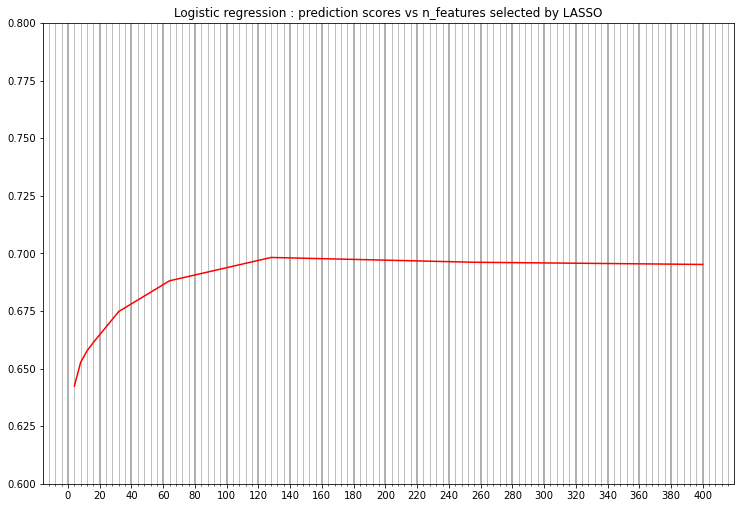

In [93]:
import matplotlib.patches as mpatches
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
fig=plt.figure(figsize=(12,8))
ax=fig.add_axes([0.1,0.1,0.8,0.8])
ax.set_ylim(0.6,0.8)
plt.plot(grid_lr.cv_results_['param_selector__max_features'].data,grid_lr.cv_results_['mean_test_score'],color='r')
ax.xaxis.set_major_locator(MultipleLocator(20))
ax.xaxis.set_minor_locator(MultipleLocator(4))
plt.grid( which='minor', axis='x')
plt.grid( which='major', axis='x',lw=2)
plt.title('Logistic regression : prediction scores vs n_features selected by LASSO')



On répète la démarche pour repérer le coude entre 64 et 128 variables

In [94]:
params_lr_nfeat={
    'selector__threshold':[-np.inf],
    'selector__max_features':[64,80,96,112,128],
    #'estimator__tol':[1e-5,1e-4,1e-3],    
    #'estimator__C':[0.1, 1, 10, 100]
}

grid_lr_n_feat=GridSearchCV(pipe_lr_featsel,params_lr_nfeat,scoring=scoringf2,verbose=3, cv=5)
grid_lr_n_feat.fit(X_base,y_base)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV 1/5] END selector__max_features=64, selector__threshold=-inf; total time=  39.4s
[CV 2/5] END selector__max_features=64, selector__threshold=-inf; total time=  25.9s
[CV 3/5] END selector__max_features=64, selector__threshold=-inf; total time=  23.1s
[CV 4/5] END selector__max_features=64, selector__threshold=-inf; total time=  23.8s
[CV 5/5] END selector__max_features=64, selector__threshold=-inf; total time=  26.7s
[CV 1/5] END selector__max_features=80, selector__threshold=-inf; total time=  39.7s
[CV 2/5] END selector__max_features=80, selector__threshold=-inf; total time=  26.0s
[CV 3/5] END selector__max_features=80, selector__threshold=-inf; total time=  23.1s
[CV 4/5] END selector__max_features=80, selector__threshold=-inf; total time=  24.0s
[CV 5/5] END selector__max_features=80, selector__threshold=-inf; total time=  26.9s
[CV 1/5] END selector__max_features=96, selector__threshold=-inf; total time=  39.7s
[CV 2

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('pipeline-1',
                                                                         Pipeline(steps=[('standardscaler',
                                                                                          StandardScaler()),
                                                                                         ('simpleimputer',
                                                                                          SimpleImputer())]),
                                                                         Index(['CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY',
       'AMT_GOODS_PRICE', 'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH',
       'DAYS_EMPLOYED', 'DAYS_REGIST...
       'FLAG_LAST_APPL_PER_CONTRACT_MIN', 'FLAG_LAST_APPL_PER_CONTRACT_MAX',
       'FLAG_LAST_APPL_PER_CONTRACT_MEAN'],
      dtype='object'))])),
 

Text(0.5, 1.0, 'Logistic regression : prediction scores vs n_features selected by LASSO')

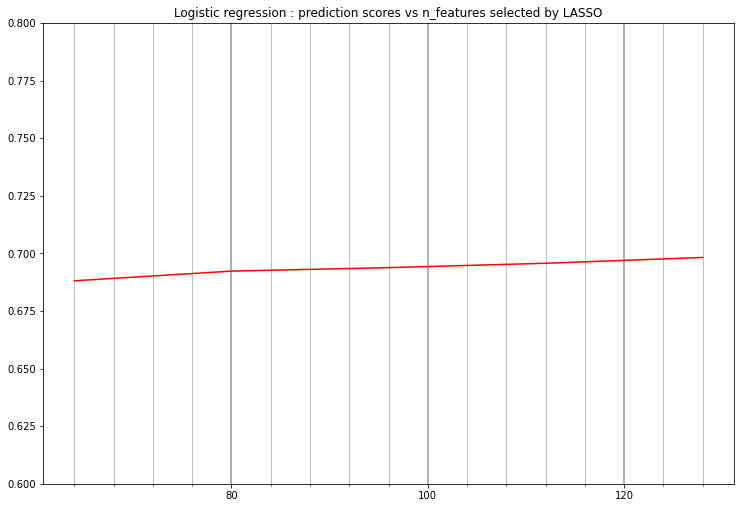

In [95]:
import matplotlib.patches as mpatches
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
fig=plt.figure(figsize=(12,8))
ax=fig.add_axes([0.1,0.1,0.8,0.8])
ax.set_ylim(0.6,0.8)
plt.plot(grid_lr_n_feat.cv_results_['param_selector__max_features'].data,grid_lr_n_feat.cv_results_['mean_test_score'],color='r')
ax.xaxis.set_major_locator(MultipleLocator(20))
ax.xaxis.set_minor_locator(MultipleLocator(4))
plt.grid( which='minor', axis='x')
plt.grid( which='major', axis='x',lw=2)
plt.title('Logistic regression : prediction scores vs n_features selected by LASSO')



Vu le gain en score de cv, on va en rester à 64 variables. 

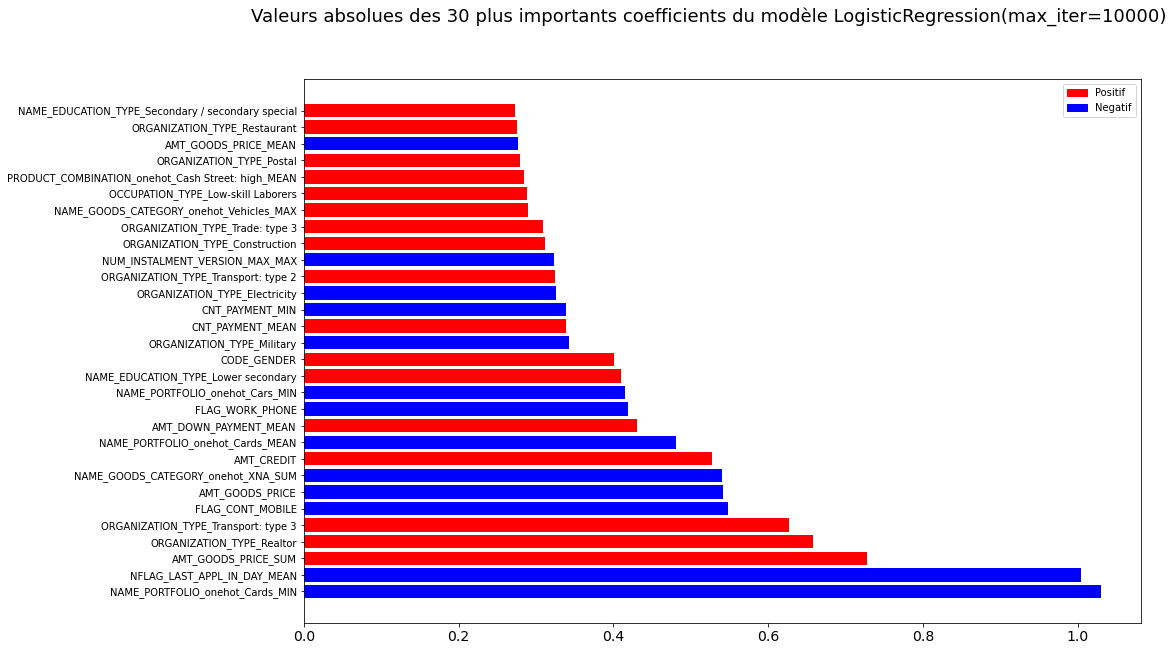

coeffs   val_abs
NAME_PORTFOLIO_onehot_Cards_MIN                   -1.030154  1.030154
NFLAG_LAST_APPL_IN_DAY_MEAN                       -1.004388  1.004388
AMT_GOODS_PRICE_SUM                                0.728216  0.728216
ORGANIZATION_TYPE_Realtor                          0.658252  0.658252
ORGANIZATION_TYPE_Transport: type 3                0.626486  0.626486
FLAG_CONT_MOBILE                                  -0.548153  0.548153
AMT_GOODS_PRICE                                   -0.541922  0.541922
NAME_GOODS_CATEGORY_onehot_XNA_SUM                -0.540554  0.540554
AMT_CREDIT                                         0.527179  0.527179
NAME_PORTFOLIO_onehot_Cards_MEAN                  -0.480974  0.480974
AMT_DOWN_PAYMENT_MEAN                              0.430117  0.430117
FLAG_WORK_PHONE                                   -0.418458  0.418458
NAME_PORTFOLIO_onehot_Cars_MIN                    -0.414965  0.414965
NAME_EDUCATION_TYPE_Lower secondary                0.409982  0.409982
CODE_GENDER                                        0.400320  0.400320
ORGANIZATION_TYPE_Military                        -0.343284  0.343284
CNT_PAYMENT_MEAN                                   0.339233  0.339233
CNT_PAYMENT_MIN                                   -0.338581  0.338581
ORGANIZATION_TYPE_Electricity                     -0.325947  0.325947
ORGANIZATION_TYPE_Transport: type 2                0.324246  0.324246
NUM_INSTALMENT_VERSION_MAX_MAX                    -0.323498  0.323498
ORGANIZATION_TYPE_Construction                     0.311867  0.311867
ORGANIZATION_TYPE_Trade: type 3                    0.309155  0.309155
NAME_GOODS_CATEGORY_onehot_Vehicles_MAX            0.289511  0.289511
OCCUPATION_TYPE_Low-skill Laborers                 0.288115  0.288115
PRODUCT_COMBINATION_onehot_Cash Street: high_MEAN  0.285163  0.285163
ORGANIZATION_TYPE_Postal                           0.278841  0.278841
AMT_GOODS_PRICE_MEAN                              -0.276444  0.276444
ORGANIZATION_TYPE_Restaurant                       0.274848  0.274848
NAME_EDUCATION_TYPE_Secondary / secondary special  0.272349  0.272349

In [96]:
def explic_model_lin(pl=pipe_lr,trainset=X,n_feat=30, graph=True) : 
    coeff=pl[-1].coef_[0]
    t=pd.concat([trainset.select_dtypes(exclude='O'),encode_cat_base(trainset.select_dtypes(include='O'))],axis=1)
    #On rajoute une ligne ici pour tenir compte du Selector
    coeffs=pd.DataFrame(coeff,index=t.columns[pl[1].get_support()])
    coeffs=coeffs.rename(columns={0:'coeffs'})
    coeffs.loc[:,'val_abs']=abs(coeffs['coeffs'])
    aff=coeffs.sort_values(by='val_abs',ascending=False).head(n_feat)
    
    names=aff.index.tolist()
    values=aff.val_abs.tolist()
    colors=[]
    [colors.append('r') if i>0 else colors.append('b') for i in aff.coeffs]
    if graph==True : 
        plt.figure(figsize=(15,10))
        plt.barh(names, values,color=colors)
        plt.suptitle(f'Valeurs absolues des {n_feat} plus importants coefficients du modèle {pl[-1]}', fontsize=18)
        plt.xticks(fontsize=14)
        plt.xticks(fontsize=14)
        red_patch = mpatches.Patch(color='red', label='Positif')
        blue_patch = mpatches.Patch(color='blue', label='Negatif')
        plt.legend(handles=[red_patch,blue_patch])
        plt.show()
    else : 
        pass
    return aff

explic_model_lin(pl=grid_lr_n_feat.best_estimator_,trainset=X_base,n_feat=30, graph=True)

On va donc garder les 64 meilleures variables pour conduire notre grid_search et optimiser la régularisation et la tolérance du modèle. 
On commence par une recherche grossière : 


In [97]:
params_lr_coarse={
    'selector__threshold':[-np.inf],
    'selector__max_features':[64],
    'estimator__tol':[1e-5,1e-4,1e-3],    
    'estimator__C':[0.01,0.1, 1, 10, 100]
}

grid_lr_custom=GridSearchCV(pipe_lr_featsel,params_lr_coarse,scoring=scoringf2,n_jobs=3,refit=True,verbose=3, cv=5)



In [98]:
grid_lr_custom.fit(X_base,y_base)
print(f'Meilleur F2 : {grid_lr_custom.best_score_:.3f}\n')
grid_lr_custom.best_estimator_

Fitting 5 folds for each of 15 candidates, totalling 75 fits
Meilleur F2 : 0.688



Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('standardscaler',
                                                                   StandardScaler()),
                                                                  ('simpleimputer',
                                                                   SimpleImputer())]),
                                                  Index(['CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY',
       'AMT_GOODS_PRICE', 'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH',
       'DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH',
       .....
       'WEEKDAY_APPR_PROCESS_START', 'ORGANIZATION_TYPE',
       'NAME_CONTRACT_TYPE_MIN', 'NAME_CONTRACT_TYPE_MAX',
       'FLAG_LAST_APPL_PER_CONTRACT_MIN', 'FLAG_LAST_APPL_PER_CONTRACT_MAX',
       'FLAG_LAST_APPL_PER_CONTRACT_MEAN'],
      dtype='object'))])),
                ('selector'

<ipython-input-99-f3682785eace>:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_xticklabels(nam,rotation=45)
<ipython-input-99-f3682785eace>:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax3.set_xticklabels(nam,rotation=45)


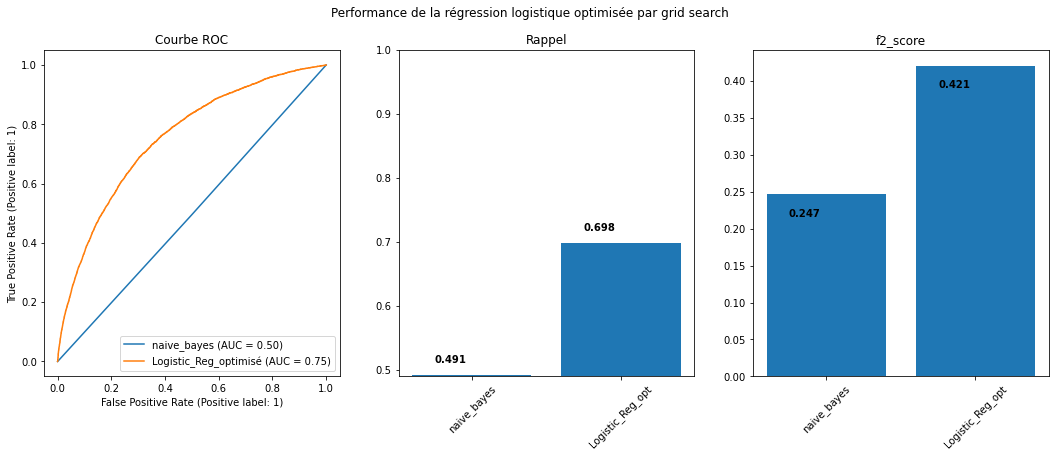

In [99]:
fig, (ax1, ax2,ax3) = plt.subplots(1, 3)
fig.set_size_inches(18,6)
sklearn.metrics.plot_roc_curve(dummy,x_test_base,y_test_base,name='naive_bayes',ax=ax1,response_method='predict_proba')
sklearn.metrics.plot_roc_curve(grid_lr_custom,x_test_base,y_test_base,name='Logistic_Reg_optimisé',ax=ax1,response_method='predict_proba')

ax1.set_title(label='Courbe ROC')

nam=['naive_bayes','Logistic_Reg_opt']
val=[sklearn.metrics.recall_score(y_test_base,dummy.predict(x_test_base)),
        sklearn.metrics.recall_score(y_test_base,grid_lr_custom.predict(x_test_base)),
        ]
f2=[sklearn.metrics.fbeta_score(y_test_base,dummy.predict(x_test_base),beta=2),
        sklearn.metrics.fbeta_score(y_test_base,grid_lr_custom.predict(x_test_base),beta=2),
        ]

ax2.set_ylim(0.49,1)
ax2.bar(x=nam,height=val)
ax2.set_xticklabels(nam,rotation=45)
ax2.set_title(label='Rappel')
for i, v in enumerate(val):
    ax2.text(i-0.25 ,v + 0.02,  f'{v:.3f}', color='black', fontweight='bold')

ax3.bar(x=nam,height=f2)
ax3.set_xticklabels(nam,rotation=45)
ax3.set_title(label='f2_score')
for i, v in enumerate(f2):
    ax3.text(i-0.25 ,v - 0.03,  f'{v:.3f}', color='black', fontweight='bold')    
fig.suptitle('Performance de la régression logistique optimisée par grid search')
plt.show()

On a perdu en généralisation...On va donc revenir à nos 256 variables qui donnaient le meilleur f2 : 

In [100]:
params_lr_fin={
    'selector__threshold':[-np.inf],
    'selector__max_features':[256],
    'estimator__tol':[1e-5],    
    'estimator__C':[0.5,0.8, 1,1.25,1.5,2]
}

grid_lr_custom=GridSearchCV(pipe_lr_featsel,params_lr_fin,scoring=scoringf2,n_jobs=3,refit=True,verbose=3, cv=5)

grid_lr_custom.fit(X_base,y_base)
print(f'Meilleur F2 : {grid_lr_custom.best_score_:.3f}\n')
grid_lr_custom.best_estimator_

Fitting 5 folds for each of 6 candidates, totalling 30 fits
Meilleur F2 : 0.696



Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('standardscaler',
                                                                   StandardScaler()),
                                                                  ('simpleimputer',
                                                                   SimpleImputer())]),
                                                  Index(['CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY',
       'AMT_GOODS_PRICE', 'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH',
       'DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH',
       .....
       'WEEKDAY_APPR_PROCESS_START', 'ORGANIZATION_TYPE',
       'NAME_CONTRACT_TYPE_MIN', 'NAME_CONTRACT_TYPE_MAX',
       'FLAG_LAST_APPL_PER_CONTRACT_MIN', 'FLAG_LAST_APPL_PER_CONTRACT_MAX',
       'FLAG_LAST_APPL_PER_CONTRACT_MEAN'],
      dtype='object'))])),
                ('selector'

<ipython-input-101-3a1fef7e3b1a>:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_xticklabels(nam,rotation=45)
<ipython-input-101-3a1fef7e3b1a>:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax3.set_xticklabels(nam,rotation=45)


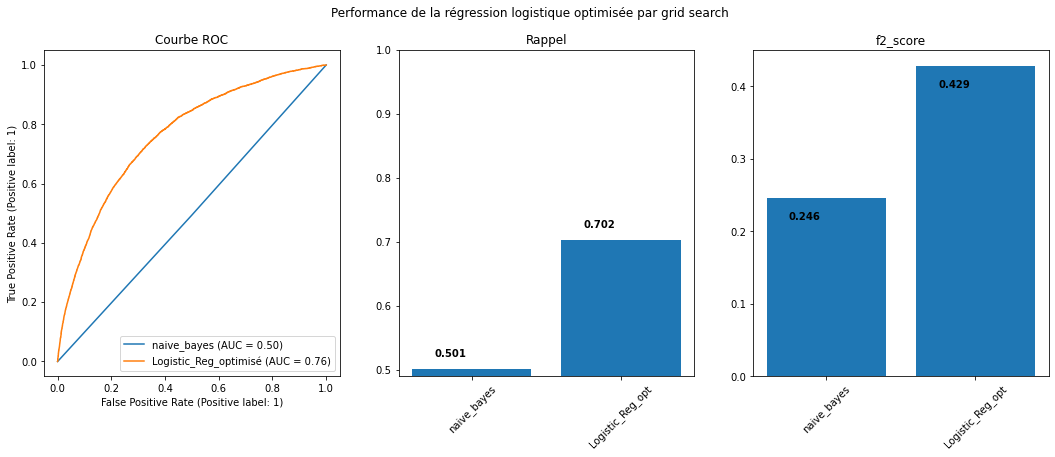

In [101]:
fig, (ax1, ax2,ax3) = plt.subplots(1, 3)
fig.set_size_inches(18,6)
sklearn.metrics.plot_roc_curve(dummy,x_test_base,y_test_base,name='naive_bayes',ax=ax1,response_method='predict_proba')
sklearn.metrics.plot_roc_curve(grid_lr_custom,x_test_base,y_test_base,name='Logistic_Reg_optimisé',ax=ax1,response_method='predict_proba')

ax1.set_title(label='Courbe ROC')

nam=['naive_bayes','Logistic_Reg_opt']#,'Logistic_Reg','Random_Forest','LightGBM_opt','SVC_opt','Random_Forest_opt'
val=[sklearn.metrics.recall_score(y_test_base,dummy.predict(x_test_base)),
        sklearn.metrics.recall_score(y_test_base,grid_lr_custom.predict(x_test_base)),
        ]
f2=[sklearn.metrics.fbeta_score(y_test_base,dummy.predict(x_test_base),beta=2),
        sklearn.metrics.fbeta_score(y_test_base,grid_lr_custom.predict(x_test_base),beta=2),
        ]

ax2.set_ylim(0.49,1)
ax2.bar(x=nam,height=val)
ax2.set_xticklabels(nam,rotation=45)
ax2.set_title(label='Rappel')
for i, v in enumerate(val):
    ax2.text(i-0.25 ,v + 0.02,  f'{v:.3f}', color='black', fontweight='bold')

ax3.bar(x=nam,height=f2)
ax3.set_xticklabels(nam,rotation=45)
ax3.set_title(label='f2_score')
for i, v in enumerate(f2):
    ax3.text(i-0.25 ,v - 0.03,  f'{v:.3f}', color='black', fontweight='bold')    
fig.suptitle('Performance de la régression logistique optimisée par grid search')
plt.show()

### Modèle Bonus : LightGBM
On va donc conserver ce modèle malgré sa complexité, car il est celui qui délivre la meilleure performance en prédiction. entraîner un modèle bonus, pour voir si le rapport qualité des prédictions / n_features varie selon le type de modèle et à quel point les résultats eux mêmes peuvent différer : 

In [102]:
from lightgbm import LGBMClassifier
from sklearn.feature_selection import SelectKBest,mutual_info_classif
lgb_selector=SelectKBest(mutual_info_classif)
lgb=LGBMClassifier()
pipe_lgb=Pipeline([('preprocessor',preprocess),('selector',lgb_selector),('estimator',lgb)])
lgb_params={'selector__k':[8,16,32,64,128,256],
           }
grid_lgb=GridSearchCV(pipe_lgb, lgb_params,scoring=scoringf2,verbose=3, cv=5)

In [103]:
grid_lgb.fit(X_base,y_base)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ..................................selector__k=8; total time= 2.0min
[CV 2/5] END ..................................selector__k=8; total time= 2.0min
[CV 3/5] END ..................................selector__k=8; total time= 2.0min
[CV 4/5] END ..................................selector__k=8; total time= 2.0min
[CV 5/5] END ..................................selector__k=8; total time= 2.0min
[CV 1/5] END .................................selector__k=16; total time= 2.0min
[CV 2/5] END .................................selector__k=16; total time= 2.0min
[CV 3/5] END .................................selector__k=16; total time= 2.0min
[CV 4/5] END .................................selector__k=16; total time= 2.0min
[CV 5/5] END .................................selector__k=16; total time= 2.0min
[CV 1/5] END .................................selector__k=32; total time= 2.0min
[CV 2/5] END .................................sel

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('pipeline-1',
                                                                         Pipeline(steps=[('standardscaler',
                                                                                          StandardScaler()),
                                                                                         ('simpleimputer',
                                                                                          SimpleImputer())]),
                                                                         Index(['CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY',
       'AMT_GOODS_PRICE', 'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH',
       'DAYS_EMPLOYED', 'DAYS_REGIST...
       'NAME_CONTRACT_TYPE_MIN', 'NAME_CONTRACT_TYPE_MAX',
       'FLAG_LAST_APPL_PER_CONTRACT_MIN', 'FLAG_LAST_APPL_PER_CONTRACT_MAX',
       'FLAG_

In [104]:
grid_lgb.best_estimator_

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('standardscaler',
                                                                   StandardScaler()),
                                                                  ('simpleimputer',
                                                                   SimpleImputer())]),
                                                  Index(['CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY',
       'AMT_GOODS_PRICE', 'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH',
       'DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH',
       .....
       'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'OCCUPATION_TYPE',
       'WEEKDAY_APPR_PROCESS_START', 'ORGANIZATION_TYPE',
       'NAME_CONTRACT_TYPE_MIN', 'NAME_CONTRACT_TYPE_MAX',
       'FLAG_LAST_APPL_PER_CONTRACT_MIN', 'FLAG_LAST_APPL_PER_CONTRACT_MAX',
       'FLAG_LAST_APPL_PER_CO

<ipython-input-105-57cc2087d0d0>:10: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


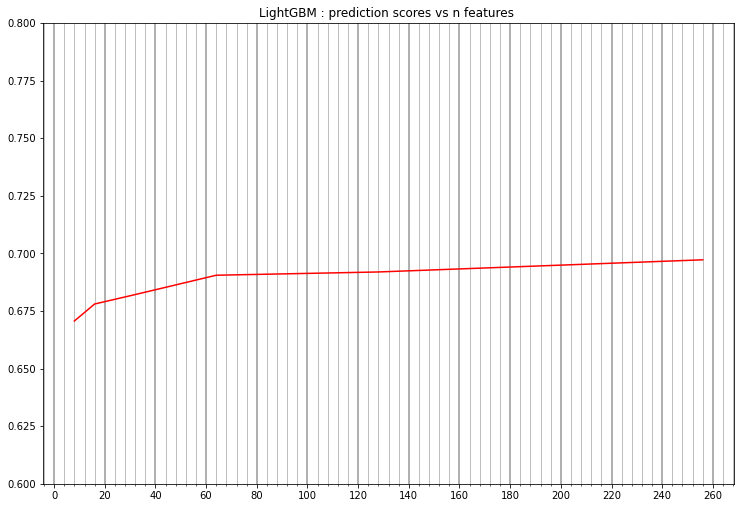

In [105]:
fig=plt.figure(figsize=(12,8))
ax=fig.add_axes([0.1,0.1,0.8,0.8])
ax.set_ylim(0.6,0.8)
ax.plot(grid_lgb.cv_results_['param_selector__k'].data,grid_lgb.cv_results_['mean_test_score'],color='r')
ax.xaxis.set_major_locator(MultipleLocator(20))
ax.xaxis.set_minor_locator(MultipleLocator(4))
plt.grid( which='minor', axis='x')
plt.grid( which='major', axis='x',lw=2)
plt.title(label='LightGBM : prediction scores vs n features ')
fig.show()


Meilleur F2 en CV : 0.697

Recall : 0.706
F2 : 0.430


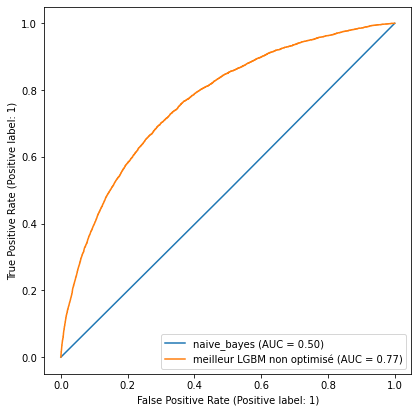

In [106]:

print(f'\nMeilleur F2 en CV : {grid_lgb.best_score_:.3f}\n')
figue=plt.figure(figsize=(6,6))
axe=figue.add_axes([0.1,0.1,0.85,0.85])
sklearn.metrics.plot_roc_curve(dummy,x_test_base,y_test_base,name='naive_bayes',ax=axe,response_method='predict_proba')
sklearn.metrics.plot_roc_curve(grid_lgb,x_test_base,y_test_base,name='meilleur LGBM non optimisé',ax=axe,response_method='predict_proba')

print(f'Recall : {sklearn.metrics.recall_score(y_test_base,grid_lgb.predict(x_test_base)):.3f}')
print(f'F2 : {sklearn.metrics.fbeta_score(y_test_base,grid_lgb.predict(x_test_base),beta=2):.3f}')



In [107]:
params_lgb_fin={
    'selector__k':[256],
    'estimator__n_estimators':[50,100,200,500],
    'estimator__learning_rate':[0.05,0.1,0.2,0.5],
}

grid_lgb_custom=GridSearchCV(pipe_lgb, params_lgb_fin,scoring=scoringf2,n_jobs=3,refit=True,verbose=3, cv=5)

grid_lgb_custom.fit(X_base,y_base)


Fitting 5 folds for each of 16 candidates, totalling 80 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('pipeline-1',
                                                                         Pipeline(steps=[('standardscaler',
                                                                                          StandardScaler()),
                                                                                         ('simpleimputer',
                                                                                          SimpleImputer())]),
                                                                         Index(['CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY',
       'AMT_GOODS_PRICE', 'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH',
       'DAYS_EMPLOYED', 'DAYS_REGIST...
       'FLAG_LAST_APPL_PER_CONTRACT_MEAN'],
      dtype='object'))])),
                                       ('selector',
                          

Meilleur F2 : 0.697

recall:0.710
F2 du classificateur aléatoire : 0.246
F2 du classificateur surprudent : 0.304
F2 du LGBM optimisé: 0.434


<ipython-input-108-abd3701ef959>:32: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_xticklabels(nam,rotation=45)
<ipython-input-108-abd3701ef959>:38: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax3.set_xticklabels(nam,rotation=45)


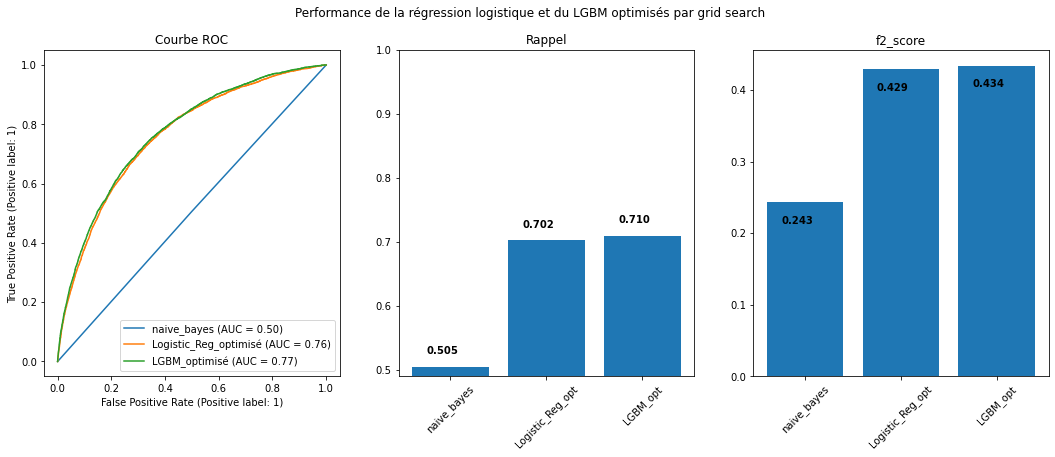

In [108]:
print(f'Meilleur F2 : {grid_lgb_custom.best_score_:.3f}\n')

dummy_one=make_pipeline(preprocess,DummyClassifier(strategy='constant', constant=1))
dummy_one.fit(X_base,y_base)


print(f'recall:{sklearn.metrics.recall_score(y_test_base,grid_lgb_custom.predict(x_test_base)):.3f}')
print(f'F2 du classificateur aléatoire : {sklearn.metrics.fbeta_score(y_test_base,dummy.predict(x_test_base),beta=2):.3f}')
print(f'F2 du classificateur surprudent : {sklearn.metrics.fbeta_score(y_test_base,dummy_one.predict(x_test_base),beta=2):.3f}')
print(f'F2 du LGBM optimisé: {sklearn.metrics.fbeta_score(y_test_base,grid_lgb_custom.predict(x_test_base),beta=2):.3f}')

fig, (ax1, ax2,ax3) = plt.subplots(1, 3)
fig.set_size_inches(18,6)
sklearn.metrics.plot_roc_curve(dummy,x_test_base,y_test_base,name='naive_bayes',ax=ax1,response_method='predict_proba')
sklearn.metrics.plot_roc_curve(grid_lr_custom,x_test_base,y_test_base,name='Logistic_Reg_optimisé',ax=ax1,response_method='predict_proba')
sklearn.metrics.plot_roc_curve(grid_lgb_custom,x_test_base,y_test_base,name='LGBM_optimisé',ax=ax1,response_method='predict_proba')

ax1.set_title(label='Courbe ROC')

nam=['naive_bayes','Logistic_Reg_opt','LGBM_opt']#,'Logistic_Reg','Random_Forest','LightGBM_opt','SVC_opt','Random_Forest_opt'
val=[sklearn.metrics.recall_score(y_test_base,dummy.predict(x_test_base)),
        sklearn.metrics.recall_score(y_test_base,grid_lr_custom.predict(x_test_base)),
     sklearn.metrics.recall_score(y_test_base,grid_lgb_custom.predict(x_test_base))
        ]
f2=[sklearn.metrics.fbeta_score(y_test_base,dummy.predict(x_test_base),beta=2),
        sklearn.metrics.fbeta_score(y_test_base,grid_lr_custom.predict(x_test_base),beta=2),
    sklearn.metrics.fbeta_score(y_test_base,grid_lgb_custom.predict(x_test_base),beta=2)
        ]

ax2.set_ylim(0.49,1)
ax2.bar(x=nam,height=val)
ax2.set_xticklabels(nam,rotation=45)
ax2.set_title(label='Rappel')
for i, v in enumerate(val):
    ax2.text(i-0.25 ,v + 0.02,  f'{v:.3f}', color='black', fontweight='bold')

ax3.bar(x=nam,height=f2)
ax3.set_xticklabels(nam,rotation=45)
ax3.set_title(label='f2_score')
for i, v in enumerate(f2):
    ax3.text(i-0.25 ,v - 0.03,  f'{v:.3f}', color='black', fontweight='bold')    
fig.suptitle('Performance de la régression logistique et du LGBM optimisés par grid search')
plt.show()

## Interpretation d'une prédiction avec LIME : 
LIME fonctionne sur le même modèle que permutation feature importance, et permet d'expliciter le "poids" des variables pour une seule prédiction. Les conseillers pourront s'appuyer sur cette fonctionnalité pour prendre leurs décisions ou les expliquer aux clients. 

In [109]:
from lime import lime_tabular

In [110]:

explainer = lime_tabular.LimeTabularExplainer(preprocess.transform(X_base), mode="classification",
                                              feature_names=colo)

In [117]:
import random
idx = random.randint(1, y_test_base.shape[0])
x_interpret=x_test_base.iloc[[idx],:]

print(f"Prediction : {grid_lr_custom.predict(x_interpret)}")
print(f"Actual : {y_test_base.iloc[idx]} ")

x_prepro=preprocess.transform(x_interpret)

explanation = explainer.explain_instance(x_prepro[0], grid_lr_custom.best_estimator_[1:].predict_proba,num_features=10)

explanation.show_in_notebook()

Prediction : [0]
Actual : 0 


Pour une prédiction sur un sujet choisi au hasard dans nos données : 

In [112]:
import random
idx = random.randint(1, y_test_base.shape[0])
x_interpret=x_test_base.iloc[[idx],:]

print(f"Prediction : {grid_lgb_custom.predict(x_interpret)}")
print(f"Actual : {y_test_base.iloc[idx]} ")

x_prepro=preprocess.transform(x_interpret)

explanation = explainer.explain_instance(x_prepro[0], grid_lgb_custom.best_estimator_[1:].predict_proba)

explanation.show_in_notebook()

Prediction : [0]
Actual : 0 


In [113]:

estimatorslist=[dummy,dummy_one,pipe_lr_base,grid_lr_custom.best_estimator_,grid_lgb_custom.best_estimator_]
comparatif2=pd.DataFrame(index=['tpr','tnr','tp','fp','tn','fn'],columns=[est.steps[-1][0]+str(g) for g,est in enumerate(estimatorslist)])
for g,est in enumerate(estimatorslist) : 
    pred=est.predict(x_test_base)
    tn=confusion_matrix(y_test_base,pred)[0,0]
    fn=confusion_matrix(y_test_base,pred)[1,0]
    tp=confusion_matrix(y_test_base,pred)[1,1]
    fp=confusion_matrix(y_test_base,pred)[0,1]
    tpr=tp/(tp+fp)
    tnr=tn/(tn+fn)
    comparatif2[est.steps[-1][0]+str(g)]=[tpr,tnr,tp,fp,tn,fn]
comparatif2

<ipython-input-113-d8701f1eb195>:10: RuntimeWarning: invalid value encountered in longlong_scalars
  tnr=tn/(tn+fn)


dummyclassifier0  dummyclassifier1  logisticregression2    estimator3  \
tpr          0.080225          0.080492             0.166185      0.167521   
tnr          0.919247               NaN             0.963431      0.963849   
tp        2428.000000       4934.000000          3452.000000   3466.000000   
fp       27837.000000      56364.000000         17320.000000  17224.000000   
tn       28527.000000          0.000000         39044.000000  39140.000000   
fn        2506.000000          0.000000          1482.000000   1468.000000   

       estimator4  
tpr      0.169743  
tnr      0.964826  
tp    3504.000000  
fp   17139.000000  
tn   39225.000000  
fn    1430.000000